In [1]:
import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
!nvidia-smi

Tue Feb 20 13:33:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   45C    P8              22W / 215W |    635MiB /  8192MiB |     12%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [6]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import traceback
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

data_dir = '../data/physionet/fold3/'

cuda


In [7]:
sr = 16000

x_train = np.load(f'{data_dir}heartsound.audio16k.train.npy', allow_pickle=True)
x_test = np.load(f'{data_dir}heartsound.audio16k.test.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}heartsound.classnames.npy', allow_pickle=True)
y_train = np.load(f'{data_dir}heartsound.labels_binary.train.npy', allow_pickle=True)
y_test = np.load(f'{data_dir}heartsound.labels_binary.test.npy', allow_pickle=True)

In [8]:
from einops import rearrange, reduce, repeat
from torch.utils.data import TensorDataset, DataLoader

def create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=32):
    x_train = torch.tensor(x_train)[:, None ,:]
    y_train = torch.tensor(y_train)
    x_test = torch.tensor(x_test)[:, None, :]
    y_test = torch.tensor(y_test)
    train_data = TensorDataset(x_train, y_train)
    test_data = TensorDataset(x_test, y_test)
    
    train_loader = DataLoader(train_data, shuffle=False, 
                              batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=True, 
                             batch_size=batch_size, drop_last=True)
    return train_loader, test_loader

In [9]:
batch_size = 32
train_loader, test_loader = create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=batch_size)
labels = classnames

In [10]:
from IConNet.nn.model import M13
from omegaconf import OmegaConf as ocf
from IConNet.visualizer import visualize_model

model_config_path = 'config/model/m13.yaml'
model_config = ocf.load(model_config_path)
print(ocf.to_yaml(model_config))
model = M13(config=model_config,
           n_input=1, n_output=2)
print(model)

print(f'total parameters: {visualize_model.count_parameters(model)}')
print(f'FE parameters: {visualize_model.count_parameters(model.fe_blocks)}')

name: M13
description: FirConv with fftconv
fe:
  n_block: 2
  n_channel:
  - 128
  - 32
  kernel_size:
  - 511
  - 127
  stride:
  - 8
  - 2
  window_k:
  - 2
  - 9
  residual_connection_type: stack
  pooling: mean
  filter_type: firwin
  conv_mode: fftconv
  norm_type: LocalResponseNorm
cls:
  n_block: 2
  n_hidden_dim:
  - 256
  - 256
  norm_type: LayerNorm

M13(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer)

In [11]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [12]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [13]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                              | 0.00205761316872428/10 [00:00<53:04, 318.50s/it]

Train Epoch: 1 [0/11751 (0%)]	Loss: 0.840363
Mem before-during-after: 633344 4366444544 33845760


  1%|▌                                                             | 0.08436213991769549/10 [00:20<39:39, 240.01s/it]

Train Epoch: 1 [1280/11751 (11%)]	Loss: 0.490068
Mem before-during-after: 33698304 4376186880 33812992


  2%|█                                                             | 0.16666666666666657/10 [00:39<39:32, 241.28s/it]

Train Epoch: 1 [2560/11751 (22%)]	Loss: 0.702595
Mem before-during-after: 33698304 4376186880 33812992


  2%|█▌                                                             | 0.2489711934156374/10 [00:58<38:46, 238.54s/it]

Train Epoch: 1 [3840/11751 (33%)]	Loss: 0.889555
Mem before-during-after: 33698304 4376186880 33812992


  3%|██                                                             | 0.3312757201646082/10 [01:18<38:21, 238.08s/it]

Train Epoch: 1 [5120/11751 (44%)]	Loss: 1.060199
Mem before-during-after: 33698304 4376186880 33812992


  4%|██▌                                                           | 0.41358024691357903/10 [01:37<38:53, 243.44s/it]

Train Epoch: 1 [6400/11751 (54%)]	Loss: 0.651115
Mem before-during-after: 33698304 4376186880 33812992


  5%|███                                                           | 0.49588477366254985/10 [01:57<39:26, 248.98s/it]

Train Epoch: 1 [7680/11751 (65%)]	Loss: 0.904327
Mem before-during-after: 33698304 4376186880 33812992


  6%|███▋                                                           | 0.5781893004115227/10 [02:16<37:59, 241.97s/it]

Train Epoch: 1 [8960/11751 (76%)]	Loss: 0.876917
Mem before-during-after: 33698304 4376186880 33812992


  7%|████▏                                                          | 0.6604938271604958/10 [02:36<38:37, 248.13s/it]

Train Epoch: 1 [10240/11751 (87%)]	Loss: 0.390191
Mem before-during-after: 33698304 4376186880 33812992


  7%|████▋                                                          | 0.7427983539094688/10 [02:55<37:50, 245.31s/it]

Train Epoch: 1 [11520/11751 (98%)]	Loss: 0.622258
Mem before-during-after: 33698304 4376186880 33812992


 10%|██████▎                                                        | 1.0000000000000095/10 [03:24<15:38, 104.31s/it]


Test Epoch: 1	Accuracy: 2931/3808 (77%)



 10%|██████▎                                                        | 1.0020576131687338/10 [03:24<21:19, 142.17s/it]

Train Epoch: 2 [0/11751 (0%)]	Loss: 0.184740
Mem before-during-after: 33658368 4377006592 33665536


 11%|██████▊                                                        | 1.0843621399177024/10 [03:44<36:06, 243.05s/it]

Train Epoch: 2 [1280/11751 (11%)]	Loss: 0.354352
Mem before-during-after: 33665536 4377096704 33665536


 12%|███████▍                                                        | 1.166666666666671/10 [04:03<35:29, 241.10s/it]

Train Epoch: 2 [2560/11751 (22%)]	Loss: 0.743692
Mem before-during-after: 33665536 4377096704 33665536


 12%|███████▊                                                       | 1.2489711934156396/10 [04:22<33:23, 228.93s/it]

Train Epoch: 2 [3840/11751 (33%)]	Loss: 0.828082
Mem before-during-after: 33665536 4377096704 33665536


 13%|████████▍                                                      | 1.3312757201646082/10 [04:41<33:29, 231.80s/it]

Train Epoch: 2 [5120/11751 (44%)]	Loss: 1.029395
Mem before-during-after: 33665536 4377096704 33665536


 14%|████████▉                                                      | 1.4135802469135768/10 [05:00<33:25, 233.54s/it]

Train Epoch: 2 [6400/11751 (54%)]	Loss: 0.642906
Mem before-during-after: 33665536 4377096704 33665536


 15%|█████████▍                                                     | 1.4958847736625454/10 [05:19<33:01, 233.01s/it]

Train Epoch: 2 [7680/11751 (65%)]	Loss: 0.847166
Mem before-during-after: 33665536 4377096704 33665536


 16%|██████████                                                      | 1.578189300411514/10 [05:38<33:47, 240.79s/it]

Train Epoch: 2 [8960/11751 (76%)]	Loss: 1.007782
Mem before-during-after: 33665536 4377096704 33665536


 17%|██████████▍                                                    | 1.6604938271604825/10 [05:57<32:38, 234.80s/it]

Train Epoch: 2 [10240/11751 (87%)]	Loss: 0.399011
Mem before-during-after: 33665536 4377096704 33665536


 17%|██████████▉                                                    | 1.7427983539094511/10 [06:16<33:09, 240.91s/it]

Train Epoch: 2 [11520/11751 (98%)]	Loss: 0.653594
Mem before-during-after: 33665536 4377096704 33665536


 20%|████████████▊                                                   | 1.999999999999978/10 [06:45<13:37, 102.14s/it]


Test Epoch: 2	Accuracy: 2930/3808 (77%)



 20%|████████████▌                                                  | 2.0020576131687022/10 [06:45<18:23, 138.03s/it]

Train Epoch: 3 [0/11751 (0%)]	Loss: 0.138571
Mem before-during-after: 33658368 4377022976 33665536


 21%|█████████████▏                                                 | 2.0843621399176797/10 [07:04<30:26, 230.78s/it]

Train Epoch: 3 [1280/11751 (11%)]	Loss: 0.154570
Mem before-during-after: 33681920 4376540160 33681920


 22%|█████████████▊                                                  | 2.166666666666657/10 [07:23<31:08, 238.52s/it]

Train Epoch: 3 [2560/11751 (22%)]	Loss: 0.439320
Mem before-during-after: 33681920 4376540160 33681920


 22%|██████████████▏                                                | 2.2489711934156347/10 [07:42<30:29, 235.97s/it]

Train Epoch: 3 [3840/11751 (33%)]	Loss: 0.845414
Mem before-during-after: 33681920 4376540160 33681920


 23%|██████████████▉                                                 | 2.331275720164612/10 [08:01<30:15, 236.78s/it]

Train Epoch: 3 [5120/11751 (44%)]	Loss: 0.615341
Mem before-during-after: 33681920 4376540160 33681920


 24%|███████████████▏                                               | 2.4135802469135896/10 [08:20<30:04, 237.82s/it]

Train Epoch: 3 [6400/11751 (54%)]	Loss: 0.485326
Mem before-during-after: 33681920 4376540160 33681920


 25%|███████████████▉                                                | 2.495884773662567/10 [08:39<28:35, 228.62s/it]

Train Epoch: 3 [7680/11751 (65%)]	Loss: 0.159073
Mem before-during-after: 33681920 4376540160 33681920


 26%|████████████████▏                                              | 2.5781893004115446/10 [08:58<28:45, 232.47s/it]

Train Epoch: 3 [8960/11751 (76%)]	Loss: 0.643105
Mem before-during-after: 33681920 4376540160 33681920


 27%|█████████████████                                               | 2.660493827160522/10 [09:17<28:47, 235.40s/it]

Train Epoch: 3 [10240/11751 (87%)]	Loss: 0.659833
Mem before-during-after: 33681920 4376540160 33681920


 27%|█████████████████▎                                             | 2.7427983539094996/10 [09:36<28:12, 233.22s/it]

Train Epoch: 3 [11520/11751 (98%)]	Loss: 0.712467
Mem before-during-after: 33681920 4376540160 33681920


 30%|███████████████████▏                                            | 3.000000000000054/10 [10:05<19:31, 167.29s/it]


Test Epoch: 3	Accuracy: 2997/3808 (78%)



 30%|██████████████████▉                                            | 3.0020576131687786/10 [10:05<21:55, 187.99s/it]

Train Epoch: 4 [0/11751 (0%)]	Loss: 0.055947
Mem before-during-after: 33658368 4377088512 34599936


 31%|███████████████████▋                                            | 3.084362139917756/10 [10:25<26:55, 233.60s/it]

Train Epoch: 4 [1280/11751 (11%)]	Loss: 0.522971
Mem before-during-after: 33681920 4376908800 33681920


 32%|███████████████████▉                                           | 3.1666666666667336/10 [10:44<28:37, 251.41s/it]

Train Epoch: 4 [2560/11751 (22%)]	Loss: 0.458229
Mem before-during-after: 33681920 4376908800 33681920


 32%|████████████████████▊                                           | 3.248971193415711/10 [11:03<26:33, 236.07s/it]

Train Epoch: 4 [3840/11751 (33%)]	Loss: 0.747912
Mem before-during-after: 33681920 4376908800 33681920


 33%|████████████████████▉                                          | 3.3312757201646885/10 [11:22<25:52, 232.81s/it]

Train Epoch: 4 [5120/11751 (44%)]	Loss: 0.505885
Mem before-during-after: 33681920 4376908800 33681920


 34%|█████████████████████▊                                          | 3.413580246913666/10 [11:41<25:44, 234.45s/it]

Train Epoch: 4 [6400/11751 (54%)]	Loss: 0.520158
Mem before-during-after: 33681920 4376908800 33681920


 35%|██████████████████████                                         | 3.4958847736626435/10 [12:00<25:52, 238.62s/it]

Train Epoch: 4 [7680/11751 (65%)]	Loss: 0.103356
Mem before-during-after: 33681920 4376908800 33681920


 36%|██████████████████████▉                                         | 3.578189300411621/10 [12:20<25:12, 235.53s/it]

Train Epoch: 4 [8960/11751 (76%)]	Loss: 0.581267
Mem before-during-after: 33681920 4376908800 33681920


 37%|███████████████████████                                        | 3.6604938271605985/10 [12:39<24:45, 234.38s/it]

Train Epoch: 4 [10240/11751 (87%)]	Loss: 0.548143
Mem before-during-after: 33681920 4376908800 33681920


 37%|███████████████████████▉                                        | 3.742798353909576/10 [12:58<25:03, 240.31s/it]

Train Epoch: 4 [11520/11751 (98%)]	Loss: 0.712394
Mem before-during-after: 33681920 4376908800 33681920


 40%|█████████████████████████▌                                      | 4.000000000000131/10 [13:26<10:16, 102.74s/it]


Test Epoch: 4	Accuracy: 2974/3808 (78%)



 40%|█████████████████████████▌                                      | 4.002057613168855/10 [13:27<13:51, 138.70s/it]

Train Epoch: 5 [0/11751 (0%)]	Loss: 0.063285
Mem before-during-after: 33658368 4377088512 34599936


 41%|█████████████████████████▋                                     | 4.0843621399178325/10 [13:46<23:00, 233.42s/it]

Train Epoch: 5 [1280/11751 (11%)]	Loss: 0.584486
Mem before-during-after: 33681920 4376908800 33681920


 42%|███████████████████████████                                      | 4.16666666666681/10 [14:05<25:25, 261.45s/it]

Train Epoch: 5 [2560/11751 (22%)]	Loss: 0.365220
Mem before-during-after: 33681920 4376908800 33681920


 42%|███████████████████████████▏                                    | 4.248971193415787/10 [14:24<22:38, 236.13s/it]

Train Epoch: 5 [3840/11751 (33%)]	Loss: 0.709978
Mem before-during-after: 33681920 4376908800 33681920


 43%|███████████████████████████▋                                    | 4.331275720164765/10 [14:43<22:00, 233.00s/it]

Train Epoch: 5 [5120/11751 (44%)]	Loss: 0.463223
Mem before-during-after: 33681920 4376908800 33681920


 44%|████████████████████████████▏                                   | 4.413580246913742/10 [15:01<21:39, 232.55s/it]

Train Epoch: 5 [6400/11751 (54%)]	Loss: 0.480589
Mem before-during-after: 33681920 4376908800 33681920


 45%|█████████████████████████████▏                                   | 4.49588477366272/10 [15:20<21:31, 234.67s/it]

Train Epoch: 5 [7680/11751 (65%)]	Loss: 0.120343
Mem before-during-after: 33681920 4376908800 33681920


 46%|█████████████████████████████▎                                  | 4.578189300411697/10 [15:39<21:28, 237.64s/it]

Train Epoch: 5 [8960/11751 (76%)]	Loss: 0.650430
Mem before-during-after: 33681920 4376908800 33681920


 47%|█████████████████████████████▊                                  | 4.660493827160675/10 [15:58<21:09, 237.80s/it]

Train Epoch: 5 [10240/11751 (87%)]	Loss: 0.496442
Mem before-during-after: 33681920 4376908800 33681920


 47%|██████████████████████████████▎                                 | 4.742798353909652/10 [16:17<20:47, 237.22s/it]

Train Epoch: 5 [11520/11751 (98%)]	Loss: 0.712504
Mem before-during-after: 33681920 4376908800 33681920


 50%|████████████████████████████████                                | 5.000000000000207/10 [16:46<08:58, 107.68s/it]


Test Epoch: 5	Accuracy: 3028/3808 (79%)



 50%|████████████████████████████████                                | 5.002057613168931/10 [16:47<12:07, 145.52s/it]

Train Epoch: 6 [0/11751 (0%)]	Loss: 0.055166
Mem before-during-after: 33658368 4377088512 34599936


 51%|████████████████████████████████▌                               | 5.084362139917909/10 [17:06<19:22, 236.53s/it]

Train Epoch: 6 [1280/11751 (11%)]	Loss: 0.508598
Mem before-during-after: 33681920 4376908800 33681920


 52%|█████████████████████████████████                               | 5.166666666666886/10 [17:25<18:46, 232.99s/it]

Train Epoch: 6 [2560/11751 (22%)]	Loss: 0.299583
Mem before-during-after: 33681920 4376908800 33681920


 52%|█████████████████████████████████▌                              | 5.248971193415864/10 [17:44<19:12, 242.66s/it]

Train Epoch: 6 [3840/11751 (33%)]	Loss: 0.768052
Mem before-during-after: 33681920 4376908800 33681920


 53%|██████████████████████████████████                              | 5.331275720164841/10 [18:03<18:09, 233.43s/it]

Train Epoch: 6 [5120/11751 (44%)]	Loss: 0.608490
Mem before-during-after: 33681920 4376908800 33681920


 54%|██████████████████████████████████▋                             | 5.413580246913819/10 [18:22<17:52, 233.75s/it]

Train Epoch: 6 [6400/11751 (54%)]	Loss: 0.553077
Mem before-during-after: 33681920 4376908800 33681920


 55%|███████████████████████████████████▏                            | 5.495884773662796/10 [18:41<18:33, 247.19s/it]

Train Epoch: 6 [7680/11751 (65%)]	Loss: 0.122063
Mem before-during-after: 33681920 4376908800 33681920


 56%|███████████████████████████████████▋                            | 5.578189300411774/10 [19:01<17:42, 240.30s/it]

Train Epoch: 6 [8960/11751 (76%)]	Loss: 0.715916
Mem before-during-after: 33681920 4376908800 33681920


 57%|████████████████████████████████████▏                           | 5.660493827160751/10 [19:20<16:58, 234.80s/it]

Train Epoch: 6 [10240/11751 (87%)]	Loss: 0.499572
Mem before-during-after: 33681920 4376908800 33681920


 57%|████████████████████████████████████▊                           | 5.742798353909729/10 [19:39<16:09, 227.68s/it]

Train Epoch: 6 [11520/11751 (98%)]	Loss: 0.701819
Mem before-during-after: 33681920 4376908800 33681920


 60%|██████████████████████████████████████▍                         | 6.000000000000283/10 [20:08<06:46, 101.74s/it]


Test Epoch: 6	Accuracy: 3027/3808 (79%)



 60%|██████████████████████████████████████▍                         | 6.002057613169008/10 [20:08<09:05, 136.55s/it]

Train Epoch: 7 [0/11751 (0%)]	Loss: 0.072752
Mem before-during-after: 33658368 4377088512 34599936


 61%|██████████████████████████████████████▉                         | 6.084362139917985/10 [20:27<15:34, 238.58s/it]

Train Epoch: 7 [1280/11751 (11%)]	Loss: 0.580488
Mem before-during-after: 33681920 4376908800 33681920


 62%|███████████████████████████████████████▍                        | 6.166666666666963/10 [20:46<14:59, 234.53s/it]

Train Epoch: 7 [2560/11751 (22%)]	Loss: 0.225283
Mem before-during-after: 33681920 4376908800 33681920


 62%|████████████████████████████████████████▌                        | 6.24897119341594/10 [21:06<15:16, 244.32s/it]

Train Epoch: 7 [3840/11751 (33%)]	Loss: 0.786965
Mem before-during-after: 33681920 4376908800 33681920


 63%|████████████████████████████████████████▌                       | 6.331275720164918/10 [21:25<14:37, 239.14s/it]

Train Epoch: 7 [5120/11751 (44%)]	Loss: 0.594575
Mem before-during-after: 33681920 4376908800 33681920


 64%|█████████████████████████████████████████                       | 6.413580246913895/10 [21:45<15:01, 251.32s/it]

Train Epoch: 7 [6400/11751 (54%)]	Loss: 0.578395
Mem before-during-after: 33681920 4376908800 33681920


 65%|█████████████████████████████████████████▌                      | 6.495884773662873/10 [22:04<13:50, 236.88s/it]

Train Epoch: 7 [7680/11751 (65%)]	Loss: 0.111970
Mem before-during-after: 33681920 4376908800 33681920


 66%|██████████████████████████████████████████▊                      | 6.57818930041185/10 [22:23<13:13, 231.98s/it]

Train Epoch: 7 [8960/11751 (76%)]	Loss: 0.801896
Mem before-during-after: 33681920 4376908800 33681920


 67%|██████████████████████████████████████████▋                     | 6.660493827160828/10 [22:42<13:01, 234.02s/it]

Train Epoch: 7 [10240/11751 (87%)]	Loss: 0.467420
Mem before-during-after: 33681920 4376908800 33681920


 67%|███████████████████████████████████████████▏                    | 6.742798353909805/10 [23:01<12:55, 238.00s/it]

Train Epoch: 7 [11520/11751 (98%)]	Loss: 0.706047
Mem before-during-after: 33681920 4376908800 33681920


 70%|█████████████████████████████████████████████▌                   | 7.00000000000036/10 [23:29<05:19, 106.61s/it]


Test Epoch: 7	Accuracy: 3007/3808 (79%)



 70%|████████████████████████████████████████████▊                   | 7.002057613169084/10 [23:30<07:58, 159.64s/it]

Train Epoch: 8 [0/11751 (0%)]	Loss: 0.050870
Mem before-during-after: 33658368 4377088512 34599936


 71%|█████████████████████████████████████████████▎                  | 7.084362139918062/10 [23:49<11:36, 238.79s/it]

Train Epoch: 8 [1280/11751 (11%)]	Loss: 0.438544
Mem before-during-after: 33681920 4376908800 33681920


 72%|█████████████████████████████████████████████▊                  | 7.166666666667039/10 [24:08<11:50, 250.66s/it]

Train Epoch: 8 [2560/11751 (22%)]	Loss: 0.268383
Mem before-during-after: 33681920 4376908800 33681920


 72%|██████████████████████████████████████████████▍                 | 7.248971193416017/10 [24:27<10:38, 232.10s/it]

Train Epoch: 8 [3840/11751 (33%)]	Loss: 0.785281
Mem before-during-after: 33681920 4376908800 33681920


 73%|██████████████████████████████████████████████▉                 | 7.331275720164994/10 [24:47<10:19, 232.01s/it]

Train Epoch: 8 [5120/11751 (44%)]	Loss: 0.559749
Mem before-during-after: 33681920 4376908800 33681920


 74%|██████████████████████████████████████████████▋                | 7.4135802469139715/10 [25:06<10:59, 255.09s/it]

Train Epoch: 8 [6400/11751 (54%)]	Loss: 0.452140
Mem before-during-after: 33681920 4376908800 33681920


 75%|███████████████████████████████████████████████▉                | 7.495884773662949/10 [25:25<09:52, 236.76s/it]

Train Epoch: 8 [7680/11751 (65%)]	Loss: 0.103574
Mem before-during-after: 33681920 4376908800 33681920


 76%|███████████████████████████████████████████████▋               | 7.5781893004119265/10 [25:44<09:36, 237.98s/it]

Train Epoch: 8 [8960/11751 (76%)]	Loss: 0.690059
Mem before-during-after: 33681920 4376908800 33681920


 77%|█████████████████████████████████████████████████               | 7.660493827160904/10 [26:04<09:13, 236.50s/it]

Train Epoch: 8 [10240/11751 (87%)]	Loss: 0.504344
Mem before-during-after: 33681920 4376908800 33681920


 77%|████████████████████████████████████████████████▊              | 7.7427983539098815/10 [26:23<08:50, 235.11s/it]

Train Epoch: 8 [11520/11751 (98%)]	Loss: 0.651710
Mem before-during-after: 33681920 4376908800 33681920


 80%|███████████████████████████████████████████████████▏            | 8.000000000000435/10 [26:51<03:21, 100.95s/it]


Test Epoch: 8	Accuracy: 3045/3808 (80%)



 80%|███████████████████████████████████████████████████▏            | 8.002057613169159/10 [26:51<04:35, 138.07s/it]

Train Epoch: 9 [0/11751 (0%)]	Loss: 0.064812
Mem before-during-after: 33658368 4377088512 34599936


 81%|█████████████████████████████████████████████████████▎            | 8.0843621399181/10 [27:10<07:32, 236.09s/it]

Train Epoch: 9 [1280/11751 (11%)]	Loss: 0.342712
Mem before-during-after: 33681920 4376908800 33681920


 82%|████████████████████████████████████████████████████▎           | 8.166666666667043/10 [27:29<07:20, 240.21s/it]

Train Epoch: 9 [2560/11751 (22%)]	Loss: 0.225364
Mem before-during-after: 33681920 4376908800 33681920


 82%|████████████████████████████████████████████████████▊           | 8.248971193415985/10 [27:48<06:51, 235.20s/it]

Train Epoch: 9 [3840/11751 (33%)]	Loss: 0.656165
Mem before-during-after: 33681920 4376908800 33681920


 83%|█████████████████████████████████████████████████████▎          | 8.331275720164927/10 [28:08<06:39, 239.35s/it]

Train Epoch: 9 [5120/11751 (44%)]	Loss: 0.390404
Mem before-during-after: 33681920 4376908800 33681920


 84%|█████████████████████████████████████████████████████▊          | 8.413580246913869/10 [28:27<06:13, 235.63s/it]

Train Epoch: 9 [6400/11751 (54%)]	Loss: 0.385402
Mem before-during-after: 33681920 4376908800 33681920


 85%|███████████████████████████████████████████████████████▏         | 8.49588477366281/10 [28:46<05:56, 237.10s/it]

Train Epoch: 9 [7680/11751 (65%)]	Loss: 0.096095
Mem before-during-after: 33681920 4376908800 33681920


 86%|██████████████████████████████████████████████████████▉         | 8.578189300411752/10 [29:05<05:33, 234.65s/it]

Train Epoch: 9 [8960/11751 (76%)]	Loss: 0.522733
Mem before-during-after: 33681920 4376908800 33681920


 87%|███████████████████████████████████████████████████████▍        | 8.660493827160694/10 [29:24<05:23, 241.36s/it]

Train Epoch: 9 [10240/11751 (87%)]	Loss: 0.515867
Mem before-during-after: 33681920 4376908800 33681920


 87%|███████████████████████████████████████████████████████▉        | 8.742798353909636/10 [29:43<04:57, 236.30s/it]

Train Epoch: 9 [11520/11751 (98%)]	Loss: 0.595532
Mem before-during-after: 33681920 4376908800 33681920


 90%|██████████████████████████████████████████████████████████▌      | 9.00000000000008/10 [30:12<01:45, 105.84s/it]


Test Epoch: 9	Accuracy: 3072/3808 (80%)



 90%|█████████████████████████████████████████████████████████▌      | 9.002057613168803/10 [30:12<02:20, 141.10s/it]

Train Epoch: 10 [0/11751 (0%)]	Loss: 0.079163
Mem before-during-after: 33658368 4377088512 34599936


 91%|██████████████████████████████████████████████████████████▏     | 9.084362139917745/10 [30:32<03:34, 234.30s/it]

Train Epoch: 10 [1280/11751 (11%)]	Loss: 0.241059
Mem before-during-after: 33681920 4376908800 33681920


 92%|██████████████████████████████████████████████████████████▋     | 9.166666666666687/10 [30:51<03:13, 232.58s/it]

Train Epoch: 10 [2560/11751 (22%)]	Loss: 0.379274
Mem before-during-after: 33681920 4376908800 33681920


 92%|████████████████████████████████████████████████████████████     | 9.24897119341563/10 [31:10<02:55, 233.76s/it]

Train Epoch: 10 [3840/11751 (33%)]	Loss: 0.442902
Mem before-during-after: 33681920 4376908800 33681920


 93%|███████████████████████████████████████████████████████████▋    | 9.331275720164571/10 [31:29<02:37, 235.87s/it]

Train Epoch: 10 [5120/11751 (44%)]	Loss: 0.236389
Mem before-during-after: 33681920 4376908800 33681920


 94%|████████████████████████████████████████████████████████████▏   | 9.413580246913513/10 [31:48<02:19, 237.37s/it]

Train Epoch: 10 [6400/11751 (54%)]	Loss: 0.353703
Mem before-during-after: 33681920 4376908800 33681920


 95%|████████████████████████████████████████████████████████████▊   | 9.495884773662455/10 [32:08<01:58, 235.52s/it]

Train Epoch: 10 [7680/11751 (65%)]	Loss: 0.093234
Mem before-during-after: 33681920 4376908800 33681920


 96%|█████████████████████████████████████████████████████████████▎  | 9.578189300411397/10 [32:27<01:40, 238.62s/it]

Train Epoch: 10 [8960/11751 (76%)]	Loss: 0.288452
Mem before-during-after: 33681920 4376908800 33681920


 97%|█████████████████████████████████████████████████████████████▊  | 9.660493827160339/10 [32:46<01:21, 238.59s/it]

Train Epoch: 10 [10240/11751 (87%)]	Loss: 0.562407
Mem before-during-after: 33681920 4376908800 33681920


 97%|██████████████████████████████████████████████████████████████▎ | 9.742798353909281/10 [33:33<02:21, 549.99s/it]

Train Epoch: 10 [11520/11751 (98%)]	Loss: 0.471372
Mem before-during-after: 33681920 4376908800 33681920


100%|███████████████████████████████████████████████████████████████▉| 9.999999999999725/10 [35:23<00:00, 212.32s/it]


Test Epoch: 10	Accuracy: 3103/3808 (81%)



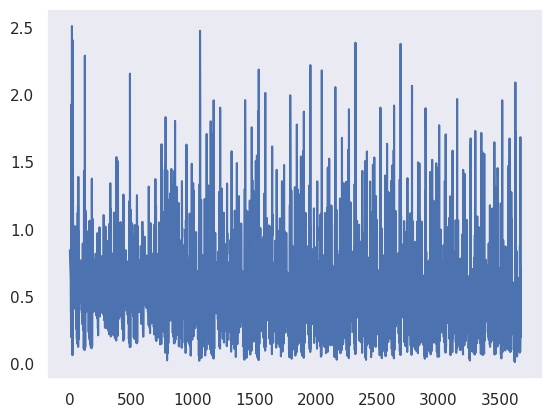

In [14]:
plt.plot(train_losses)

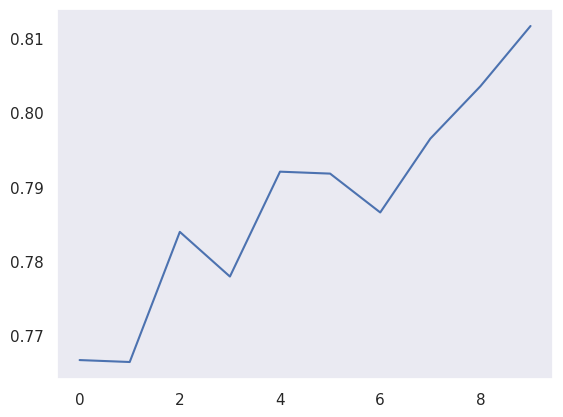

In [15]:
plt.plot(test_accuracy)

In [16]:
model_path = '../physio16k_fold3_m13_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [17]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from torchmetrics.wrappers import ClasswiseWrapper
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s': MulticlassF1Score(num_classes=n),  
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc': MulticlassAUROC(num_classes=n, average=None, thresholds=None)
    }
    # , compute_groups=[['acc', 'f1s', 'wap'], ['uap', 'uar']]
                              ).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [18]:
metrics, confusion_matrix = report_metrics(model)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 3104/3808 (0.8151)
{'acc_detail': tensor([0.2893, 0.9727], device='cuda:0'),
 'acc_unweighted': tensor(0.6310, device='cuda:0'),
 'acc_weighted': tensor(0.8151, device='cuda:0'),
 'f1s': tensor(0.6546, device='cuda:0'),
 'f1s_detail': tensor([0.4191, 0.8901], device='cuda:0'),
 'precision_detail': tensor([0.7605, 0.8204], device='cuda:0'),
 'recall_detail': tensor([0.2893, 0.9727], device='cuda:0'),
 'rocauc': tensor([0.8062, 0.8062], device='cuda:0'),
 'uar': tensor(0.6310, device='cuda:0'),
 'wap': tensor(0.8066, device='cuda:0')}


tensor([[ 254,  624],
        [  80, 2850]], device='cuda:0')

In [19]:
layer = model.fe_blocks.blocks[0].block.layer
visualize_model.print_parameters(layer)

('lowcut_bands', Parameter containing:
tensor([[0.0000],
        [0.0036],
        [0.0075],
        [0.0117],
        [0.0162],
        [0.0211],
        [0.0264],
        [0.0322],
        [0.0384],
        [0.0451],
        [0.0524],
        [0.0603],
        [0.0688],
        [0.0780],
        [0.0880],
        [0.0988],
        [0.1105],
        [0.1231],
        [0.1368],
        [0.1516],
        [0.1676],
        [0.1849],
        [0.2036],
        [0.2239],
        [0.2458],
        [0.2696],
        [0.2952],
        [0.3230],
        [0.3531],
        [0.3856],
        [0.4208],
        [0.4588],
        [0.0000],
        [0.0054],
        [0.0111],
        [0.0171],
        [0.0235],
        [0.0303],
        [0.0375],
        [0.0452],
        [0.0534],
        [0.0620],
        [0.0712],
        [0.0809],
        [0.0912],
        [0.1022],
        [0.1138],
        [0.1261],
        [0.1392],
        [0.1531],
        [0.1679],
        [0.1835],
        [0.2002],
       

In [20]:
[print(p.grad) for p in layer.parameters() if p.requires_grad]

tensor([[ 0.0000e+00],
        [ 1.1183e-16],
        [ 1.6740e-15],
        [ 9.3534e-15],
        [ 1.7926e-16],
        [-5.1276e-16],
        [ 1.9747e-17],
        [ 8.9099e-17],
        [ 2.7617e-15],
        [ 1.0826e-14],
        [-1.4249e-16],
        [ 1.4172e-16],
        [ 2.1166e-16],
        [-4.4070e-15],
        [-5.4690e-14],
        [ 2.2419e-18],
        [ 3.2534e-18],
        [ 2.4111e-16],
        [ 6.6576e-18],
        [-2.2007e-17],
        [-2.0232e-16],
        [ 1.7718e-15],
        [ 2.0205e-16],
        [-5.1726e-19],
        [ 1.4429e-17],
        [ 7.2303e-18],
        [-6.0721e-16],
        [ 3.2169e-16],
        [-5.2453e-16],
        [-8.3736e-14],
        [-3.0426e-13],
        [-4.3375e-17],
        [ 0.0000e+00],
        [-3.2316e-17],
        [ 6.8900e-17],
        [ 3.9352e-15],
        [ 1.5587e-13],
        [ 2.6932e-16],
        [ 2.0405e-15],
        [ 1.9951e-15],
        [ 1.6216e-17],
        [ 5.1555e-17],
        [ 4.1805e-17],
        [ 2

[None, None, None]

(array([11.,  7.,  5.,  6.,  4.,  7.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
         1.,  3.,  4.,  3.,  2.,  3.,  3.,  3.,  2.,  2.,  2.,  3.,  2.,
         1.,  4.,  0.,  4.,  0.,  3.,  2.,  2.,  1.,  2.,  2.,  1.,  2.,
         3.]),
 array([0.        , 0.01191887, 0.02383774, 0.03575661, 0.04767548,
        0.05959435, 0.07151322, 0.08343209, 0.09535096, 0.10726982,
        0.1191887 , 0.13110757, 0.14302644, 0.1549453 , 0.16686417,
        0.17878304, 0.19070192, 0.20262079, 0.21453965, 0.22645852,
        0.23837739, 0.25029626, 0.26221514, 0.27413401, 0.28605288,
        0.29797173, 0.3098906 , 0.32180947, 0.33372834, 0.34564722,
        0.35756609, 0.36948496, 0.38140383, 0.39332271, 0.40524158,
        0.41716045, 0.42907929, 0.44099817, 0.45291704, 0.46483591,
        0.47675478]),
 <BarContainer object of 40 artists>)

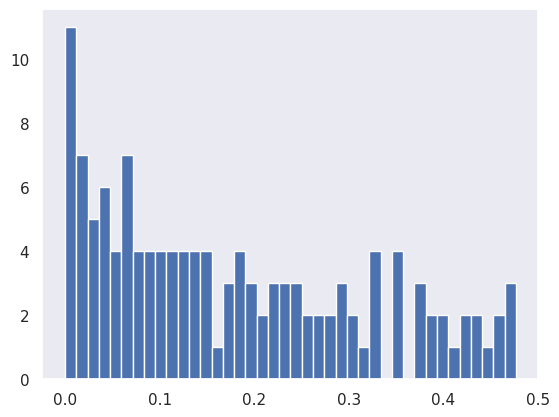

In [21]:
named_params = [p for p in layer.named_parameters()]
lowbands = named_params[0][1].detach().cpu().numpy()
plt.hist(lowbands.flatten(), bins=40)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   2.,   1.,   1.,   0.,   2., 117.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([-5.64248463e-13, -5.46245503e-13, -5.28242543e-13, -5.10239583e-13,
        -4.92236677e-13, -4.74233717e-13, -4.56230756e-13, -4.38227796e-13,
        -4.20224836e-13, -4.02221903e-13, -3.84218942e-13, -3.66215982e-13,
        -3.48213049e-13, -3.30210089e-13, -3.12207129e-13, -2.94204168e-13,
        -2.76201235e-13, -2.58198275e-13, -2.40195315e-13, -2.22192368e-13,
        -2.04189421e-13, -1.86186475e-13, -1.68183515e-13, -1.50180568e-13,
        -1.32177608e-13, -1.14174661e-13, -9.61717075e-14, -7.81687540e-14,
        -6.01658073e-14, -4.21628539e-14, -2.41599004e-14, -6.15694824e-15,
         1.18460039e-14,  2.98489566e-14,  4.78519066e-14,  6.58548601e-14,
         8.38578135e-14,  1.01860767e-13, 

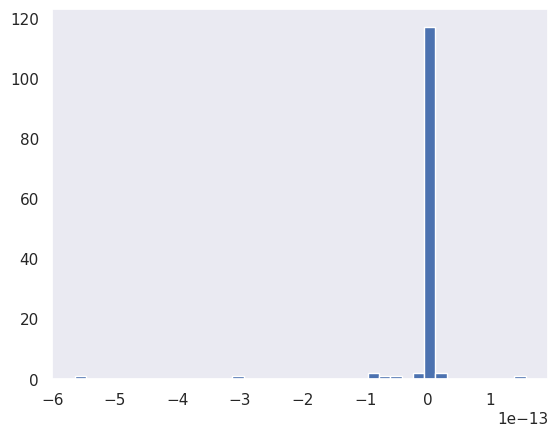

In [22]:
lowbands = named_params[0][1].grad.detach().cpu().numpy()
plt.hist(lowbands.flatten(), bins=40)

/tmp/ipykernel_3581021/1402059949.py:1: RuntimeWarning: divide by zero encountered in log
  grad_log = np.log(lowbands.flatten())
/tmp/ipykernel_3581021/1402059949.py:1: RuntimeWarning: invalid value encountered in log
  grad_log = np.log(lowbands.flatten())


(array([1., 0., 0., 0., 1., 0., 0., 0., 2., 2., 1., 5., 2., 3., 5., 2., 2.,
        3., 3., 2., 6., 8., 3., 1., 3., 2., 0., 5., 1., 2., 2., 1., 4., 1.,
        0., 0., 0., 0., 0., 1.]),
 array([-43.62042999, -43.26716232, -42.91389465, -42.5606308 ,
        -42.20736313, -41.85409546, -41.50082779, -41.14756393,
        -40.79429626, -40.44102859, -40.08776093, -39.73449326,
        -39.3812294 , -39.02796173, -38.67469406, -38.32142639,
        -37.96816254, -37.61489487, -37.2616272 , -36.90835953,
        -36.55509186, -36.201828  , -35.84856033, -35.49529266,
        -35.14202499, -34.78876114, -34.43549347, -34.0822258 ,
        -33.72895813, -33.37569427, -33.02242661, -32.66915894,
        -32.31589127, -31.9626255 , -31.60935783, -31.25609207,
        -30.9028244 , -30.54955864, -30.19629097, -29.84302521,
        -29.48975754]),
 <BarContainer object of 40 artists>)

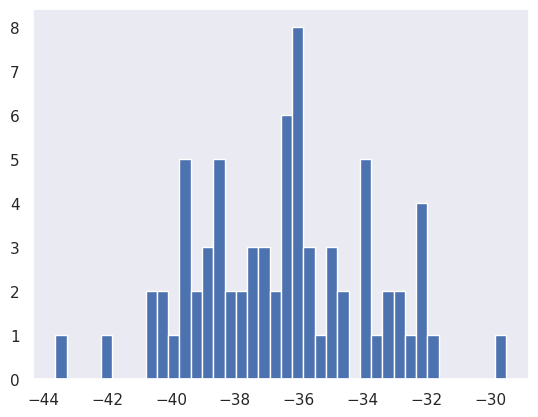

In [23]:
grad_log = np.log(lowbands.flatten())
grad_log = grad_log[grad_log > float('-inf')]
plt.hist(grad_log, bins=40)

(array([ 1.,  1., 10., 12., 10., 18., 10.,  6.,  5.,  1.]),
 array([-43.62042999, -42.20736313, -40.79429626, -39.3812294 ,
        -37.96816254, -36.55509186, -35.14202499, -33.72895813,
        -32.31589127, -30.9028244 , -29.48975754]),
 <BarContainer object of 10 artists>)

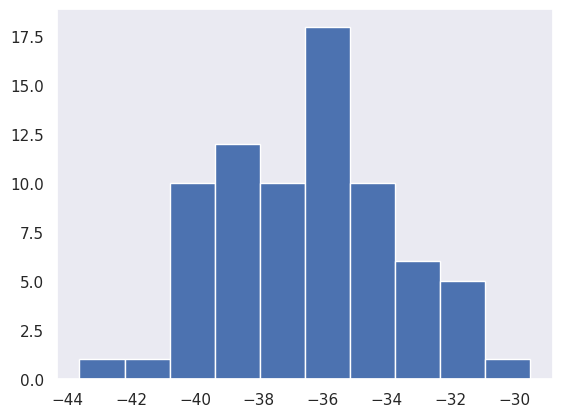

In [24]:
plt.hist(grad_log, bins=10)

(array([3., 4., 4., 5., 6., 6., 7., 8., 7., 5., 8., 6., 5., 5., 6., 3., 4.,
        5., 4., 4., 3., 3., 1., 3., 2., 2., 1., 0., 2., 0., 2., 0., 1., 1.,
        0., 0., 1., 0., 0., 1.]),
 array([0.0035846 , 0.00452443, 0.00546425, 0.00640408, 0.0073439 ,
        0.00828373, 0.00922356, 0.01016338, 0.01110321, 0.01204303,
        0.01298286, 0.01392268, 0.01486251, 0.01580233, 0.01674216,
        0.01768199, 0.01862181, 0.01956164, 0.02050146, 0.02144129,
        0.02238112, 0.02332094, 0.02426077, 0.02520059, 0.02614042,
        0.02708025, 0.02802007, 0.0289599 , 0.02989972, 0.03083955,
        0.03177937, 0.0327192 , 0.03365903, 0.03459885, 0.03553868,
        0.0364785 , 0.03741833, 0.03835815, 0.03929798, 0.0402378 ,
        0.04117763]),
 <BarContainer object of 40 artists>)

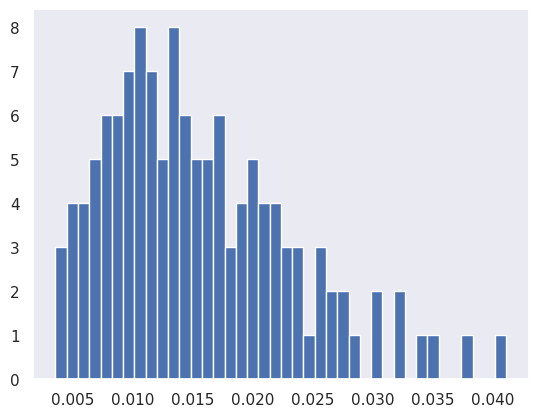

In [25]:
bandwidths = named_params[1][1].detach().cpu().numpy()
plt.hist(bandwidths.flatten(), bins=40)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1., 115.,
          6.,   2.,   0.,   0.,   0.,   0.,   1.]),
 array([-8.29880937e-14, -8.04610352e-14, -7.79339700e-14, -7.54069116e-14,
        -7.28798464e-14, -7.03527880e-14, -6.78257296e-14, -6.52986644e-14,
        -6.27716059e-14, -6.02445407e-14, -5.77174823e-14, -5.51904205e-14,
        -5.26633587e-14, -5.01363003e-14, -4.76092385e-14, -4.50821767e-14,
        -4.25551148e-14, -4.00280530e-14, -3.75009946e-14, -3.49739328e-14,
        -3.24468710e-14, -2.99198092e-14, -2.73927491e-14, -2.48656872e-14,
        -2.23386271e-14, -1.98115653e-14, -1.72845035e-14, -1.47574434e-14,
        -1.22303816e-14, -9.70332061e-15, -7.17625964e-15, -4.64919868e-15,
        -2.12213729e-15,  4.04923756e-16,  2.93198485e-15,  5.45904603e-15,
         7.98610699e-15,  1.05131680e-14, 

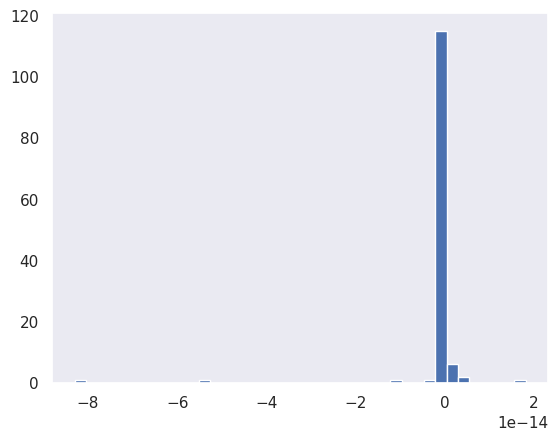

In [26]:
bandwidths = named_params[1][1].grad.detach().cpu().numpy()
plt.hist(bandwidths.flatten(), bins=40)

/tmp/ipykernel_3581021/1421197636.py:1: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(bandwidths.flatten()), bins=40)


(array([3., 1., 0., 4., 0., 1., 3., 2., 1., 0., 0., 2., 3., 2., 6., 4., 6.,
        5., 3., 2., 2., 4., 6., 2., 1., 2., 1., 1., 1., 1., 0., 2., 1., 0.,
        1., 1., 0., 0., 0., 1.]),
 array([-43.80394745, -43.49992752, -43.19590759, -42.89189148,
        -42.58787155, -42.28385162, -41.9798317 , -41.67581177,
        -41.37179184, -41.06777573, -40.7637558 , -40.45973587,
        -40.15571594, -39.85169601, -39.54767609, -39.24365997,
        -38.93964005, -38.63562012, -38.33160019, -38.02758026,
        -37.72356415, -37.41954422, -37.11552429, -36.81150436,
        -36.50748444, -36.20346451, -35.89944839, -35.59542847,
        -35.29140854, -34.98738861, -34.68336868, -34.37934875,
        -34.07533264, -33.77131271, -33.46729279, -33.16327286,
        -32.85925293, -32.555233  , -32.25121689, -31.94719696,
        -31.64317703]),
 <BarContainer object of 40 artists>)

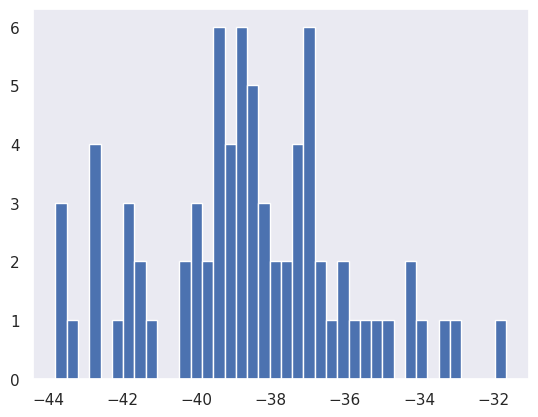

In [27]:
plt.hist(np.log(bandwidths.flatten()), bins=40)

(array([ 1.,  0.,  1.,  1.,  0.,  1.,  2.,  1.,  0.,  1.,  1.,  0.,  1.,
         4.,  5.,  4., 10., 64., 22., 19., 14., 10.,  9., 15., 17., 13.,
        13., 10.,  3.,  2.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  5.,  1.,
         1.]),
 array([-1.87018728, -1.76379108, -1.65739489, -1.55099869, -1.44460249,
        -1.33820629, -1.23180997, -1.12541378, -1.01901758, -0.91262138,
        -0.80622518, -0.69982898, -0.59343278, -0.48703656, -0.38064033,
        -0.27424413, -0.16784792, -0.06145171,  0.0449445 ,  0.15134071,
         0.25773692,  0.36413312,  0.47052935,  0.57692558,  0.68332177,
         0.78971797,  0.89611417,  1.00251043,  1.10890663,  1.21530282,
         1.32169902,  1.42809522,  1.53449142,  1.64088762,  1.74728382,
         1.85368013,  1.96007633,  2.06647253,  2.17286873,  2.27926493,
         2.38566113]),
 <BarContainer object of 40 artists>)

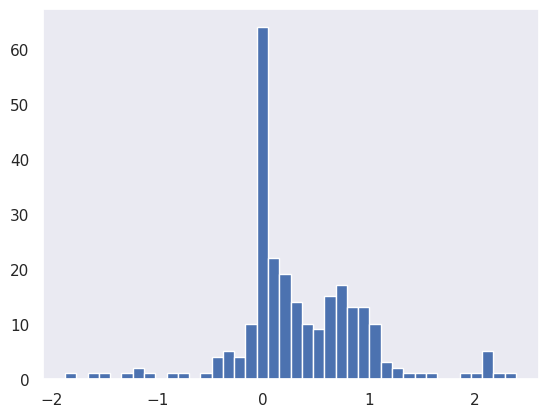

In [28]:
window_params = named_params[2][1].detach().cpu().numpy()
plt.hist(window_params.flatten(), bins=40)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   1.,
          1.,   1.,   3.,   7.,  12.,   2.,   5.,  25., 139.,  17.,  12.,
         19.,   2.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   1.,
          1.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([-0.05728922, -0.05432624, -0.05136325, -0.04840026, -0.04543728,
        -0.04247429, -0.0395113 , -0.03654832, -0.03358533, -0.03062235,
        -0.02765936, -0.02469637, -0.02173339, -0.0187704 , -0.01580741,
        -0.01284443, -0.00988144, -0.00691846, -0.00395547, -0.00099248,
         0.0019705 ,  0.00493349,  0.00789648,  0.01085946,  0.01382245,
         0.01678544,  0.01974842,  0.02271141,  0.0256744 ,  0.02863738,
         0.03160037,  0.03456336,  0.03752634,  0.04048933,  0.04345231,
         0.0464153 ,  0.04937829,  0.05234127,  0.05530426,  0.05826724,
         0.06123023]),
 <BarContainer object of 40 artists>)

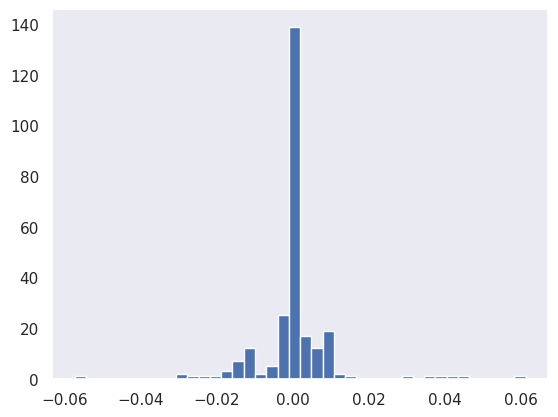

In [29]:
window_params = named_params[2][1].grad.detach().cpu().numpy()
plt.hist(window_params.flatten(), bins=40)

/tmp/ipykernel_3581021/569063560.py:1: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(window_params.flatten()), bins=40)


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  4.,  6.,  8.,  5.,  4.,  7.,  6.,  2.,  5.,  4.,  0.,
         2.,  3.,  2.,  4.,  4.,  4., 10.,  9., 20.,  5.,  1.,  0.,  3.,
         3.]),
 array([-17.32868004, -16.96529007, -16.60190201, -16.23851204,
        -15.87512302, -15.51173401, -15.14834499, -14.78495598,
        -14.42156696, -14.05817795, -13.69478893, -13.33139896,
        -12.96800995, -12.60462093, -12.24123192, -11.8778429 ,
        -11.51445389, -11.15106487, -10.78767586, -10.42428589,
        -10.06089687,  -9.69750786,  -9.33411884,  -8.97072983,
         -8.60734081,  -8.2439518 ,  -7.88056231,  -7.51717329,
         -7.1537838 ,  -6.79039478,  -6.42700577,  -6.06361628,
         -5.70022726,  -5.33683825,  -4.97344923,  -4.61005974,
         -4.24667072,  -3.88328171,  -3.51989245,  -3.15650344,
         -2.79311419]),
 <BarContainer object of 40 artists>)

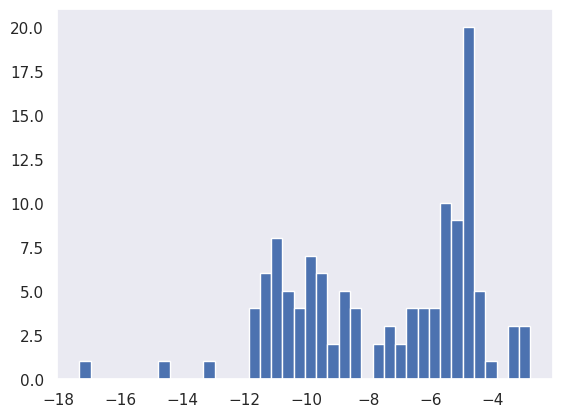

In [30]:
plt.hist(np.log(window_params.flatten()), bins=40)

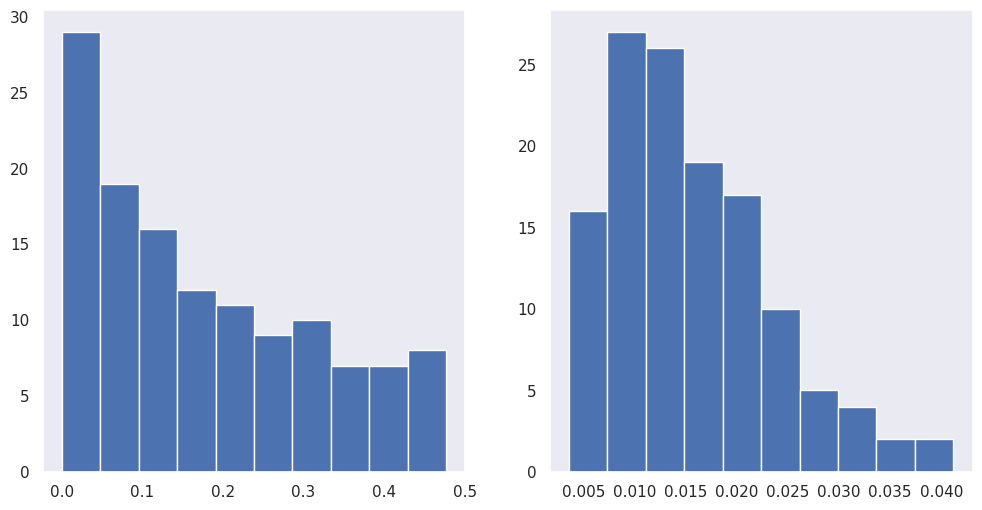

In [31]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_bands()

Time domain: Filters' shapes vary by frequency bins


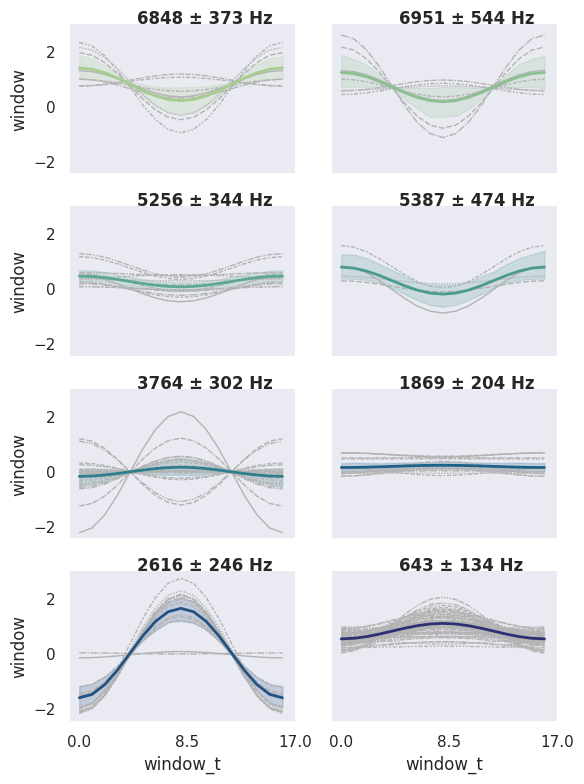

In [32]:
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


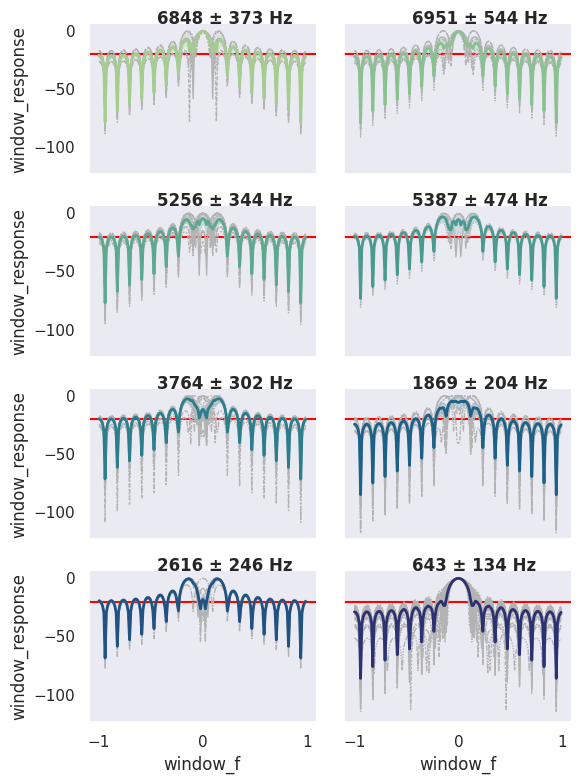

In [33]:
filtviz.visualize_filters(filter_domain='freq')

In [34]:
layer2 = model.fe_blocks.blocks[1].block.layer
visualize_model.print_parameters(layer2)

('lowcut_bands', Parameter containing:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0162, 0.0162, 0.0162,  ..., 0.0162, 0.0162, 0.0162],
        [0.0384, 0.0384, 0.0384,  ..., 0.0384, 0.0384, 0.0384],
        ...,
        [0.2594, 0.2594, 0.2594,  ..., 0.2594, 0.2594, 0.2594],
        [0.3309, 0.3309, 0.3309,  ..., 0.3309, 0.3309, 0.3309],
        [0.4108, 0.4108, 0.4108,  ..., 0.4108, 0.4108, 0.4108]],
       device='cuda:0', requires_grad=True))
('bandwidths', Parameter containing:
tensor([[0.0162, 0.0162, 0.0162,  ..., 0.0162, 0.0162, 0.0162],
        [0.0222, 0.0222, 0.0222,  ..., 0.0222, 0.0222, 0.0222],
        [0.0304, 0.0304, 0.0304,  ..., 0.0304, 0.0304, 0.0304],
        ...,
        [0.0715, 0.0715, 0.0715,  ..., 0.0715, 0.0715, 0.0715],
        [0.0799, 0.0799, 0.0799,  ..., 0.0799, 0.0799, 0.0799],
        [0.0892, 0.0892, 0.0892,  ..., 0.0892, 0.0892, 0.0892]],
       device='cuda:0', requires_grad=True))
('window_params', Parameter containing

(array([512., 128., 128., 384.,   0., 128., 256.,   0., 256.,   0., 128.,
        128.,   0., 256.,   0.,   0., 256.,   0.,   0., 256.,   0.,   0.,
        128., 128.,   0., 128.,   0., 128.,   0., 128.,   0.,   0., 128.,
          0., 128.,   0., 128.,   0., 128., 128.]),
 array([0.        , 0.0102691 , 0.02053821, 0.03080731, 0.04107642,
        0.05134552, 0.06161463, 0.07188373, 0.08215284, 0.09242194,
        0.10269105, 0.11296015, 0.12322926, 0.13349836, 0.14376746,
        0.15403657, 0.16430567, 0.17457478, 0.18484388, 0.19511299,
        0.20538209, 0.2156512 , 0.2259203 , 0.23618941, 0.24645852,
        0.25672761, 0.26699671, 0.27726582, 0.28753492, 0.29780403,
        0.30807313, 0.31834224, 0.32861134, 0.33888045, 0.34914955,
        0.35941866, 0.36968777, 0.37995687, 0.39022598, 0.40049508,
        0.41076419]),
 <BarContainer object of 40 artists>)

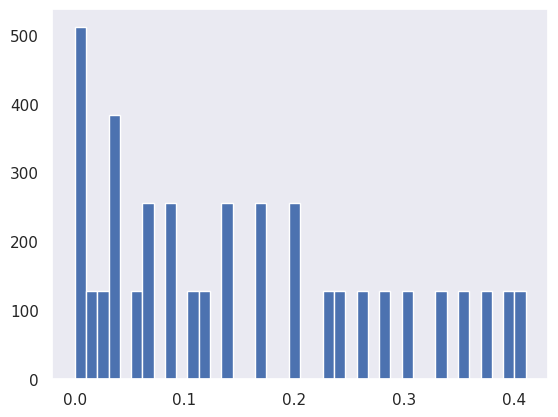

In [39]:
named_params2 = [p for p in layer2.named_parameters()]
lowbands2 = named_params2[0][1].detach().cpu().numpy()
plt.hist(lowbands2.flatten(), bins=40)

/tmp/ipykernel_3581021/2621672499.py:1: RuntimeWarning: divide by zero encountered in log
  grad_log = np.log(named_params2[0][1].grad.detach().cpu().numpy().flatten())
/tmp/ipykernel_3581021/2621672499.py:1: RuntimeWarning: invalid value encountered in log
  grad_log = np.log(named_params2[0][1].grad.detach().cpu().numpy().flatten())


(array([  2.,   0.,   1.,   3.,   2.,   5.,   8.,  12.,  20.,  11.,  23.,
         26.,  36.,  31.,  28.,  30.,  38.,  37.,  46.,  51.,  82., 115.,
         67.,  58.,  44.,  43.,  56.,  76.,  82.,  83.,  94., 100.,  79.,
         50.,  60.,  27.,  15.,   9.,   4.,   6.]),
 array([-51.85635757, -51.46914673, -51.08193588, -50.69472504,
        -50.30751419, -49.92030334, -49.5330925 , -49.14588547,
        -48.75867462, -48.37146378, -47.98425293, -47.59704208,
        -47.20983124, -46.82262039, -46.43540955, -46.0481987 ,
        -45.66098785, -45.27377701, -44.88656616, -44.49935532,
        -44.11214447, -43.72493744, -43.33772659, -42.95051575,
        -42.5633049 , -42.17609406, -41.78888321, -41.40167236,
        -41.01446152, -40.62725067, -40.24003983, -39.85282898,
        -39.46561813, -39.07840729, -38.69120026, -38.30398941,
        -37.91677856, -37.52956772, -37.14235687, -36.75514603,
        -36.36793518]),
 <BarContainer object of 40 artists>)

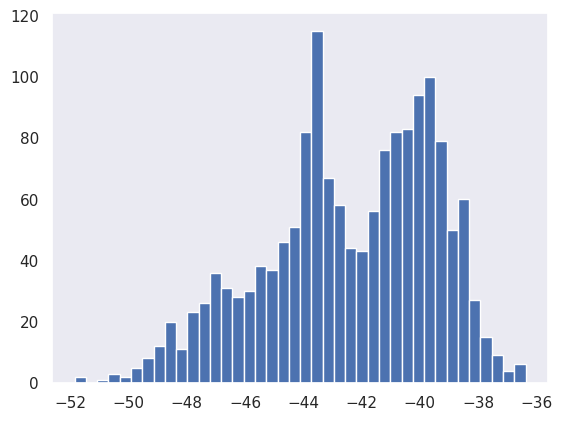

In [40]:
grad_log = np.log(named_params2[0][1].grad.detach().cpu().numpy().flatten())
grad_log = grad_log[grad_log > float('-inf')]
plt.hist(grad_log, bins=40)

(array([128., 128., 128.,   0., 384.,   0., 256., 256., 128., 256., 128.,
        128., 256., 128., 256.,   0., 128., 128., 256., 128.,   0.,   0.,
        256.,   0.,   0., 128.,   0., 256.,   0.,   0.,   0.,   0.,   0.,
        128.,   0.,   0.,   0.,   0.,   0., 128.]),
 array([0.01619883, 0.01946704, 0.02273525, 0.02600346, 0.02927167,
        0.03253987, 0.03580808, 0.03907629, 0.0423445 , 0.04561271,
        0.04888092, 0.05214913, 0.05541734, 0.05868555, 0.06195376,
        0.06522197, 0.06849018, 0.07175838, 0.07502659, 0.0782948 ,
        0.08156301, 0.08483122, 0.08809943, 0.09136764, 0.09463584,
        0.09790406, 0.10117227, 0.10444047, 0.10770869, 0.11097689,
        0.1142451 , 0.11751331, 0.12078152, 0.12404973, 0.12731794,
        0.13058615, 0.13385436, 0.13712257, 0.14039077, 0.14365898,
        0.14692719]),
 <BarContainer object of 40 artists>)

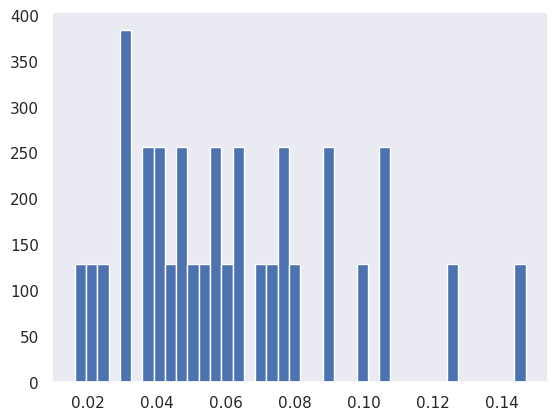

In [42]:
bandwidths2 = named_params2[1][1].detach().cpu().numpy()
plt.hist(bandwidths2.flatten(), bins=40)

/tmp/ipykernel_3581021/4138814936.py:1: RuntimeWarning: invalid value encountered in log
  grad_log = np.log(named_params2[1][1].grad.detach().cpu().numpy().flatten())


(array([  3.,   2.,   4.,   1.,   4.,   6.,  14.,  10.,  10.,  15.,  24.,
         28.,  40.,  36.,  45.,  43.,  56.,  56.,  84.,  75.,  88.,  91.,
        133., 136., 114.,  71.,  72.,  61.,  70.,  54.,  63.,  64.,  72.,
         77.,  42.,  34.,  35.,  20.,  22.,  21.]),
 array([-53.76673126, -53.37985992, -52.99298859, -52.60612106,
        -52.21924973, -51.83237839, -51.44551086, -51.05863953,
        -50.67176819, -50.28489685, -49.89802551, -49.51115799,
        -49.12428665, -48.73741531, -48.35054779, -47.96367645,
        -47.57680511, -47.18993378, -46.80306244, -46.41619492,
        -46.02932358, -45.64245224, -45.25558472, -44.86871338,
        -44.48184204, -44.0949707 , -43.70809937, -43.32123184,
        -42.9343605 , -42.54748917, -42.16062164, -41.77375031,
        -41.38687897, -41.00000763, -40.61313629, -40.22626877,
        -39.83939743, -39.45252609, -39.06565857, -38.67878723,
        -38.29191589]),
 <BarContainer object of 40 artists>)

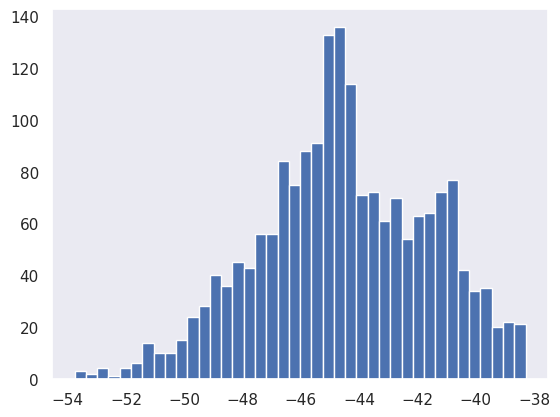

In [43]:
grad_log = np.log(named_params2[1][1].grad.detach().cpu().numpy().flatten())
grad_log = grad_log[grad_log > float('-inf')]
plt.hist(grad_log, bins=40)

(array([3.000e+00, 5.000e+00, 3.000e+00, 4.000e+00, 1.000e+01, 1.100e+01,
        3.200e+01, 6.900e+01, 1.140e+02, 1.760e+02, 2.640e+02, 3.380e+02,
        4.570e+02, 6.920e+02, 9.960e+02, 1.487e+03, 2.631e+03, 4.222e+03,
        4.470e+03, 3.593e+03, 3.343e+03, 3.400e+03, 3.003e+03, 2.097e+03,
        1.637e+03, 1.208e+03, 8.440e+02, 4.700e+02, 3.300e+02, 2.570e+02,
        1.830e+02, 1.510e+02, 1.340e+02, 1.230e+02, 6.300e+01, 3.000e+01,
        5.000e+00, 5.000e+00, 1.000e+00, 3.000e+00]),
 array([-1.77460814, -1.65959871, -1.54458928, -1.42957985, -1.31457043,
        -1.19956112, -1.08455169, -0.96954221, -0.85453284, -0.73952341,
        -0.62451398, -0.50950456, -0.39449516, -0.27948573, -0.16447632,
        -0.04946691,  0.0655425 ,  0.18055192,  0.29556134,  0.41057074,
         0.52558017,  0.64058959,  0.75559902,  0.87060839,  0.98561782,
         1.10062718,  1.21563661,  1.33064604,  1.44565547,  1.56066489,
         1.67567432,  1.79068375,  1.90569317,  2.0207026 ,  2.1

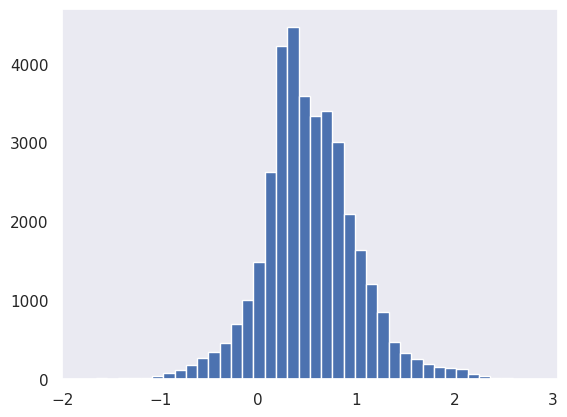

In [45]:
winparams2 = named_params2[2][1].detach().cpu().numpy()
plt.hist(winparams2.flatten(), bins=40)

(array([6.0000e+00, 1.7000e+01, 2.0000e+01, 1.0000e+01, 1.1000e+01,
        9.0000e+00, 4.6000e+01, 1.1700e+02, 3.5839e+04, 6.1700e+02,
        8.8000e+01, 1.0000e+00, 2.0000e+00, 3.0000e+00, 2.0000e+00,
        0.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 3.0000e+00,
        1.0000e+00, 4.0000e+00, 3.0000e+00, 3.0000e+00, 3.0000e+00,
        3.0000e+00, 2.0000e+00, 6.0000e+00, 2.0000e+00, 0.0000e+00,
        4.0000e+00, 7.0000e+00, 1.0000e+01, 5.0000e+00, 7.0000e+00,
        2.0000e+00, 4.0000e+00, 0.0000e+00, 3.0000e+00, 1.0000e+00]),
 array([-0.01235688, -0.01095286, -0.00954883, -0.0081448 , -0.00674078,
        -0.00533675, -0.00393273, -0.0025287 , -0.00112468,  0.00027935,
         0.00168338,  0.0030874 ,  0.00449143,  0.00589545,  0.00729948,
         0.0087035 ,  0.01010753,  0.01151156,  0.01291558,  0.01431961,
         0.01572363,  0.01712766,  0.01853168,  0.01993571,  0.02133974,
         0.02274376,  0.02414779,  0.02555181,  0.02695584,  0.02835986,
         0.02976

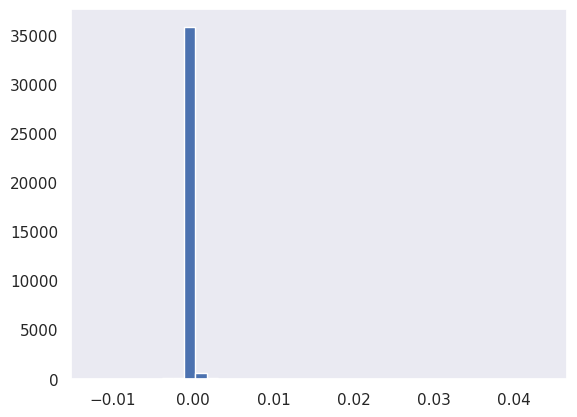

In [46]:
winparams2_grad = named_params2[2][1].grad.detach().cpu().numpy()
plt.hist(winparams2_grad.flatten(), bins=40)

/tmp/ipykernel_3581021/2626591213.py:1: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(winparams2_grad.flatten()), bins=40)


(array([1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 6.000e+00,
        1.100e+01, 2.300e+01, 2.600e+01, 5.300e+01, 9.000e+01, 1.340e+02,
        1.800e+02, 2.840e+02, 3.950e+02, 5.270e+02, 6.570e+02, 8.050e+02,
        8.860e+02, 1.142e+03, 1.247e+03, 1.428e+03, 1.495e+03, 1.502e+03,
        1.467e+03, 1.237e+03, 1.127e+03, 1.152e+03, 8.190e+02, 8.290e+02,
        3.390e+02, 2.290e+02, 1.250e+02, 9.800e+01, 4.900e+01, 2.000e+00,
        6.000e+00, 5.000e+00, 2.200e+01, 4.900e+01]),
 array([-23.92479515, -23.40487671, -22.88495636, -22.36503792,
        -21.84511757, -21.32519913, -20.80528069, -20.28536034,
        -19.76544189, -19.24552155, -18.7256031 , -18.20568466,
        -17.68576431, -17.16584587, -16.64592552, -16.12600708,
        -15.60608768, -15.08616829, -14.56624889, -14.04633045,
        -13.52641106, -13.00649166, -12.48657227, -11.96665287,
        -11.44673443, -10.92681503, -10.40689564,  -9.88697624,
         -9.36705685,  -8.8471384 ,  -8.32721901,  -7.

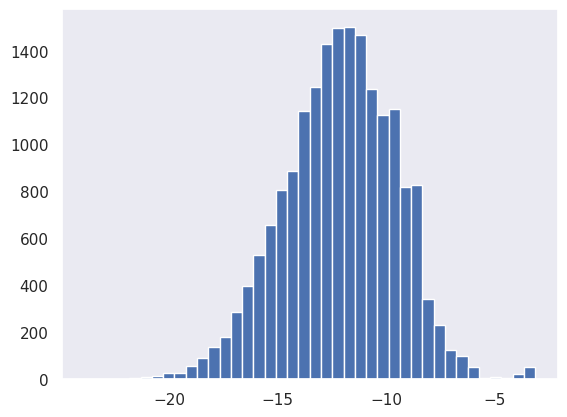

In [47]:
plt.hist(np.log(winparams2_grad.flatten()), bins=40)

downsample_factor: 8 => new_sample_rate: 2000


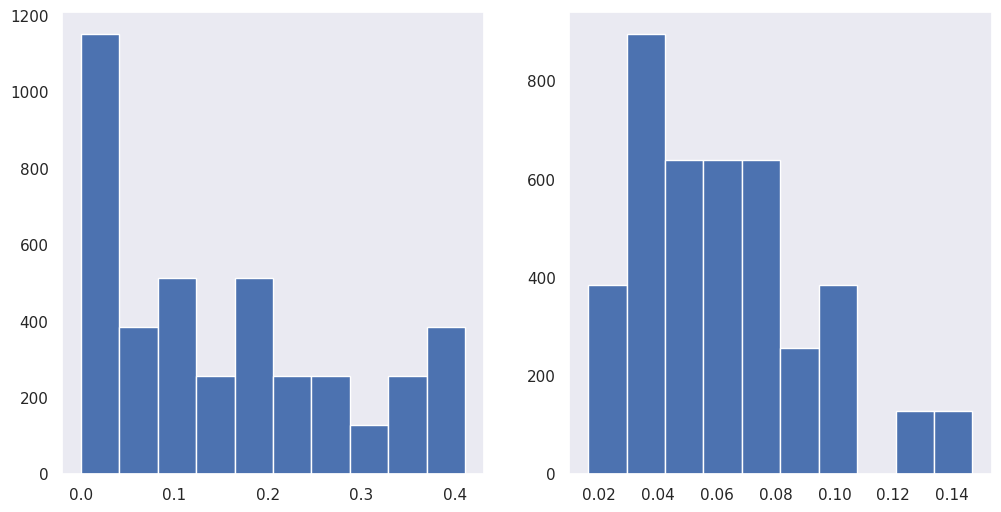

In [35]:
downsample_factor = model.fe_blocks.blocks[0].stride
new_sample_rate = sr // downsample_factor
print(f'downsample_factor: {downsample_factor} => new_sample_rate: {new_sample_rate}')

filtviz2 = visualize_model.FilterVisualizer(
    lowcut_bands = layer2.lowcut_bands, 
    bandwidths = layer2.bandwidths,
    window_params = layer2.window_params, 
    window_length = 64,
    sample_rate = new_sample_rate
)
filtviz2.visualize_bands()

Time domain: Filters' shapes vary by frequency bins


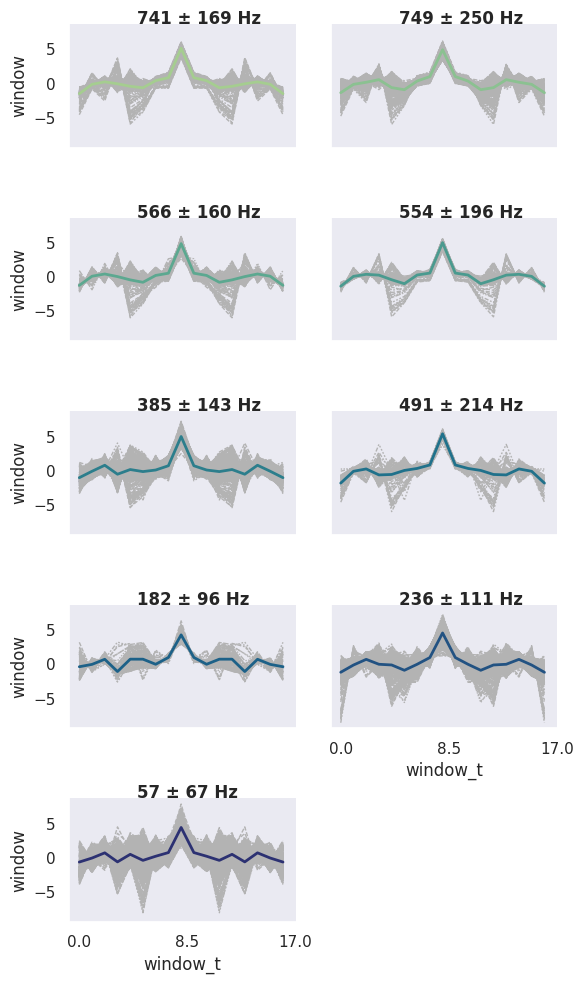

In [36]:
filtviz2.visualize_filters('time')

Frequency domain: Filters' shapes vary by frequency bins


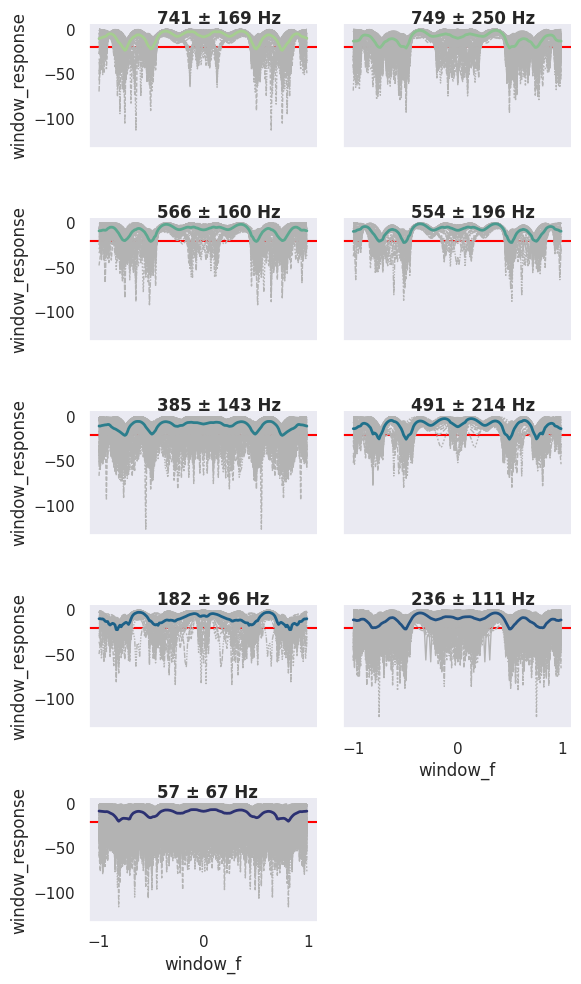

In [37]:
filtviz2.visualize_filters('freq')

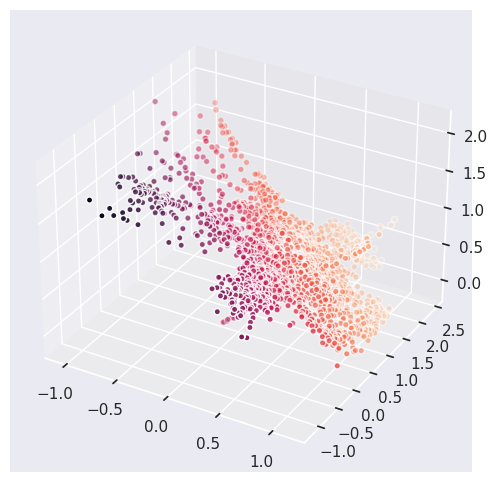

In [38]:
filtviz2.visualize_window_params()

In [48]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.05,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)

log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                                                                                                                           | 0.00205761316872428/50 [00:01<12:14:19, 881.22s/it]

Train Epoch: 11 [0/11751 (0%)]	Loss: 0.106803
Mem before-during-after: 32566784 4375915008 33809920


  0%|▎                                                                                                                                                                           | 0.08436213991769549/50 [00:53<9:28:00, 682.76s/it]

Train Epoch: 11 [1280/11751 (11%)]	Loss: 0.061939
Mem before-during-after: 33809920 4377241088 33809920


  0%|▌                                                                                                                                                                           | 0.16666666666666657/50 [01:46<8:58:17, 648.10s/it]

Train Epoch: 11 [2560/11751 (22%)]	Loss: 0.417138
Mem before-during-after: 33809920 4377241088 33809920


  0%|▊                                                                                                                                                                            | 0.2489711934156374/50 [02:40<9:15:04, 669.43s/it]

Train Epoch: 11 [3840/11751 (33%)]	Loss: 0.364522
Mem before-during-after: 33809920 4377241088 33809920


  1%|█▏                                                                                                                                                                           | 0.3312757201646082/50 [03:31<7:55:54, 574.90s/it]

Train Epoch: 11 [5120/11751 (44%)]	Loss: 0.207412
Mem before-during-after: 33809920 4377241088 33809920


  1%|█▍                                                                                                                                                                          | 0.41358024691357903/50 [04:21<8:34:15, 622.26s/it]

Train Epoch: 11 [6400/11751 (54%)]	Loss: 0.325867
Mem before-during-after: 33809920 4377241088 33809920


  1%|█▋                                                                                                                                                                          | 0.49588477366254985/50 [05:14<8:57:35, 651.57s/it]

Train Epoch: 11 [7680/11751 (65%)]	Loss: 0.117371
Mem before-during-after: 33809920 4377241088 33809920


  1%|██                                                                                                                                                                           | 0.5781893004115227/50 [06:03<8:30:14, 619.45s/it]

Train Epoch: 11 [8960/11751 (76%)]	Loss: 0.188976
Mem before-during-after: 33809920 4377241088 33809920


  1%|██▎                                                                                                                                                                          | 0.6604938271604958/50 [06:57<7:49:47, 571.30s/it]

Train Epoch: 11 [10240/11751 (87%)]	Loss: 0.415809
Mem before-during-after: 33809920 4377241088 33809920


  1%|██▌                                                                                                                                                                          | 0.7427983539094688/50 [07:50<9:02:31, 660.84s/it]

Train Epoch: 11 [11520/11751 (98%)]	Loss: 0.323975
Mem before-during-after: 33809920 4377241088 33809920


  2%|███▍                                                                                                                                                                         | 1.0000000000000095/50 [09:54<6:13:33, 457.42s/it]


Test Epoch: 11	Accuracy: 3161/3808 (83%)



  2%|███▍                                                                                                                                                                         | 1.0020576131687338/50 [09:55<7:12:55, 530.13s/it]

Train Epoch: 12 [0/11751 (0%)]	Loss: 0.116064
Mem before-during-after: 33802752 4377167360 33809920


  2%|███▊                                                                                                                                                                         | 1.0843621399177024/50 [10:47<8:59:53, 662.24s/it]

Train Epoch: 12 [1280/11751 (11%)]	Loss: 0.065884
Mem before-during-after: 33826304 4376684544 33826304


  2%|████                                                                                                                                                                          | 1.166666666666671/50 [11:37<7:45:38, 572.12s/it]

Train Epoch: 12 [2560/11751 (22%)]	Loss: 0.245825
Mem before-during-after: 33826304 4376684544 33826304


  2%|████▎                                                                                                                                                                        | 1.2489711934156396/50 [12:33<8:57:27, 661.48s/it]

Train Epoch: 12 [3840/11751 (33%)]	Loss: 0.475569
Mem before-during-after: 33826304 4376684544 33826304


  3%|████▌                                                                                                                                                                        | 1.3312757201646082/50 [13:26<7:45:57, 574.45s/it]

Train Epoch: 12 [5120/11751 (44%)]	Loss: 0.253832
Mem before-during-after: 33826304 4376684544 33826304


  3%|████▉                                                                                                                                                                        | 1.4135802469135768/50 [14:21<9:08:20, 677.16s/it]

Train Epoch: 12 [6400/11751 (54%)]	Loss: 0.343721
Mem before-during-after: 33826304 4376684544 33826304


  3%|█████▏                                                                                                                                                                       | 1.4958847736625454/50 [15:12<8:08:42, 604.53s/it]

Train Epoch: 12 [7680/11751 (65%)]	Loss: 0.107585
Mem before-during-after: 33826304 4376684544 33826304


  3%|█████▍                                                                                                                                                                        | 1.578189300411514/50 [16:02<8:34:15, 637.23s/it]

Train Epoch: 12 [8960/11751 (76%)]	Loss: 0.168509
Mem before-during-after: 33826304 4376684544 33826304


  3%|█████▋                                                                                                                                                                       | 1.6604938271604825/50 [16:51<8:30:42, 633.90s/it]

Train Epoch: 12 [10240/11751 (87%)]	Loss: 0.412601
Mem before-during-after: 33826304 4376684544 33826304


  3%|██████                                                                                                                                                                       | 1.7427983539094511/50 [17:43<8:53:38, 663.50s/it]

Train Epoch: 12 [11520/11751 (98%)]	Loss: 0.285290
Mem before-during-after: 33826304 4376684544 33826304


  4%|██████▉                                                                                                                                                                       | 1.999999999999978/50 [19:47<6:09:50, 462.31s/it]


Test Epoch: 12	Accuracy: 3171/3808 (83%)



  4%|██████▉                                                                                                                                                                      | 2.0020576131687022/50 [19:49<7:10:45, 538.48s/it]

Train Epoch: 13 [0/11751 (0%)]	Loss: 0.079051
Mem before-during-after: 33802752 4377232896 34744320


  4%|███████▏                                                                                                                                                                     | 2.0843621399176797/50 [20:43<8:49:38, 663.22s/it]

Train Epoch: 13 [1280/11751 (11%)]	Loss: 0.067736
Mem before-during-after: 33826304 4377053184 33826304


  4%|███████▌                                                                                                                                                                      | 2.166666666666657/50 [21:36<9:20:55, 703.60s/it]

Train Epoch: 13 [2560/11751 (22%)]	Loss: 0.228939
Mem before-during-after: 33826304 4377053184 33826304


  4%|███████▊                                                                                                                                                                     | 2.2489711934156347/50 [22:20<3:51:01, 290.29s/it]

Train Epoch: 13 [3840/11751 (33%)]	Loss: 0.544240
Mem before-during-after: 33826304 4377053184 33826304


  5%|████████                                                                                                                                                                      | 2.331275720164612/50 [22:42<3:30:21, 264.78s/it]

Train Epoch: 13 [5120/11751 (44%)]	Loss: 0.256892
Mem before-during-after: 33826304 4377053184 33826304


  5%|████████▎                                                                                                                                                                    | 2.4135802469135896/50 [23:04<3:33:45, 269.52s/it]

Train Epoch: 13 [6400/11751 (54%)]	Loss: 0.350284
Mem before-during-after: 33826304 4377053184 33826304


  5%|████████▋                                                                                                                                                                     | 2.495884773662567/50 [23:26<3:40:24, 278.39s/it]

Train Epoch: 13 [7680/11751 (65%)]	Loss: 0.100555
Mem before-during-after: 33826304 4377053184 33826304


  5%|████████▉                                                                                                                                                                    | 2.5781893004115446/50 [23:48<3:31:07, 267.12s/it]

Train Epoch: 13 [8960/11751 (76%)]	Loss: 0.156846
Mem before-during-after: 33826304 4377053184 33826304


  5%|█████████▎                                                                                                                                                                    | 2.660493827160522/50 [24:09<3:31:44, 268.36s/it]

Train Epoch: 13 [10240/11751 (87%)]	Loss: 0.402918
Mem before-during-after: 33826304 4377053184 33826304


  5%|█████████▍                                                                                                                                                                   | 2.7427983539094996/50 [24:31<3:30:10, 266.85s/it]

Train Epoch: 13 [11520/11751 (98%)]	Loss: 0.285125
Mem before-during-after: 33826304 4377053184 33826304


  6%|██████████▍                                                                                                                                                                   | 3.000000000000054/50 [25:05<1:34:19, 120.42s/it]


Test Epoch: 13	Accuracy: 3174/3808 (83%)



  6%|██████████▍                                                                                                                                                                  | 3.0020576131687786/50 [25:05<2:06:18, 161.26s/it]

Train Epoch: 14 [0/11751 (0%)]	Loss: 0.071936
Mem before-during-after: 33802752 4377232896 34744320


  6%|██████████▋                                                                                                                                                                   | 3.084362139917756/50 [25:27<3:28:55, 267.20s/it]

Train Epoch: 14 [1280/11751 (11%)]	Loss: 0.068634
Mem before-during-after: 33826304 4377053184 33826304


  6%|██████████▉                                                                                                                                                                  | 3.1666666666667336/50 [25:48<3:25:49, 263.68s/it]

Train Epoch: 14 [2560/11751 (22%)]	Loss: 0.221162
Mem before-during-after: 33826304 4377053184 33826304


  6%|███████████▎                                                                                                                                                                  | 3.248971193415711/50 [26:10<3:31:33, 271.51s/it]

Train Epoch: 14 [3840/11751 (33%)]	Loss: 0.557454
Mem before-during-after: 33826304 4377053184 33826304


  7%|███████████▌                                                                                                                                                                 | 3.3312757201646885/50 [26:32<4:22:46, 337.84s/it]

Train Epoch: 14 [5120/11751 (44%)]	Loss: 0.255512
Mem before-during-after: 33826304 4377053184 33826304


  7%|███████████▉                                                                                                                                                                  | 3.413580246913666/50 [26:54<3:30:16, 270.81s/it]

Train Epoch: 14 [6400/11751 (54%)]	Loss: 0.342398
Mem before-during-after: 33826304 4377053184 33826304


  7%|████████████                                                                                                                                                                 | 3.4958847736626435/50 [27:16<3:31:28, 272.85s/it]

Train Epoch: 14 [7680/11751 (65%)]	Loss: 0.093451
Mem before-during-after: 33826304 4377053184 33826304


  7%|████████████▍                                                                                                                                                                 | 3.578189300411621/50 [27:38<3:27:55, 268.75s/it]

Train Epoch: 14 [8960/11751 (76%)]	Loss: 0.144032
Mem before-during-after: 33826304 4377053184 33826304


  7%|████████████▋                                                                                                                                                                | 3.6604938271605985/50 [28:00<3:36:35, 280.44s/it]

Train Epoch: 14 [10240/11751 (87%)]	Loss: 0.391385
Mem before-during-after: 33826304 4377053184 33826304


  7%|█████████████                                                                                                                                                                 | 3.742798353909576/50 [28:22<3:28:27, 270.39s/it]

Train Epoch: 14 [11520/11751 (98%)]	Loss: 0.279292
Mem before-during-after: 33826304 4377053184 33826304


  8%|█████████████▉                                                                                                                                                                | 4.000000000000131/50 [28:55<1:34:34, 123.35s/it]


Test Epoch: 14	Accuracy: 3174/3808 (83%)



  8%|█████████████▉                                                                                                                                                                | 4.002057613168855/50 [28:56<2:02:12, 159.41s/it]

Train Epoch: 15 [0/11751 (0%)]	Loss: 0.058889
Mem before-during-after: 33802752 4377232896 34744320


  8%|██████████████▏                                                                                                                                                              | 4.0843621399178325/50 [29:17<3:21:57, 263.91s/it]

Train Epoch: 15 [1280/11751 (11%)]	Loss: 0.074370
Mem before-during-after: 33826304 4377053184 33826304


  8%|██████████████▌                                                                                                                                                                | 4.16666666666681/50 [29:39<3:24:07, 267.23s/it]

Train Epoch: 15 [2560/11751 (22%)]	Loss: 0.236976
Mem before-during-after: 33826304 4377053184 33826304


  8%|██████████████▊                                                                                                                                                               | 4.248971193415787/50 [30:01<3:26:03, 270.24s/it]

Train Epoch: 15 [3840/11751 (33%)]	Loss: 0.513106
Mem before-during-after: 33826304 4377053184 33826304


  9%|███████████████                                                                                                                                                               | 4.331275720164765/50 [30:22<3:23:25, 267.25s/it]

Train Epoch: 15 [5120/11751 (44%)]	Loss: 0.241424
Mem before-during-after: 33826304 4377053184 33826304


  9%|███████████████▎                                                                                                                                                              | 4.413580246913742/50 [30:44<3:23:06, 267.34s/it]

Train Epoch: 15 [6400/11751 (54%)]	Loss: 0.330800
Mem before-during-after: 33826304 4377053184 33826304


  9%|███████████████▋                                                                                                                                                               | 4.49588477366272/50 [31:06<3:23:33, 268.40s/it]

Train Epoch: 15 [7680/11751 (65%)]	Loss: 0.108937
Mem before-during-after: 33826304 4377053184 33826304


  9%|███████████████▉                                                                                                                                                              | 4.578189300411697/50 [31:27<3:19:52, 264.02s/it]

Train Epoch: 15 [8960/11751 (76%)]	Loss: 0.142755
Mem before-during-after: 33826304 4377053184 33826304


  9%|████████████████▏                                                                                                                                                             | 4.660493827160675/50 [31:49<3:23:46, 269.66s/it]

Train Epoch: 15 [10240/11751 (87%)]	Loss: 0.396752
Mem before-during-after: 33826304 4377053184 33826304


  9%|████████████████▌                                                                                                                                                             | 4.742798353909652/50 [32:11<3:23:40, 270.01s/it]

Train Epoch: 15 [11520/11751 (98%)]	Loss: 0.263921
Mem before-during-after: 33826304 4377053184 33826304


 10%|█████████████████▍                                                                                                                                                            | 5.000000000000207/50 [32:45<1:33:53, 125.20s/it]


Test Epoch: 15	Accuracy: 3156/3808 (83%)



 10%|█████████████████▍                                                                                                                                                            | 5.002057613168931/50 [32:46<2:03:46, 165.04s/it]

Train Epoch: 16 [0/11751 (0%)]	Loss: 0.048996
Mem before-during-after: 33802752 4377232896 34744320


 10%|█████████████████▋                                                                                                                                                            | 5.084362139917909/50 [33:08<3:20:31, 267.87s/it]

Train Epoch: 16 [1280/11751 (11%)]	Loss: 0.083968
Mem before-during-after: 33826304 4377053184 33826304


 10%|█████████████████▉                                                                                                                                                            | 5.166666666666886/50 [33:29<3:22:39, 271.22s/it]

Train Epoch: 16 [2560/11751 (22%)]	Loss: 0.236089
Mem before-during-after: 33826304 4377053184 33826304


 10%|██████████████████▎                                                                                                                                                           | 5.248971193415864/50 [33:51<3:19:02, 266.86s/it]

Train Epoch: 16 [3840/11751 (33%)]	Loss: 0.509560
Mem before-during-after: 33826304 4377053184 33826304


 11%|██████████████████▌                                                                                                                                                           | 5.331275720164841/50 [34:13<3:18:43, 266.93s/it]

Train Epoch: 16 [5120/11751 (44%)]	Loss: 0.236658
Mem before-during-after: 33826304 4377053184 33826304


 11%|██████████████████▊                                                                                                                                                           | 5.413580246913819/50 [34:35<3:22:11, 272.08s/it]

Train Epoch: 16 [6400/11751 (54%)]	Loss: 0.325030
Mem before-during-after: 33826304 4377053184 33826304


 11%|███████████████████▏                                                                                                                                                          | 5.495884773662796/50 [34:57<3:24:55, 276.29s/it]

Train Epoch: 16 [7680/11751 (65%)]	Loss: 0.119049
Mem before-during-after: 33826304 4377053184 33826304


 11%|███████████████████▍                                                                                                                                                          | 5.578189300411774/50 [35:19<3:16:32, 265.48s/it]

Train Epoch: 16 [8960/11751 (76%)]	Loss: 0.151371
Mem before-during-after: 33826304 4377053184 33826304


 11%|███████████████████▋                                                                                                                                                          | 5.660493827160751/50 [35:41<3:17:55, 267.84s/it]

Train Epoch: 16 [10240/11751 (87%)]	Loss: 0.360328
Mem before-during-after: 33826304 4377053184 33826304


 11%|███████████████████▉                                                                                                                                                          | 5.742798353909729/50 [36:03<3:17:57, 268.37s/it]

Train Epoch: 16 [11520/11751 (98%)]	Loss: 0.256110
Mem before-during-after: 33826304 4377053184 33826304


 12%|████████████████████▉                                                                                                                                                         | 6.000000000000283/50 [36:36<1:30:40, 123.65s/it]


Test Epoch: 16	Accuracy: 3163/3808 (83%)



 12%|████████████████████▉                                                                                                                                                         | 6.002057613169008/50 [36:36<2:00:25, 164.23s/it]

Train Epoch: 17 [0/11751 (0%)]	Loss: 0.041030
Mem before-during-after: 33802752 4377232896 34744320


 12%|█████████████████████▏                                                                                                                                                        | 6.084362139917985/50 [36:58<3:17:06, 269.30s/it]

Train Epoch: 17 [1280/11751 (11%)]	Loss: 0.079193
Mem before-during-after: 33826304 4377053184 33826304


 12%|█████████████████████▍                                                                                                                                                        | 6.166666666666963/50 [37:20<3:21:12, 275.42s/it]

Train Epoch: 17 [2560/11751 (22%)]	Loss: 0.249974
Mem before-during-after: 33826304 4377053184 33826304


 12%|█████████████████████▊                                                                                                                                                         | 6.24897119341594/50 [37:42<3:18:25, 272.12s/it]

Train Epoch: 17 [3840/11751 (33%)]	Loss: 0.482150
Mem before-during-after: 33826304 4377053184 33826304


 13%|██████████████████████                                                                                                                                                        | 6.331275720164918/50 [38:04<3:14:57, 267.86s/it]

Train Epoch: 17 [5120/11751 (44%)]	Loss: 0.236025
Mem before-during-after: 33826304 4377053184 33826304


 13%|██████████████████████▎                                                                                                                                                       | 6.413580246913895/50 [38:26<3:15:10, 268.66s/it]

Train Epoch: 17 [6400/11751 (54%)]	Loss: 0.332382
Mem before-during-after: 33826304 4377053184 33826304


 13%|██████████████████████▌                                                                                                                                                       | 6.495884773662873/50 [38:47<3:14:05, 267.68s/it]

Train Epoch: 17 [7680/11751 (65%)]	Loss: 0.107175
Mem before-during-after: 33826304 4377053184 33826304


 13%|███████████████████████                                                                                                                                                        | 6.57818930041185/50 [39:09<3:12:18, 265.73s/it]

Train Epoch: 17 [8960/11751 (76%)]	Loss: 0.158959
Mem before-during-after: 33826304 4377053184 33826304


 13%|███████████████████████▏                                                                                                                                                      | 6.660493827160828/50 [39:30<3:17:40, 273.66s/it]

Train Epoch: 17 [10240/11751 (87%)]	Loss: 0.350782
Mem before-during-after: 33826304 4377053184 33826304


 13%|███████████████████████▍                                                                                                                                                      | 6.742798353909805/50 [39:52<3:10:55, 264.83s/it]

Train Epoch: 17 [11520/11751 (98%)]	Loss: 0.251287
Mem before-during-after: 33826304 4377053184 33826304


 14%|████████████████████████▌                                                                                                                                                      | 7.00000000000036/50 [40:26<1:28:11, 123.07s/it]


Test Epoch: 17	Accuracy: 3189/3808 (83%)



 14%|████████████████████████▎                                                                                                                                                     | 7.002057613169084/50 [40:26<1:54:24, 159.64s/it]

Train Epoch: 18 [0/11751 (0%)]	Loss: 0.040809
Mem before-during-after: 33802752 4377232896 34744320


 14%|████████████████████████▋                                                                                                                                                     | 7.084362139918062/50 [40:48<3:15:17, 273.04s/it]

Train Epoch: 18 [1280/11751 (11%)]	Loss: 0.096263
Mem before-during-after: 33826304 4377053184 33826304


 14%|████████████████████████▉                                                                                                                                                     | 7.166666666667039/50 [41:10<3:12:37, 269.81s/it]

Train Epoch: 18 [2560/11751 (22%)]	Loss: 0.273935
Mem before-during-after: 33826304 4377053184 33826304


 14%|█████████████████████████▏                                                                                                                                                    | 7.248971193416017/50 [41:32<3:15:09, 273.89s/it]

Train Epoch: 18 [3840/11751 (33%)]	Loss: 0.413930
Mem before-during-after: 33826304 4377053184 33826304


 15%|█████████████████████████▌                                                                                                                                                    | 7.331275720164994/50 [41:54<3:12:40, 270.92s/it]

Train Epoch: 18 [5120/11751 (44%)]	Loss: 0.238372
Mem before-during-after: 33826304 4377053184 33826304


 15%|█████████████████████████▋                                                                                                                                                   | 7.4135802469139715/50 [42:16<3:13:12, 272.22s/it]

Train Epoch: 18 [6400/11751 (54%)]	Loss: 0.356501
Mem before-during-after: 33826304 4377053184 33826304


 15%|██████████████████████████                                                                                                                                                    | 7.495884773662949/50 [42:39<3:14:37, 274.75s/it]

Train Epoch: 18 [7680/11751 (65%)]	Loss: 0.097039
Mem before-during-after: 33826304 4377053184 33826304


 15%|██████████████████████████▏                                                                                                                                                  | 7.5781893004119265/50 [43:01<3:21:53, 285.54s/it]

Train Epoch: 18 [8960/11751 (76%)]	Loss: 0.152910
Mem before-during-after: 33826304 4377053184 33826304


 15%|██████████████████████████▋                                                                                                                                                   | 7.660493827160904/50 [43:23<3:15:47, 277.47s/it]

Train Epoch: 18 [10240/11751 (87%)]	Loss: 0.323823
Mem before-during-after: 33826304 4377053184 33826304


 15%|██████████████████████████▊                                                                                                                                                  | 7.7427983539098815/50 [43:45<3:09:57, 269.72s/it]

Train Epoch: 18 [11520/11751 (98%)]	Loss: 0.240477
Mem before-during-after: 33826304 4377053184 33826304


 16%|███████████████████████████▊                                                                                                                                                  | 8.000000000000435/50 [44:18<1:28:18, 126.16s/it]


Test Epoch: 18	Accuracy: 3200/3808 (84%)



 16%|███████████████████████████▊                                                                                                                                                  | 8.002057613169159/50 [44:19<1:52:54, 161.32s/it]

Train Epoch: 19 [0/11751 (0%)]	Loss: 0.039529
Mem before-during-after: 33802752 4377232896 34744320


 16%|████████████████████████████▍                                                                                                                                                   | 8.0843621399181/50 [44:40<3:05:37, 265.72s/it]

Train Epoch: 19 [1280/11751 (11%)]	Loss: 0.093693
Mem before-during-after: 33826304 4377053184 33826304


 16%|████████████████████████████▍                                                                                                                                                 | 8.166666666667043/50 [45:02<3:06:53, 268.05s/it]

Train Epoch: 19 [2560/11751 (22%)]	Loss: 0.264265
Mem before-during-after: 33826304 4377053184 33826304


 16%|████████████████████████████▋                                                                                                                                                 | 8.248971193415985/50 [45:24<3:05:26, 266.50s/it]

Train Epoch: 19 [3840/11751 (33%)]	Loss: 0.408511
Mem before-during-after: 33826304 4377053184 33826304


 17%|████████████████████████████▉                                                                                                                                                 | 8.331275720164927/50 [45:45<3:12:07, 276.66s/it]

Train Epoch: 19 [5120/11751 (44%)]	Loss: 0.234445
Mem before-during-after: 33826304 4377053184 33826304


 17%|█████████████████████████████▎                                                                                                                                                | 8.413580246913869/50 [46:08<3:03:29, 264.75s/it]

Train Epoch: 19 [6400/11751 (54%)]	Loss: 0.362242
Mem before-during-after: 33826304 4377053184 33826304


 17%|█████████████████████████████▋                                                                                                                                                 | 8.49588477366281/50 [46:29<3:03:35, 265.40s/it]

Train Epoch: 19 [7680/11751 (65%)]	Loss: 0.097862
Mem before-during-after: 33826304 4377053184 33826304


 17%|█████████████████████████████▊                                                                                                                                                | 8.578189300411752/50 [46:51<3:02:17, 264.05s/it]

Train Epoch: 19 [8960/11751 (76%)]	Loss: 0.144860
Mem before-during-after: 33826304 4377053184 33826304


 17%|██████████████████████████████▏                                                                                                                                               | 8.660493827160694/50 [47:12<3:02:42, 265.18s/it]

Train Epoch: 19 [10240/11751 (87%)]	Loss: 0.301097
Mem before-during-after: 33826304 4377053184 33826304


 17%|██████████████████████████████▍                                                                                                                                               | 8.742798353909636/50 [47:34<3:03:56, 267.51s/it]

Train Epoch: 19 [11520/11751 (98%)]	Loss: 0.235072
Mem before-during-after: 33826304 4377053184 33826304


 18%|███████████████████████████████▌                                                                                                                                               | 9.00000000000008/50 [48:08<1:23:54, 122.80s/it]


Test Epoch: 19	Accuracy: 3199/3808 (84%)



 18%|███████████████████████████████▎                                                                                                                                              | 9.002057613168803/50 [48:08<1:51:02, 162.50s/it]

Train Epoch: 20 [0/11751 (0%)]	Loss: 0.033755
Mem before-during-after: 33802752 4377232896 34744320


 18%|███████████████████████████████▌                                                                                                                                              | 9.084362139917745/50 [48:30<3:02:13, 267.23s/it]

Train Epoch: 20 [1280/11751 (11%)]	Loss: 0.078598
Mem before-during-after: 33826304 4377053184 33826304


 18%|███████████████████████████████▉                                                                                                                                              | 9.166666666666687/50 [48:52<3:04:37, 271.28s/it]

Train Epoch: 20 [2560/11751 (22%)]	Loss: 0.259391
Mem before-during-after: 33826304 4377053184 33826304


 18%|████████████████████████████████▎                                                                                                                                              | 9.24897119341563/50 [49:14<3:02:34, 268.81s/it]

Train Epoch: 20 [3840/11751 (33%)]	Loss: 0.396940
Mem before-during-after: 33826304 4377053184 33826304


 19%|████████████████████████████████▍                                                                                                                                             | 9.331275720164571/50 [49:35<3:03:00, 269.99s/it]

Train Epoch: 20 [5120/11751 (44%)]	Loss: 0.233530
Mem before-during-after: 33826304 4377053184 33826304


 19%|████████████████████████████████▊                                                                                                                                             | 9.413580246913513/50 [49:57<3:00:40, 267.10s/it]

Train Epoch: 20 [6400/11751 (54%)]	Loss: 0.348909
Mem before-during-after: 33826304 4377053184 33826304


 19%|█████████████████████████████████                                                                                                                                             | 9.495884773662455/50 [50:19<3:02:17, 270.04s/it]

Train Epoch: 20 [7680/11751 (65%)]	Loss: 0.096523
Mem before-during-after: 33826304 4377053184 33826304


 19%|█████████████████████████████████▎                                                                                                                                            | 9.578189300411397/50 [50:41<3:03:55, 273.01s/it]

Train Epoch: 20 [8960/11751 (76%)]	Loss: 0.151285
Mem before-during-after: 33826304 4377053184 33826304


 19%|█████████████████████████████████▌                                                                                                                                            | 9.660493827160339/50 [51:03<3:01:26, 269.88s/it]

Train Epoch: 20 [10240/11751 (87%)]	Loss: 0.304747
Mem before-during-after: 33826304 4377053184 33826304


 19%|█████████████████████████████████▉                                                                                                                                            | 9.742798353909281/50 [51:25<3:01:54, 271.12s/it]

Train Epoch: 20 [11520/11751 (98%)]	Loss: 0.235707
Mem before-during-after: 33826304 4377053184 33826304


 20%|██████████████████████████████████▊                                                                                                                                           | 9.999999999999725/50 [51:58<1:21:18, 121.96s/it]


Test Epoch: 20	Accuracy: 3184/3808 (83%)



 20%|██████████████████████████████████▌                                                                                                                                          | 10.002057613168448/50 [51:58<1:47:29, 161.25s/it]

Train Epoch: 21 [0/11751 (0%)]	Loss: 0.032260
Mem before-during-after: 33802752 4377232896 34744320


 20%|███████████████████████████████████                                                                                                                                           | 10.08436213991739/50 [52:20<2:57:45, 267.21s/it]

Train Epoch: 21 [1280/11751 (11%)]	Loss: 0.085066
Mem before-during-after: 33826304 4377053184 33826304


 20%|███████████████████████████████████▏                                                                                                                                         | 10.166666666666332/50 [52:42<2:58:00, 268.13s/it]

Train Epoch: 21 [2560/11751 (22%)]	Loss: 0.250299
Mem before-during-after: 33826304 4377053184 33826304


 20%|███████████████████████████████████▍                                                                                                                                         | 10.248971193415274/50 [53:03<2:57:40, 268.19s/it]

Train Epoch: 21 [3840/11751 (33%)]	Loss: 0.385567
Mem before-during-after: 33826304 4377053184 33826304


 21%|███████████████████████████████████▋                                                                                                                                         | 10.331275720164216/50 [53:25<2:56:34, 267.08s/it]

Train Epoch: 21 [5120/11751 (44%)]	Loss: 0.232649
Mem before-during-after: 33826304 4377053184 33826304


 21%|████████████████████████████████████                                                                                                                                         | 10.413580246913158/50 [53:47<2:56:20, 267.28s/it]

Train Epoch: 21 [6400/11751 (54%)]	Loss: 0.354324
Mem before-during-after: 33826304 4377053184 33826304


 21%|████████████████████████████████████▋                                                                                                                                          | 10.4958847736621/50 [54:08<2:56:28, 268.05s/it]

Train Epoch: 21 [7680/11751 (65%)]	Loss: 0.096600
Mem before-during-after: 33826304 4377053184 33826304


 21%|████████████████████████████████████▌                                                                                                                                        | 10.578189300411042/50 [54:30<2:55:55, 267.76s/it]

Train Epoch: 21 [8960/11751 (76%)]	Loss: 0.144145
Mem before-during-after: 33826304 4377053184 33826304


 21%|████████████████████████████████████▉                                                                                                                                        | 10.660493827159984/50 [54:51<2:54:48, 266.61s/it]

Train Epoch: 21 [10240/11751 (87%)]	Loss: 0.284485
Mem before-during-after: 33826304 4377053184 33826304


 21%|█████████████████████████████████████▏                                                                                                                                       | 10.742798353908926/50 [55:13<2:56:28, 269.71s/it]

Train Epoch: 21 [11520/11751 (98%)]	Loss: 0.231535
Mem before-during-after: 33826304 4377053184 33826304


 22%|██████████████████████████████████████▎                                                                                                                                       | 10.99999999999937/50 [55:47<1:19:23, 122.13s/it]


Test Epoch: 21	Accuracy: 3196/3808 (84%)



 22%|██████████████████████████████████████                                                                                                                                       | 11.002057613168093/50 [55:47<1:44:32, 160.83s/it]

Train Epoch: 22 [0/11751 (0%)]	Loss: 0.030339
Mem before-during-after: 33802752 4377232896 34744320


 22%|██████████████████████████████████████▎                                                                                                                                      | 11.084362139917035/50 [56:09<2:55:20, 270.33s/it]

Train Epoch: 22 [1280/11751 (11%)]	Loss: 0.077159
Mem before-during-after: 33826304 4377053184 33826304


 22%|██████████████████████████████████████▋                                                                                                                                      | 11.166666666665977/50 [56:31<2:53:41, 268.36s/it]

Train Epoch: 22 [2560/11751 (22%)]	Loss: 0.250986
Mem before-during-after: 33826304 4377053184 33826304


 22%|██████████████████████████████████████▉                                                                                                                                      | 11.248971193414919/50 [56:52<2:51:49, 266.04s/it]

Train Epoch: 22 [3840/11751 (33%)]	Loss: 0.386446
Mem before-during-after: 33826304 4377053184 33826304


 23%|███████████████████████████████████████▍                                                                                                                                      | 11.33127572016386/50 [57:14<2:52:58, 268.40s/it]

Train Epoch: 22 [5120/11751 (44%)]	Loss: 0.234757
Mem before-during-after: 33826304 4377053184 33826304


 23%|███████████████████████████████████████▍                                                                                                                                     | 11.413580246912803/50 [57:36<2:51:53, 267.27s/it]

Train Epoch: 22 [6400/11751 (54%)]	Loss: 0.349985
Mem before-during-after: 33826304 4377053184 33826304


 23%|███████████████████████████████████████▊                                                                                                                                     | 11.495884773661745/50 [57:58<2:59:10, 279.22s/it]

Train Epoch: 22 [7680/11751 (65%)]	Loss: 0.095630
Mem before-during-after: 33826304 4377053184 33826304


 23%|████████████████████████████████████████                                                                                                                                     | 11.578189300410687/50 [58:20<2:53:48, 271.43s/it]

Train Epoch: 22 [8960/11751 (76%)]	Loss: 0.148731
Mem before-during-after: 33826304 4377053184 33826304


 23%|████████████████████████████████████████▎                                                                                                                                    | 11.660493827159629/50 [58:42<2:50:21, 266.62s/it]

Train Epoch: 22 [10240/11751 (87%)]	Loss: 0.301255
Mem before-during-after: 33826304 4377053184 33826304


 23%|████████████████████████████████████████▊                                                                                                                                     | 11.74279835390857/50 [59:03<2:49:48, 266.31s/it]

Train Epoch: 22 [11520/11751 (98%)]	Loss: 0.222998
Mem before-during-after: 33826304 4377053184 33826304


 24%|█████████████████████████████████████████▌                                                                                                                                   | 11.999999999999014/50 [59:37<1:17:36, 122.54s/it]


Test Epoch: 22	Accuracy: 3194/3808 (84%)



 24%|█████████████████████████████████████████▌                                                                                                                                   | 12.002057613167738/50 [59:38<1:40:47, 159.16s/it]

Train Epoch: 23 [0/11751 (0%)]	Loss: 0.030875
Mem before-during-after: 33802752 4377232896 34744320


 24%|██████████████████████████████████████████                                                                                                                                    | 12.08436213991668/50 [59:59<2:49:54, 268.87s/it]

Train Epoch: 23 [1280/11751 (11%)]	Loss: 0.073714
Mem before-during-after: 33826304 4377053184 33826304


 24%|█████████████████████████████████████████▌                                                                                                                                 | 12.166666666665622/50 [1:00:21<2:51:50, 272.53s/it]

Train Epoch: 23 [2560/11751 (22%)]	Loss: 0.250298
Mem before-during-after: 33826304 4377053184 33826304


 24%|█████████████████████████████████████████▉                                                                                                                                 | 12.248971193414564/50 [1:00:43<2:51:07, 271.97s/it]

Train Epoch: 23 [3840/11751 (33%)]	Loss: 0.386154
Mem before-during-after: 33826304 4377053184 33826304


 25%|██████████████████████████████████████████▏                                                                                                                                | 12.331275720163505/50 [1:01:05<2:49:50, 270.52s/it]

Train Epoch: 23 [5120/11751 (44%)]	Loss: 0.233732
Mem before-during-after: 33826304 4377053184 33826304


 25%|██████████████████████████████████████████▍                                                                                                                                | 12.413580246912447/50 [1:01:27<2:56:43, 282.12s/it]

Train Epoch: 23 [6400/11751 (54%)]	Loss: 0.354866
Mem before-during-after: 33826304 4377053184 33826304


 25%|██████████████████████████████████████████▉                                                                                                                                 | 12.49588477366139/50 [1:01:49<2:47:15, 267.58s/it]

Train Epoch: 23 [7680/11751 (65%)]	Loss: 0.096165
Mem before-during-after: 33826304 4377053184 33826304


 25%|███████████████████████████████████████████                                                                                                                                | 12.578189300410331/50 [1:02:11<2:52:21, 276.34s/it]

Train Epoch: 23 [8960/11751 (76%)]	Loss: 0.143869
Mem before-during-after: 33826304 4377053184 33826304


 25%|███████████████████████████████████████████▎                                                                                                                               | 12.660493827159273/50 [1:02:33<2:49:21, 272.13s/it]

Train Epoch: 23 [10240/11751 (87%)]	Loss: 0.287188
Mem before-during-after: 33826304 4377053184 33826304


 25%|███████████████████████████████████████████▌                                                                                                                               | 12.742798353908215/50 [1:02:55<2:45:37, 266.73s/it]

Train Epoch: 23 [11520/11751 (98%)]	Loss: 0.221780
Mem before-during-after: 33826304 4377053184 33826304


 26%|████████████████████████████████████████████▍                                                                                                                              | 12.999999999998659/50 [1:03:28<1:15:16, 122.08s/it]


Test Epoch: 23	Accuracy: 3204/3808 (84%)



 26%|████████████████████████████████████████████▍                                                                                                                              | 13.002057613167382/50 [1:03:29<1:38:33, 159.84s/it]

Train Epoch: 24 [0/11751 (0%)]	Loss: 0.029899
Mem before-during-after: 33802752 4377232896 34744320


 26%|████████████████████████████████████████████▋                                                                                                                              | 13.084362139916324/50 [1:03:50<2:44:09, 266.82s/it]

Train Epoch: 24 [1280/11751 (11%)]	Loss: 0.068196
Mem before-during-after: 33826304 4377053184 33826304


 26%|█████████████████████████████████████████████                                                                                                                              | 13.166666666665266/50 [1:04:12<2:48:17, 274.13s/it]

Train Epoch: 24 [2560/11751 (22%)]	Loss: 0.248521
Mem before-during-after: 33826304 4377053184 33826304


 26%|█████████████████████████████████████████████▎                                                                                                                             | 13.248971193414208/50 [1:04:34<2:46:21, 271.61s/it]

Train Epoch: 24 [3840/11751 (33%)]	Loss: 0.394378
Mem before-during-after: 33826304 4377053184 33826304


 27%|█████████████████████████████████████████████▊                                                                                                                              | 13.33127572016315/50 [1:04:56<2:42:34, 266.02s/it]

Train Epoch: 24 [5120/11751 (44%)]	Loss: 0.231794
Mem before-during-after: 33826304 4377053184 33826304


 27%|█████████████████████████████████████████████▊                                                                                                                             | 13.413580246912092/50 [1:05:18<2:42:11, 265.99s/it]

Train Epoch: 24 [6400/11751 (54%)]	Loss: 0.343327
Mem before-during-after: 33826304 4377053184 33826304


 27%|██████████████████████████████████████████████▏                                                                                                                            | 13.495884773661034/50 [1:05:39<2:42:05, 266.42s/it]

Train Epoch: 24 [7680/11751 (65%)]	Loss: 0.097802
Mem before-during-after: 33826304 4377053184 33826304


 27%|██████████████████████████████████████████████▍                                                                                                                            | 13.578189300409976/50 [1:06:01<2:43:00, 268.52s/it]

Train Epoch: 24 [8960/11751 (76%)]	Loss: 0.154130
Mem before-during-after: 33826304 4377053184 33826304


 27%|██████████████████████████████████████████████▋                                                                                                                            | 13.660493827158918/50 [1:06:23<2:40:12, 264.52s/it]

Train Epoch: 24 [10240/11751 (87%)]	Loss: 0.289551
Mem before-during-after: 33826304 4377053184 33826304


 27%|███████████████████████████████████████████████▎                                                                                                                            | 13.74279835390786/50 [1:06:44<2:41:54, 267.94s/it]

Train Epoch: 24 [11520/11751 (98%)]	Loss: 0.220945
Mem before-during-after: 33826304 4377053184 33826304


 28%|███████████████████████████████████████████████▉                                                                                                                           | 13.999999999998304/50 [1:07:18<1:13:13, 122.03s/it]


Test Epoch: 24	Accuracy: 3205/3808 (84%)



 28%|███████████████████████████████████████████████▉                                                                                                                           | 14.002057613167027/50 [1:07:18<1:38:33, 164.28s/it]

Train Epoch: 25 [0/11751 (0%)]	Loss: 0.028217
Mem before-during-after: 33802752 4377232896 34744320


 28%|████████████████████████████████████████████████▏                                                                                                                          | 14.084362139915969/50 [1:07:40<2:39:24, 266.31s/it]

Train Epoch: 25 [1280/11751 (11%)]	Loss: 0.069685
Mem before-during-after: 33826304 4377053184 33826304


 28%|████████████████████████████████████████████████▍                                                                                                                          | 14.166666666664911/50 [1:08:01<2:39:24, 266.92s/it]

Train Epoch: 25 [2560/11751 (22%)]	Loss: 0.245973
Mem before-during-after: 33826304 4377053184 33826304


 28%|████████████████████████████████████████████████▋                                                                                                                          | 14.248971193413853/50 [1:08:23<2:39:54, 268.38s/it]

Train Epoch: 25 [3840/11751 (33%)]	Loss: 0.386295
Mem before-during-after: 33826304 4377053184 33826304


 29%|█████████████████████████████████████████████████                                                                                                                          | 14.331275720162795/50 [1:08:45<2:38:33, 266.72s/it]

Train Epoch: 25 [5120/11751 (44%)]	Loss: 0.228963
Mem before-during-after: 33826304 4377053184 33826304


 29%|█████████████████████████████████████████████████▎                                                                                                                         | 14.413580246911737/50 [1:09:06<2:38:42, 267.59s/it]

Train Epoch: 25 [6400/11751 (54%)]	Loss: 0.344700
Mem before-during-after: 33826304 4377053184 33826304


 29%|█████████████████████████████████████████████████▌                                                                                                                         | 14.495884773660679/50 [1:09:28<2:39:29, 269.54s/it]

Train Epoch: 25 [7680/11751 (65%)]	Loss: 0.100141
Mem before-during-after: 33826304 4377053184 33826304


 29%|██████████████████████████████████████████████████▏                                                                                                                         | 14.57818930040962/50 [1:09:50<2:37:25, 266.66s/it]

Train Epoch: 25 [8960/11751 (76%)]	Loss: 0.139503
Mem before-during-after: 33826304 4377053184 33826304


 29%|██████████████████████████████████████████████████▏                                                                                                                        | 14.660493827158563/50 [1:10:11<2:36:29, 265.70s/it]

Train Epoch: 25 [10240/11751 (87%)]	Loss: 0.268551
Mem before-during-after: 33826304 4377053184 33826304


 29%|██████████████████████████████████████████████████▍                                                                                                                        | 14.742798353907505/50 [1:10:33<2:36:17, 265.99s/it]

Train Epoch: 25 [11520/11751 (98%)]	Loss: 0.217672
Mem before-during-after: 33826304 4377053184 33826304


 30%|███████████████████████████████████████████████████▎                                                                                                                       | 14.999999999997948/50 [1:11:07<1:11:31, 122.63s/it]


Test Epoch: 25	Accuracy: 3213/3808 (84%)



 30%|███████████████████████████████████████████████████▎                                                                                                                       | 15.002057613166672/50 [1:11:07<1:32:47, 159.08s/it]

Train Epoch: 26 [0/11751 (0%)]	Loss: 0.029015
Mem before-during-after: 33802752 4377232896 34744320


 30%|███████████████████████████████████████████████████▌                                                                                                                       | 15.084362139915614/50 [1:11:29<2:35:18, 266.88s/it]

Train Epoch: 26 [1280/11751 (11%)]	Loss: 0.067449
Mem before-during-after: 33826304 4377053184 33826304


 30%|███████████████████████████████████████████████████▊                                                                                                                       | 15.166666666664556/50 [1:11:51<2:36:26, 269.46s/it]

Train Epoch: 26 [2560/11751 (22%)]	Loss: 0.244223
Mem before-during-after: 33826304 4377053184 33826304


 30%|████████████████████████████████████████████████████▏                                                                                                                      | 15.248971193413498/50 [1:12:12<2:35:47, 268.97s/it]

Train Epoch: 26 [3840/11751 (33%)]	Loss: 0.395044
Mem before-during-after: 33826304 4377053184 33826304


 31%|████████████████████████████████████████████████████▋                                                                                                                       | 15.33127572016244/50 [1:12:34<2:34:19, 267.09s/it]

Train Epoch: 26 [5120/11751 (44%)]	Loss: 0.225592
Mem before-during-after: 33826304 4377053184 33826304


 31%|████████████████████████████████████████████████████▋                                                                                                                      | 15.413580246911382/50 [1:12:55<2:33:22, 266.09s/it]

Train Epoch: 26 [6400/11751 (54%)]	Loss: 0.347518
Mem before-during-after: 33826304 4377053184 33826304


 31%|████████████████████████████████████████████████████▉                                                                                                                      | 15.495884773660324/50 [1:13:17<2:34:45, 269.11s/it]

Train Epoch: 26 [7680/11751 (65%)]	Loss: 0.100232
Mem before-during-after: 33826304 4377053184 33826304


 31%|█████████████████████████████████████████████████████▎                                                                                                                     | 15.578189300409266/50 [1:13:39<2:33:47, 268.07s/it]

Train Epoch: 26 [8960/11751 (76%)]	Loss: 0.140486
Mem before-during-after: 33826304 4377053184 33826304


 31%|█████████████████████████████████████████████████████▌                                                                                                                     | 15.660493827158207/50 [1:14:00<2:33:31, 268.24s/it]

Train Epoch: 26 [10240/11751 (87%)]	Loss: 0.268023
Mem before-during-after: 33826304 4377053184 33826304


 31%|██████████████████████████████████████████████████████▏                                                                                                                     | 15.74279835390715/50 [1:14:22<2:31:57, 266.14s/it]

Train Epoch: 26 [11520/11751 (98%)]	Loss: 0.220067
Mem before-during-after: 33826304 4377053184 33826304


 32%|██████████████████████████████████████████████████████▋                                                                                                                    | 15.999999999997593/50 [1:14:56<1:10:11, 123.88s/it]


Test Epoch: 26	Accuracy: 3214/3808 (84%)



 32%|███████████████████████████████████████████████████████                                                                                                                     | 16.00205761316632/50 [1:14:56<1:32:10, 162.67s/it]

Train Epoch: 27 [0/11751 (0%)]	Loss: 0.024978
Mem before-during-after: 33802752 4377232896 34744320


 32%|███████████████████████████████████████████████████████▎                                                                                                                    | 16.08436213991526/50 [1:15:18<2:38:33, 280.50s/it]

Train Epoch: 27 [1280/11751 (11%)]	Loss: 0.061953
Mem before-during-after: 33826304 4377053184 33826304


 32%|███████████████████████████████████████████████████████▎                                                                                                                   | 16.166666666664202/50 [1:15:39<2:31:06, 267.98s/it]

Train Epoch: 27 [2560/11751 (22%)]	Loss: 0.246179
Mem before-during-after: 33826304 4377053184 33826304


 32%|███████████████████████████████████████████████████████▌                                                                                                                   | 16.248971193413144/50 [1:16:01<2:29:41, 266.12s/it]

Train Epoch: 27 [3840/11751 (33%)]	Loss: 0.384986
Mem before-during-after: 33826304 4377053184 33826304


 33%|███████████████████████████████████████████████████████▊                                                                                                                   | 16.331275720162086/50 [1:16:23<2:29:01, 265.58s/it]

Train Epoch: 27 [5120/11751 (44%)]	Loss: 0.227185
Mem before-during-after: 33826304 4377053184 33826304


 33%|████████████████████████████████████████████████████████▏                                                                                                                  | 16.413580246911028/50 [1:16:44<2:28:43, 265.69s/it]

Train Epoch: 27 [6400/11751 (54%)]	Loss: 0.339744
Mem before-during-after: 33826304 4377053184 33826304


 33%|████████████████████████████████████████████████████████▋                                                                                                                   | 16.49588477365997/50 [1:17:06<2:29:00, 266.84s/it]

Train Epoch: 27 [7680/11751 (65%)]	Loss: 0.099032
Mem before-during-after: 33826304 4377053184 33826304


 33%|████████████████████████████████████████████████████████▋                                                                                                                  | 16.578189300408912/50 [1:17:27<2:27:39, 265.08s/it]

Train Epoch: 27 [8960/11751 (76%)]	Loss: 0.145890
Mem before-during-after: 33826304 4377053184 33826304


 33%|████████████████████████████████████████████████████████▉                                                                                                                  | 16.660493827157854/50 [1:17:49<2:28:18, 266.89s/it]

Train Epoch: 27 [10240/11751 (87%)]	Loss: 0.269351
Mem before-during-after: 33826304 4377053184 33826304


 33%|█████████████████████████████████████████████████████████▎                                                                                                                 | 16.742798353906796/50 [1:18:10<2:28:24, 267.75s/it]

Train Epoch: 27 [11520/11751 (98%)]	Loss: 0.211288
Mem before-during-after: 33826304 4377053184 33826304


 34%|██████████████████████████████████████████████████████████▍                                                                                                                 | 16.99999999999724/50 [1:18:44<1:07:38, 122.98s/it]


Test Epoch: 27	Accuracy: 3220/3808 (84%)



 34%|██████████████████████████████████████████████████████████▏                                                                                                                | 17.002057613165963/50 [1:18:45<1:27:58, 159.95s/it]

Train Epoch: 28 [0/11751 (0%)]	Loss: 0.026414
Mem before-during-after: 33802752 4377232896 34744320


 34%|██████████████████████████████████████████████████████████▍                                                                                                                | 17.084362139914905/50 [1:19:07<2:28:01, 269.82s/it]

Train Epoch: 28 [1280/11751 (11%)]	Loss: 0.066251
Mem before-during-after: 33826304 4377053184 33826304


 34%|██████████████████████████████████████████████████████████▋                                                                                                                | 17.166666666663847/50 [1:19:28<2:26:11, 267.15s/it]

Train Epoch: 28 [2560/11751 (22%)]	Loss: 0.243273
Mem before-during-after: 33826304 4377053184 33826304


 34%|███████████████████████████████████████████████████████████▎                                                                                                                | 17.24897119341279/50 [1:19:50<2:25:43, 266.95s/it]

Train Epoch: 28 [3840/11751 (33%)]	Loss: 0.386102
Mem before-during-after: 33826304 4377053184 33826304


 35%|███████████████████████████████████████████████████████████▌                                                                                                                | 17.33127572016173/50 [1:20:11<2:25:32, 267.29s/it]

Train Epoch: 28 [5120/11751 (44%)]	Loss: 0.226533
Mem before-during-after: 33826304 4377053184 33826304


 35%|███████████████████████████████████████████████████████████▌                                                                                                               | 17.413580246910673/50 [1:20:33<2:24:18, 265.70s/it]

Train Epoch: 28 [6400/11751 (54%)]	Loss: 0.345655
Mem before-during-after: 33826304 4377053184 33826304


 35%|███████████████████████████████████████████████████████████▊                                                                                                               | 17.495884773659615/50 [1:20:54<2:25:16, 268.16s/it]

Train Epoch: 28 [7680/11751 (65%)]	Loss: 0.099378
Mem before-during-after: 33826304 4377053184 33826304


 35%|████████████████████████████████████████████████████████████                                                                                                               | 17.578189300408557/50 [1:21:16<2:23:28, 265.52s/it]

Train Epoch: 28 [8960/11751 (76%)]	Loss: 0.139427
Mem before-during-after: 33826304 4377053184 33826304


 35%|█████████████████████████████████████████████████████████████                                                                                                                | 17.6604938271575/50 [1:21:37<2:23:21, 265.98s/it]

Train Epoch: 28 [10240/11751 (87%)]	Loss: 0.260417
Mem before-during-after: 33826304 4377053184 33826304


 35%|█████████████████████████████████████████████████████████████                                                                                                               | 17.74279835390644/50 [1:21:59<2:23:51, 267.57s/it]

Train Epoch: 28 [11520/11751 (98%)]	Loss: 0.208751
Mem before-during-after: 33826304 4377053184 33826304


 36%|█████████████████████████████████████████████████████████████▌                                                                                                             | 17.999999999996884/50 [1:22:33<1:05:51, 123.49s/it]


Test Epoch: 28	Accuracy: 3222/3808 (84%)



 36%|█████████████████████████████████████████████████████████████▌                                                                                                             | 18.002057613165608/50 [1:22:33<1:25:46, 160.84s/it]

Train Epoch: 29 [0/11751 (0%)]	Loss: 0.026112
Mem before-during-after: 33802752 4377232896 34744320


 36%|██████████████████████████████████████████████████████████████▏                                                                                                             | 18.08436213991455/50 [1:22:55<2:22:27, 267.81s/it]

Train Epoch: 29 [1280/11751 (11%)]	Loss: 0.058699
Mem before-during-after: 33826304 4377053184 33826304


 36%|██████████████████████████████████████████████████████████████▍                                                                                                             | 18.16666666666349/50 [1:23:16<2:20:56, 265.66s/it]

Train Epoch: 29 [2560/11751 (22%)]	Loss: 0.247148
Mem before-during-after: 33826304 4377053184 33826304


 36%|██████████████████████████████████████████████████████████████▍                                                                                                            | 18.248971193412434/50 [1:23:38<2:20:56, 266.34s/it]

Train Epoch: 29 [3840/11751 (33%)]	Loss: 0.381743
Mem before-during-after: 33826304 4377053184 33826304


 37%|██████████████████████████████████████████████████████████████▋                                                                                                            | 18.331275720161376/50 [1:24:00<2:20:11, 265.62s/it]

Train Epoch: 29 [5120/11751 (44%)]	Loss: 0.224322
Mem before-during-after: 33826304 4377053184 33826304


 37%|██████████████████████████████████████████████████████████████▉                                                                                                            | 18.413580246910318/50 [1:24:21<2:21:03, 267.94s/it]

Train Epoch: 29 [6400/11751 (54%)]	Loss: 0.328567
Mem before-during-after: 33826304 4377053184 33826304


 37%|███████████████████████████████████████████████████████████████▋                                                                                                            | 18.49588477365926/50 [1:24:43<2:20:47, 268.14s/it]

Train Epoch: 29 [7680/11751 (65%)]	Loss: 0.101318
Mem before-during-after: 33826304 4377053184 33826304


 37%|████████████████████████████████████████████████████████████████▎                                                                                                            | 18.5781893004082/50 [1:25:04<2:20:38, 268.55s/it]

Train Epoch: 29 [8960/11751 (76%)]	Loss: 0.142220
Mem before-during-after: 33826304 4377053184 33826304


 37%|███████████████████████████████████████████████████████████████▊                                                                                                           | 18.660493827157143/50 [1:25:26<2:20:00, 268.03s/it]

Train Epoch: 29 [10240/11751 (87%)]	Loss: 0.267868
Mem before-during-after: 33826304 4377053184 33826304


 37%|████████████████████████████████████████████████████████████████                                                                                                           | 18.742798353906085/50 [1:25:48<2:17:46, 264.46s/it]

Train Epoch: 29 [11520/11751 (98%)]	Loss: 0.220808
Mem before-during-after: 33826304 4377053184 33826304


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                          | 18.99999999999653/50 [1:26:21<1:03:47, 123.46s/it]


Test Epoch: 29	Accuracy: 3207/3808 (84%)



 38%|████████████████████████████████████████████████████████████████▉                                                                                                          | 19.002057613165253/50 [1:26:21<1:23:04, 160.80s/it]

Train Epoch: 30 [0/11751 (0%)]	Loss: 0.021632
Mem before-during-after: 33802752 4377232896 34744320


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                         | 19.084362139914195/50 [1:26:43<2:16:54, 265.71s/it]

Train Epoch: 30 [1280/11751 (11%)]	Loss: 0.054849
Mem before-during-after: 33826304 4377053184 33826304


 38%|█████████████████████████████████████████████████████████████████▌                                                                                                         | 19.166666666663136/50 [1:27:05<2:16:19, 265.29s/it]

Train Epoch: 30 [2560/11751 (22%)]	Loss: 0.242531
Mem before-during-after: 33826304 4377053184 33826304


 38%|██████████████████████████████████████████████████████████████████▏                                                                                                         | 19.24897119341208/50 [1:27:26<2:16:44, 266.81s/it]

Train Epoch: 30 [3840/11751 (33%)]	Loss: 0.374620
Mem before-during-after: 33826304 4377053184 33826304


 39%|██████████████████████████████████████████████████████████████████▍                                                                                                         | 19.33127572016102/50 [1:27:48<2:16:46, 267.60s/it]

Train Epoch: 30 [5120/11751 (44%)]	Loss: 0.226575
Mem before-during-after: 33826304 4377053184 33826304


 39%|██████████████████████████████████████████████████████████████████▍                                                                                                        | 19.413580246909962/50 [1:28:09<2:16:50, 268.44s/it]

Train Epoch: 30 [6400/11751 (54%)]	Loss: 0.326340
Mem before-during-after: 33826304 4377053184 33826304


 39%|██████████████████████████████████████████████████████████████████▋                                                                                                        | 19.495884773658904/50 [1:28:31<2:16:05, 267.68s/it]

Train Epoch: 30 [7680/11751 (65%)]	Loss: 0.097813
Mem before-during-after: 33826304 4377053184 33826304


 39%|██████████████████████████████████████████████████████████████████▉                                                                                                        | 19.578189300407846/50 [1:28:52<2:16:18, 268.84s/it]

Train Epoch: 30 [8960/11751 (76%)]	Loss: 0.144807
Mem before-during-after: 33826304 4377053184 33826304


 39%|███████████████████████████████████████████████████████████████████▏                                                                                                       | 19.660493827156788/50 [1:29:14<2:15:10, 267.32s/it]

Train Epoch: 30 [10240/11751 (87%)]	Loss: 0.260670
Mem before-during-after: 33826304 4377053184 33826304


 39%|███████████████████████████████████████████████████████████████████▉                                                                                                        | 19.74279835390573/50 [1:29:35<2:14:25, 266.57s/it]

Train Epoch: 30 [11520/11751 (98%)]	Loss: 0.211023
Mem before-during-after: 33826304 4377053184 33826304


 40%|████████████████████████████████████████████████████████████████████▍                                                                                                      | 19.999999999996174/50 [1:30:09<1:01:14, 122.50s/it]


Test Epoch: 30	Accuracy: 3213/3808 (84%)



 40%|████████████████████████████████████████████████████████████████████▍                                                                                                      | 20.002057613164897/50 [1:30:10<1:19:58, 159.97s/it]

Train Epoch: 31 [0/11751 (0%)]	Loss: 0.022403
Mem before-during-after: 33802752 4377232896 34744320


 40%|█████████████████████████████████████████████████████████████████████                                                                                                       | 20.08436213991384/50 [1:30:31<2:14:04, 268.91s/it]

Train Epoch: 31 [1280/11751 (11%)]	Loss: 0.056963
Mem before-during-after: 33826304 4377053184 33826304


 40%|█████████████████████████████████████████████████████████████████████▎                                                                                                      | 20.16666666666278/50 [1:30:53<2:12:19, 266.12s/it]

Train Epoch: 31 [2560/11751 (22%)]	Loss: 0.245024
Mem before-during-after: 33826304 4377053184 33826304


 40%|█████████████████████████████████████████████████████████████████████▎                                                                                                     | 20.248971193411723/50 [1:31:14<2:12:27, 267.13s/it]

Train Epoch: 31 [3840/11751 (33%)]	Loss: 0.370870
Mem before-during-after: 33826304 4377053184 33826304


 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                     | 20.331275720160665/50 [1:31:36<2:13:42, 270.39s/it]

Train Epoch: 31 [5120/11751 (44%)]	Loss: 0.226166
Mem before-during-after: 33826304 4377053184 33826304


 41%|█████████████████████████████████████████████████████████████████████▊                                                                                                     | 20.413580246909607/50 [1:31:58<2:11:30, 266.68s/it]

Train Epoch: 31 [6400/11751 (54%)]	Loss: 0.316366
Mem before-during-after: 33826304 4377053184 33826304


 41%|██████████████████████████████████████████████████████████████████████▌                                                                                                     | 20.49588477365855/50 [1:32:19<2:12:11, 268.84s/it]

Train Epoch: 31 [7680/11751 (65%)]	Loss: 0.097065
Mem before-during-after: 33826304 4377053184 33826304


 41%|██████████████████████████████████████████████████████████████████████▊                                                                                                     | 20.57818930040749/50 [1:32:41<2:10:21, 265.85s/it]

Train Epoch: 31 [8960/11751 (76%)]	Loss: 0.142747
Mem before-during-after: 33826304 4377053184 33826304


 41%|██████████████████████████████████████████████████████████████████████▋                                                                                                    | 20.660493827156433/50 [1:33:02<2:10:37, 267.15s/it]

Train Epoch: 31 [10240/11751 (87%)]	Loss: 0.259407
Mem before-during-after: 33826304 4377053184 33826304


 41%|██████████████████████████████████████████████████████████████████████▉                                                                                                    | 20.742798353905375/50 [1:33:24<2:09:23, 265.35s/it]

Train Epoch: 31 [11520/11751 (98%)]	Loss: 0.223598
Mem before-during-after: 33826304 4377053184 33826304


 42%|█████████████████████████████████████████████████████████████████████████                                                                                                     | 20.99999999999582/50 [1:33:57<59:54, 123.97s/it]


Test Epoch: 31	Accuracy: 3210/3808 (84%)



 42%|███████████████████████████████████████████████████████████████████████▊                                                                                                   | 21.002057613164542/50 [1:33:58<1:18:03, 161.51s/it]

Train Epoch: 32 [0/11751 (0%)]	Loss: 0.021609
Mem before-during-after: 33802752 4377232896 34744320


 42%|████████████████████████████████████████████████████████████████████████                                                                                                   | 21.084362139913484/50 [1:34:20<2:09:01, 267.72s/it]

Train Epoch: 32 [1280/11751 (11%)]	Loss: 0.053844
Mem before-during-after: 33826304 4377053184 33826304


 42%|████████████████████████████████████████████████████████████████████████▍                                                                                                  | 21.166666666662426/50 [1:34:41<2:07:29, 265.31s/it]

Train Epoch: 32 [2560/11751 (22%)]	Loss: 0.247782
Mem before-during-after: 33826304 4377053184 33826304


 42%|████████████████████████████████████████████████████████████████████████▋                                                                                                  | 21.248971193411368/50 [1:35:03<2:07:15, 265.58s/it]

Train Epoch: 32 [3840/11751 (33%)]	Loss: 0.371225
Mem before-during-after: 33826304 4377053184 33826304


 43%|█████████████████████████████████████████████████████████████████████████▍                                                                                                  | 21.33127572016031/50 [1:35:24<2:07:03, 265.91s/it]

Train Epoch: 32 [5120/11751 (44%)]	Loss: 0.229503
Mem before-during-after: 33826304 4377053184 33826304


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                  | 21.41358024690925/50 [1:35:46<2:06:40, 265.86s/it]

Train Epoch: 32 [6400/11751 (54%)]	Loss: 0.310619
Mem before-during-after: 33826304 4377053184 33826304


 43%|█████████████████████████████████████████████████████████████████████████▌                                                                                                 | 21.495884773658194/50 [1:36:07<2:06:48, 266.93s/it]

Train Epoch: 32 [7680/11751 (65%)]	Loss: 0.097676
Mem before-during-after: 33826304 4377053184 33826304


 43%|█████████████████████████████████████████████████████████████████████████▊                                                                                                 | 21.578189300407136/50 [1:36:29<2:06:54, 267.90s/it]

Train Epoch: 32 [8960/11751 (76%)]	Loss: 0.143565
Mem before-during-after: 33826304 4377053184 33826304


 43%|██████████████████████████████████████████████████████████████████████████                                                                                                 | 21.660493827156078/50 [1:36:50<2:05:54, 266.57s/it]

Train Epoch: 32 [10240/11751 (87%)]	Loss: 0.265474
Mem before-during-after: 33826304 4377053184 33826304


 43%|██████████████████████████████████████████████████████████████████████████▊                                                                                                 | 21.74279835390502/50 [1:37:12<2:06:22, 268.33s/it]

Train Epoch: 32 [11520/11751 (98%)]	Loss: 0.204044
Mem before-during-after: 33826304 4377053184 33826304


 44%|████████████████████████████████████████████████████████████████████████████                                                                                                 | 21.999999999995463/50 [1:37:45<56:50, 121.80s/it]


Test Epoch: 32	Accuracy: 3232/3808 (85%)



 44%|███████████████████████████████████████████████████████████████████████████▏                                                                                               | 22.002057613164187/50 [1:37:46<1:14:37, 159.91s/it]

Train Epoch: 33 [0/11751 (0%)]	Loss: 0.025491
Mem before-during-after: 33802752 4377232896 34744320


 44%|███████████████████████████████████████████████████████████████████████████▉                                                                                                | 22.08436213991313/50 [1:38:08<2:04:41, 268.02s/it]

Train Epoch: 33 [1280/11751 (11%)]	Loss: 0.057018
Mem before-during-after: 33826304 4377053184 33826304


 44%|████████████████████████████████████████████████████████████████████████████▎                                                                                               | 22.16666666666207/50 [1:38:29<2:05:40, 270.93s/it]

Train Epoch: 33 [2560/11751 (22%)]	Loss: 0.246998
Mem before-during-after: 33826304 4377053184 33826304


 44%|████████████████████████████████████████████████████████████████████████████                                                                                               | 22.248971193411013/50 [1:38:51<2:03:57, 268.00s/it]

Train Epoch: 33 [3840/11751 (33%)]	Loss: 0.369348
Mem before-during-after: 33826304 4377053184 33826304


 45%|████████████████████████████████████████████████████████████████████████████▎                                                                                              | 22.331275720159955/50 [1:39:12<2:02:51, 266.42s/it]

Train Epoch: 33 [5120/11751 (44%)]	Loss: 0.227149
Mem before-during-after: 33826304 4377053184 33826304


 45%|████████████████████████████████████████████████████████████████████████████▋                                                                                              | 22.413580246908896/50 [1:39:34<2:02:29, 266.44s/it]

Train Epoch: 33 [6400/11751 (54%)]	Loss: 0.308913
Mem before-during-after: 33826304 4377053184 33826304


 45%|█████████████████████████████████████████████████████████████████████████████▍                                                                                              | 22.49588477365784/50 [1:39:55<2:02:48, 267.90s/it]

Train Epoch: 33 [7680/11751 (65%)]	Loss: 0.097005
Mem before-during-after: 33826304 4377053184 33826304


 45%|█████████████████████████████████████████████████████████████████████████████▋                                                                                              | 22.57818930040678/50 [1:40:17<2:03:14, 269.67s/it]

Train Epoch: 33 [8960/11751 (76%)]	Loss: 0.144377
Mem before-during-after: 33826304 4377053184 33826304


 45%|█████████████████████████████████████████████████████████████████████████████▍                                                                                             | 22.660493827155722/50 [1:40:39<2:01:48, 267.31s/it]

Train Epoch: 33 [10240/11751 (87%)]	Loss: 0.263198
Mem before-during-after: 33826304 4377053184 33826304


 45%|█████████████████████████████████████████████████████████████████████████████▊                                                                                             | 22.742798353904664/50 [1:41:00<2:02:14, 269.09s/it]

Train Epoch: 33 [11520/11751 (98%)]	Loss: 0.207470
Mem before-during-after: 33826304 4377053184 33826304


 46%|███████████████████████████████████████████████████████████████████████████████▌                                                                                             | 22.999999999995108/50 [1:41:34<54:28, 121.06s/it]


Test Epoch: 33	Accuracy: 3230/3808 (84%)



 46%|███████████████████████████████████████████████████████████████████████████████▏                                                                                            | 23.00205761316383/50 [1:41:34<1:11:17, 158.43s/it]

Train Epoch: 34 [0/11751 (0%)]	Loss: 0.023061
Mem before-during-after: 33802752 4377232896 34744320


 46%|██████████████████████████████████████████████████████████████████████████████▉                                                                                            | 23.084362139912773/50 [1:41:56<1:58:59, 265.24s/it]

Train Epoch: 34 [1280/11751 (11%)]	Loss: 0.054743
Mem before-during-after: 33826304 4377053184 33826304


 46%|███████████████████████████████████████████████████████████████████████████████▏                                                                                           | 23.166666666661715/50 [1:42:18<1:59:45, 267.79s/it]

Train Epoch: 34 [2560/11751 (22%)]	Loss: 0.243456
Mem before-during-after: 33826304 4377053184 33826304


 46%|███████████████████████████████████████████████████████████████████████████████▌                                                                                           | 23.248971193410657/50 [1:42:39<1:58:30, 265.79s/it]

Train Epoch: 34 [3840/11751 (33%)]	Loss: 0.364686
Mem before-during-after: 33826304 4377053184 33826304


 47%|████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 23.3312757201596/50 [1:43:01<1:58:41, 267.05s/it]

Train Epoch: 34 [5120/11751 (44%)]	Loss: 0.227293
Mem before-during-after: 33826304 4377053184 33826304


 47%|████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 23.41358024690854/50 [1:43:22<1:58:51, 268.23s/it]

Train Epoch: 34 [6400/11751 (54%)]	Loss: 0.300538
Mem before-during-after: 33826304 4377053184 33826304


 47%|████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 23.495884773657483/50 [1:43:44<1:58:20, 267.92s/it]

Train Epoch: 34 [7680/11751 (65%)]	Loss: 0.099141
Mem before-during-after: 33826304 4377053184 33826304


 47%|████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 23.578189300406425/50 [1:44:05<1:57:39, 267.17s/it]

Train Epoch: 34 [8960/11751 (76%)]	Loss: 0.153641
Mem before-during-after: 33826304 4377053184 33826304


 47%|████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 23.660493827155367/50 [1:44:27<1:57:39, 268.03s/it]

Train Epoch: 34 [10240/11751 (87%)]	Loss: 0.265426
Mem before-during-after: 33826304 4377053184 33826304


 47%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 23.74279835390431/50 [1:44:49<1:56:10, 265.48s/it]

Train Epoch: 34 [11520/11751 (98%)]	Loss: 0.218114
Mem before-during-after: 33826304 4377053184 33826304


 48%|███████████████████████████████████████████████████████████████████████████████████                                                                                          | 23.999999999994753/50 [1:45:22<53:16, 122.94s/it]


Test Epoch: 34	Accuracy: 3201/3808 (84%)



 48%|██████████████████████████████████████████████████████████████████████████████████                                                                                         | 24.002057613163476/50 [1:45:23<1:09:17, 159.93s/it]

Train Epoch: 35 [0/11751 (0%)]	Loss: 0.022188
Mem before-during-after: 33802752 4377232896 34744320


 48%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 24.084362139912418/50 [1:45:44<1:55:20, 267.04s/it]

Train Epoch: 35 [1280/11751 (11%)]	Loss: 0.052513
Mem before-during-after: 33826304 4377053184 33826304


 48%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 24.16666666666136/50 [1:46:06<1:54:48, 266.66s/it]

Train Epoch: 35 [2560/11751 (22%)]	Loss: 0.232948
Mem before-during-after: 33826304 4377053184 33826304


 48%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 24.248971193410302/50 [1:46:27<1:53:43, 264.99s/it]

Train Epoch: 35 [3840/11751 (33%)]	Loss: 0.367840
Mem before-during-after: 33826304 4377053184 33826304


 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 24.331275720159244/50 [1:46:49<1:53:33, 265.44s/it]

Train Epoch: 35 [5120/11751 (44%)]	Loss: 0.223793
Mem before-during-after: 33826304 4377053184 33826304


 49%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 24.413580246908186/50 [1:47:11<1:54:06, 267.60s/it]

Train Epoch: 35 [6400/11751 (54%)]	Loss: 0.303831
Mem before-during-after: 33826304 4377053184 33826304


 49%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 24.495884773657128/50 [1:47:32<1:53:21, 266.70s/it]

Train Epoch: 35 [7680/11751 (65%)]	Loss: 0.096440
Mem before-during-after: 33826304 4377053184 33826304


 49%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 24.57818930040607/50 [1:47:54<1:52:34, 265.71s/it]

Train Epoch: 35 [8960/11751 (76%)]	Loss: 0.145209
Mem before-during-after: 33826304 4377053184 33826304


 49%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 24.660493827155012/50 [1:48:16<1:52:13, 265.71s/it]

Train Epoch: 35 [10240/11751 (87%)]	Loss: 0.264311
Mem before-during-after: 33826304 4377053184 33826304


 49%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 24.742798353903954/50 [1:48:37<1:52:55, 268.27s/it]

Train Epoch: 35 [11520/11751 (98%)]	Loss: 0.215691
Mem before-during-after: 33826304 4377053184 33826304


 50%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 24.999999999994397/50 [1:49:11<51:17, 123.11s/it]


Test Epoch: 35	Accuracy: 3204/3808 (84%)



 50%|██████████████████████████████████████████████████████████████████████████████████████                                                                                      | 25.00205761316312/50 [1:49:11<1:07:35, 162.22s/it]

Train Epoch: 36 [0/11751 (0%)]	Loss: 0.021004
Mem before-during-after: 33802752 4377232896 34744320


 50%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 25.084362139912063/50 [1:49:33<1:50:43, 266.63s/it]

Train Epoch: 36 [1280/11751 (11%)]	Loss: 0.051264
Mem before-during-after: 33826304 4377053184 33826304


 50%|██████████████████████████████████████████████████████████████████████████████████████                                                                                     | 25.166666666661005/50 [1:49:55<1:50:39, 267.37s/it]

Train Epoch: 36 [2560/11751 (22%)]	Loss: 0.236121
Mem before-during-after: 33826304 4377053184 33826304


 50%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 25.248971193409947/50 [1:50:16<1:50:29, 267.83s/it]

Train Epoch: 36 [3840/11751 (33%)]	Loss: 0.379291
Mem before-during-after: 33826304 4377053184 33826304


 51%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 25.33127572015889/50 [1:50:38<1:49:49, 267.10s/it]

Train Epoch: 36 [5120/11751 (44%)]	Loss: 0.227267
Mem before-during-after: 33826304 4377053184 33826304


 51%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 25.41358024690783/50 [1:50:59<1:49:36, 267.47s/it]

Train Epoch: 36 [6400/11751 (54%)]	Loss: 0.300114
Mem before-during-after: 33826304 4377053184 33826304


 51%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 25.495884773656773/50 [1:51:21<1:52:19, 275.05s/it]

Train Epoch: 36 [7680/11751 (65%)]	Loss: 0.097810
Mem before-during-after: 33826304 4377053184 33826304


 51%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 25.578189300405715/50 [1:51:42<1:48:50, 267.39s/it]

Train Epoch: 36 [8960/11751 (76%)]	Loss: 0.151547
Mem before-during-after: 33826304 4377053184 33826304


 51%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 25.660493827154657/50 [1:52:04<1:49:12, 269.20s/it]

Train Epoch: 36 [10240/11751 (87%)]	Loss: 0.266569
Mem before-during-after: 33826304 4377053184 33826304


 51%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 25.7427983539036/50 [1:52:26<1:47:40, 266.33s/it]

Train Epoch: 36 [11520/11751 (98%)]	Loss: 0.202249
Mem before-during-after: 33826304 4377053184 33826304


 52%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 25.999999999994042/50 [1:53:00<50:30, 126.27s/it]


Test Epoch: 36	Accuracy: 3230/3808 (84%)



 52%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 26.002057613162766/50 [1:53:00<1:05:22, 163.43s/it]

Train Epoch: 37 [0/11751 (0%)]	Loss: 0.022258
Mem before-during-after: 33802752 4377232896 34744320


 52%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 26.084362139911708/50 [1:53:22<1:46:55, 268.26s/it]

Train Epoch: 37 [1280/11751 (11%)]	Loss: 0.048976
Mem before-during-after: 33826304 4377053184 33826304


 52%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 26.16666666666065/50 [1:53:43<1:45:09, 264.75s/it]

Train Epoch: 37 [2560/11751 (22%)]	Loss: 0.239157
Mem before-during-after: 33826304 4377053184 33826304


 52%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 26.24897119340959/50 [1:54:05<1:45:21, 266.14s/it]

Train Epoch: 37 [3840/11751 (33%)]	Loss: 0.364406
Mem before-during-after: 33826304 4377053184 33826304


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 26.331275720158533/50 [1:54:27<1:45:01, 266.22s/it]

Train Epoch: 37 [5120/11751 (44%)]	Loss: 0.227348
Mem before-during-after: 33826304 4377053184 33826304


 53%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 26.413580246907475/50 [1:54:48<1:44:07, 264.89s/it]

Train Epoch: 37 [6400/11751 (54%)]	Loss: 0.296949
Mem before-during-after: 33826304 4377053184 33826304


 53%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 26.495884773656417/50 [1:55:10<1:45:39, 269.72s/it]

Train Epoch: 37 [7680/11751 (65%)]	Loss: 0.092733
Mem before-during-after: 33826304 4377053184 33826304


 53%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 26.57818930040536/50 [1:55:31<1:44:21, 267.34s/it]

Train Epoch: 37 [8960/11751 (76%)]	Loss: 0.161799
Mem before-during-after: 33826304 4377053184 33826304


 53%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 26.6604938271543/50 [1:55:53<1:44:13, 267.96s/it]

Train Epoch: 37 [10240/11751 (87%)]	Loss: 0.269046
Mem before-during-after: 33826304 4377053184 33826304


 53%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 26.742798353903243/50 [1:56:14<1:43:10, 266.17s/it]

Train Epoch: 37 [11520/11751 (98%)]	Loss: 0.214405
Mem before-during-after: 33826304 4377053184 33826304


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 26.999999999993687/50 [1:56:48<47:35, 124.14s/it]


Test Epoch: 37	Accuracy: 3222/3808 (84%)



 54%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 27.00205761316241/50 [1:56:48<1:01:15, 159.82s/it]

Train Epoch: 38 [0/11751 (0%)]	Loss: 0.021429
Mem before-during-after: 33802752 4377232896 34744320


 54%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 27.084362139911352/50 [1:57:10<1:42:03, 267.23s/it]

Train Epoch: 38 [1280/11751 (11%)]	Loss: 0.046708
Mem before-during-after: 33826304 4377053184 33826304


 54%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 27.166666666660294/50 [1:57:32<1:40:41, 264.59s/it]

Train Epoch: 38 [2560/11751 (22%)]	Loss: 0.241154
Mem before-during-after: 33826304 4377053184 33826304


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 27.248971193409236/50 [1:57:53<1:40:57, 266.25s/it]

Train Epoch: 38 [3840/11751 (33%)]	Loss: 0.369803
Mem before-during-after: 33826304 4377053184 33826304


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 27.331275720158178/50 [1:58:15<1:42:16, 270.69s/it]

Train Epoch: 38 [5120/11751 (44%)]	Loss: 0.226145
Mem before-during-after: 33826304 4377053184 33826304


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 27.41358024690712/50 [1:58:36<1:40:04, 265.85s/it]

Train Epoch: 38 [6400/11751 (54%)]	Loss: 0.296889
Mem before-during-after: 33826304 4377053184 33826304


 55%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 27.495884773656062/50 [1:58:58<1:40:08, 267.01s/it]

Train Epoch: 38 [7680/11751 (65%)]	Loss: 0.100446
Mem before-during-after: 33826304 4377053184 33826304


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 27.578189300405004/50 [1:59:19<1:39:59, 267.55s/it]

Train Epoch: 38 [8960/11751 (76%)]	Loss: 0.136884
Mem before-during-after: 33826304 4377053184 33826304


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 27.660493827153946/50 [1:59:41<1:39:29, 267.20s/it]

Train Epoch: 38 [10240/11751 (87%)]	Loss: 0.258472
Mem before-during-after: 33826304 4377053184 33826304


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 27.742798353902888/50 [2:00:02<1:38:53, 266.60s/it]

Train Epoch: 38 [11520/11751 (98%)]	Loss: 0.222734
Mem before-during-after: 33826304 4377053184 33826304


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 27.99999999999333/50 [2:00:36<45:35, 124.34s/it]


Test Epoch: 38	Accuracy: 3199/3808 (84%)



 56%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 28.002057613162055/50 [2:00:36<59:16, 161.67s/it]

Train Epoch: 39 [0/11751 (0%)]	Loss: 0.018320
Mem before-during-after: 33802752 4377232896 34744320


 56%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 28.084362139910997/50 [2:00:58<1:38:07, 268.63s/it]

Train Epoch: 39 [1280/11751 (11%)]	Loss: 0.045901
Mem before-during-after: 33826304 4377053184 33826304


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 28.16666666665994/50 [2:01:20<1:37:18, 267.40s/it]

Train Epoch: 39 [2560/11751 (22%)]	Loss: 0.233235
Mem before-during-after: 33826304 4377053184 33826304


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 28.24897119340888/50 [2:01:41<1:36:48, 267.07s/it]

Train Epoch: 39 [3840/11751 (33%)]	Loss: 0.361050
Mem before-during-after: 33826304 4377053184 33826304


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 28.331275720157823/50 [2:02:03<1:36:08, 266.21s/it]

Train Epoch: 39 [5120/11751 (44%)]	Loss: 0.225597
Mem before-during-after: 33826304 4377053184 33826304


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 28.413580246906765/50 [2:02:24<1:36:03, 267.01s/it]

Train Epoch: 39 [6400/11751 (54%)]	Loss: 0.295274
Mem before-during-after: 33826304 4377053184 33826304


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 28.495884773655707/50 [2:02:46<1:36:45, 269.97s/it]

Train Epoch: 39 [7680/11751 (65%)]	Loss: 0.095897
Mem before-during-after: 33826304 4377053184 33826304


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 28.57818930040465/50 [2:03:08<1:35:02, 266.22s/it]

Train Epoch: 39 [8960/11751 (76%)]	Loss: 0.138973
Mem before-during-after: 33826304 4377053184 33826304


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 28.66049382715359/50 [2:03:29<1:35:35, 268.76s/it]

Train Epoch: 39 [10240/11751 (87%)]	Loss: 0.252465
Mem before-during-after: 33826304 4377053184 33826304


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 28.742798353902533/50 [2:03:51<1:35:29, 269.53s/it]

Train Epoch: 39 [11520/11751 (98%)]	Loss: 0.218792
Mem before-during-after: 33826304 4377053184 33826304


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 28.999999999992976/50 [2:04:24<43:19, 123.79s/it]


Test Epoch: 39	Accuracy: 3208/3808 (84%)



 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 29.0020576131617/50 [2:04:25<56:17, 160.87s/it]

Train Epoch: 40 [0/11751 (0%)]	Loss: 0.017706
Mem before-during-after: 33802752 4377232896 34744320


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 29.084362139910642/50 [2:04:47<1:33:03, 266.96s/it]

Train Epoch: 40 [1280/11751 (11%)]	Loss: 0.046500
Mem before-during-after: 33826304 4377053184 33826304


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 29.166666666659584/50 [2:05:08<1:34:03, 270.91s/it]

Train Epoch: 40 [2560/11751 (22%)]	Loss: 0.232564
Mem before-during-after: 33826304 4377053184 33826304


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 29.248971193408526/50 [2:05:30<1:32:31, 267.55s/it]

Train Epoch: 40 [3840/11751 (33%)]	Loss: 0.350704
Mem before-during-after: 33826304 4377053184 33826304


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 29.331275720157468/50 [2:05:51<1:32:22, 268.16s/it]

Train Epoch: 40 [5120/11751 (44%)]	Loss: 0.225128
Mem before-during-after: 33826304 4377053184 33826304


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 29.41358024690641/50 [2:06:13<1:31:44, 267.40s/it]

Train Epoch: 40 [6400/11751 (54%)]	Loss: 0.288602
Mem before-during-after: 33826304 4377053184 33826304


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 29.49588477365535/50 [2:06:35<1:31:09, 266.77s/it]

Train Epoch: 40 [7680/11751 (65%)]	Loss: 0.101681
Mem before-during-after: 33826304 4377053184 33826304


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 29.578189300404294/50 [2:06:56<1:31:08, 267.77s/it]

Train Epoch: 40 [8960/11751 (76%)]	Loss: 0.139058
Mem before-during-after: 33826304 4377053184 33826304


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 29.660493827153235/50 [2:07:18<1:30:04, 265.71s/it]

Train Epoch: 40 [10240/11751 (87%)]	Loss: 0.249961
Mem before-during-after: 33826304 4377053184 33826304


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 29.742798353902177/50 [2:07:40<1:30:53, 269.22s/it]

Train Epoch: 40 [11520/11751 (98%)]	Loss: 0.205538
Mem before-during-after: 33826304 4377053184 33826304


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 29.99999999999262/50 [2:08:13<41:01, 123.05s/it]


Test Epoch: 40	Accuracy: 3227/3808 (84%)



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 30.002057613161345/50 [2:08:14<52:58, 158.95s/it]

Train Epoch: 41 [0/11751 (0%)]	Loss: 0.017228
Mem before-during-after: 33802752 4377232896 34744320


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 30.084362139910287/50 [2:08:35<1:28:49, 267.61s/it]

Train Epoch: 41 [1280/11751 (11%)]	Loss: 0.041315
Mem before-during-after: 33826304 4377053184 33826304


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 30.16666666665923/50 [2:08:57<1:28:23, 267.40s/it]

Train Epoch: 41 [2560/11751 (22%)]	Loss: 0.242947
Mem before-during-after: 33826304 4377053184 33826304


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 30.24897119340817/50 [2:09:18<1:27:08, 264.74s/it]

Train Epoch: 41 [3840/11751 (33%)]	Loss: 0.358172
Mem before-during-after: 33826304 4377053184 33826304


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 30.331275720157112/50 [2:09:40<1:27:02, 265.52s/it]

Train Epoch: 41 [5120/11751 (44%)]	Loss: 0.225648
Mem before-during-after: 33826304 4377053184 33826304


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 30.413580246906054/50 [2:10:02<1:26:52, 266.14s/it]

Train Epoch: 41 [6400/11751 (54%)]	Loss: 0.288573
Mem before-during-after: 33826304 4377053184 33826304


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 30.495884773654996/50 [2:10:23<1:27:15, 268.44s/it]

Train Epoch: 41 [7680/11751 (65%)]	Loss: 0.096273
Mem before-during-after: 33826304 4377053184 33826304


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 30.57818930040394/50 [2:10:45<1:25:39, 264.62s/it]

Train Epoch: 41 [8960/11751 (76%)]	Loss: 0.135577
Mem before-during-after: 33826304 4377053184 33826304


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 30.66049382715288/50 [2:11:06<1:25:51, 266.40s/it]

Train Epoch: 41 [10240/11751 (87%)]	Loss: 0.251069
Mem before-during-after: 33826304 4377053184 33826304


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 30.742798353901822/50 [2:11:28<1:25:54, 267.69s/it]

Train Epoch: 41 [11520/11751 (98%)]	Loss: 0.221562
Mem before-during-after: 33826304 4377053184 33826304


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 30.999999999992266/50 [2:12:02<39:31, 124.83s/it]


Test Epoch: 41	Accuracy: 3207/3808 (84%)



 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 31.00205761316099/50 [2:12:02<51:21, 162.18s/it]

Train Epoch: 42 [0/11751 (0%)]	Loss: 0.017384
Mem before-during-after: 33802752 4377232896 34744320


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 31.08436213990993/50 [2:12:24<1:23:58, 266.35s/it]

Train Epoch: 42 [1280/11751 (11%)]	Loss: 0.040842
Mem before-during-after: 33826304 4377053184 33826304


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 31.166666666658873/50 [2:12:45<1:24:40, 269.74s/it]

Train Epoch: 42 [2560/11751 (22%)]	Loss: 0.225261
Mem before-during-after: 33826304 4377053184 33826304


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 31.248971193407815/50 [2:13:07<1:23:42, 267.87s/it]

Train Epoch: 42 [3840/11751 (33%)]	Loss: 0.349086
Mem before-during-after: 33826304 4377053184 33826304


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 31.331275720156757/50 [2:13:29<1:23:45, 269.21s/it]

Train Epoch: 42 [5120/11751 (44%)]	Loss: 0.225266
Mem before-during-after: 33826304 4377053184 33826304


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 31.4135802469057/50 [2:13:50<1:22:33, 266.52s/it]

Train Epoch: 42 [6400/11751 (54%)]	Loss: 0.291628
Mem before-during-after: 33826304 4377053184 33826304


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 31.49588477365464/50 [2:14:12<1:22:34, 267.77s/it]

Train Epoch: 42 [7680/11751 (65%)]	Loss: 0.095574
Mem before-during-after: 33826304 4377053184 33826304


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 31.578189300403583/50 [2:14:34<1:21:39, 265.96s/it]

Train Epoch: 42 [8960/11751 (76%)]	Loss: 0.134066
Mem before-during-after: 33826304 4377053184 33826304


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 31.660493827152525/50 [2:14:55<1:21:52, 267.85s/it]

Train Epoch: 42 [10240/11751 (87%)]	Loss: 0.242181
Mem before-during-after: 33826304 4377053184 33826304


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 31.742798353901467/50 [2:15:17<1:21:38, 268.30s/it]

Train Epoch: 42 [11520/11751 (98%)]	Loss: 0.233690
Mem before-during-after: 33826304 4377053184 33826304


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 31.99999999999191/50 [2:15:51<36:16, 120.91s/it]


Test Epoch: 42	Accuracy: 3197/3808 (84%)



 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 32.00205761316064/50 [2:15:51<47:27, 158.22s/it]

Train Epoch: 43 [0/11751 (0%)]	Loss: 0.015248
Mem before-during-after: 33802752 4377232896 34744320


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 32.08436213990958/50 [2:16:13<1:19:27, 266.08s/it]

Train Epoch: 43 [1280/11751 (11%)]	Loss: 0.040101
Mem before-during-after: 33826304 4377053184 33826304


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 32.16666666665852/50 [2:16:34<1:18:57, 265.68s/it]

Train Epoch: 43 [2560/11751 (22%)]	Loss: 0.222494
Mem before-during-after: 33826304 4377053184 33826304


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 32.24897119340746/50 [2:16:56<1:20:12, 271.08s/it]

Train Epoch: 43 [3840/11751 (33%)]	Loss: 0.349082
Mem before-during-after: 33826304 4377053184 33826304


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 32.331275720156405/50 [2:17:17<1:19:44, 270.80s/it]

Train Epoch: 43 [5120/11751 (44%)]	Loss: 0.226692
Mem before-during-after: 33826304 4377053184 33826304


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 32.41358024690535/50 [2:17:39<1:17:36, 264.80s/it]

Train Epoch: 43 [6400/11751 (54%)]	Loss: 0.289640
Mem before-during-after: 33826304 4377053184 33826304


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 32.49588477365429/50 [2:18:01<1:18:09, 267.93s/it]

Train Epoch: 43 [7680/11751 (65%)]	Loss: 0.099732
Mem before-during-after: 33826304 4377053184 33826304


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 32.57818930040323/50 [2:18:22<1:18:05, 268.94s/it]

Train Epoch: 43 [8960/11751 (76%)]	Loss: 0.132492
Mem before-during-after: 33826304 4377053184 33826304


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 32.66049382715217/50 [2:18:44<1:16:50, 265.89s/it]

Train Epoch: 43 [10240/11751 (87%)]	Loss: 0.246564
Mem before-during-after: 33826304 4377053184 33826304


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 32.742798353901115/50 [2:19:06<1:16:44, 266.84s/it]

Train Epoch: 43 [11520/11751 (98%)]	Loss: 0.230676
Mem before-during-after: 33826304 4377053184 33826304


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 32.99999999999156/50 [2:19:39<35:36, 125.65s/it]


Test Epoch: 43	Accuracy: 3205/3808 (84%)



 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 33.00205761316028/50 [2:19:40<46:00, 162.39s/it]

Train Epoch: 44 [0/11751 (0%)]	Loss: 0.017128
Mem before-during-after: 33802752 4377232896 34744320


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 33.084362139909224/50 [2:20:01<1:14:42, 265.01s/it]

Train Epoch: 44 [1280/11751 (11%)]	Loss: 0.038846
Mem before-during-after: 33826304 4377053184 33826304


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 33.166666666658166/50 [2:20:23<1:14:50, 266.75s/it]

Train Epoch: 44 [2560/11751 (22%)]	Loss: 0.219976
Mem before-during-after: 33826304 4377053184 33826304


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 33.24897119340711/50 [2:20:45<1:14:58, 268.55s/it]

Train Epoch: 44 [3840/11751 (33%)]	Loss: 0.341404
Mem before-during-after: 33826304 4377053184 33826304


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 33.33127572015605/50 [2:21:06<1:14:33, 268.35s/it]

Train Epoch: 44 [5120/11751 (44%)]	Loss: 0.227249
Mem before-during-after: 33826304 4377053184 33826304


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 33.41358024690499/50 [2:21:28<1:14:13, 268.50s/it]

Train Epoch: 44 [6400/11751 (54%)]	Loss: 0.284875
Mem before-during-after: 33826304 4377053184 33826304


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 33.495884773653934/50 [2:21:49<1:12:38, 264.11s/it]

Train Epoch: 44 [7680/11751 (65%)]	Loss: 0.101566
Mem before-during-after: 33826304 4377053184 33826304


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 33.578189300402876/50 [2:22:11<1:13:08, 267.26s/it]

Train Epoch: 44 [8960/11751 (76%)]	Loss: 0.130937
Mem before-during-after: 33826304 4377053184 33826304


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 33.66049382715182/50 [2:22:33<1:14:18, 272.89s/it]

Train Epoch: 44 [10240/11751 (87%)]	Loss: 0.244288
Mem before-during-after: 33826304 4377053184 33826304


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 33.74279835390076/50 [2:22:54<1:12:42, 268.34s/it]

Train Epoch: 44 [11520/11751 (98%)]	Loss: 0.240696
Mem before-during-after: 33826304 4377053184 33826304


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 33.9999999999912/50 [2:23:28<33:18, 124.88s/it]


Test Epoch: 44	Accuracy: 3194/3808 (84%)



 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 34.00205761315993/50 [2:23:29<43:19, 162.52s/it]

Train Epoch: 45 [0/11751 (0%)]	Loss: 0.014964
Mem before-during-after: 33802752 4377232896 34744320


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 34.08436213990887/50 [2:23:51<1:11:17, 268.77s/it]

Train Epoch: 45 [1280/11751 (11%)]	Loss: 0.037898
Mem before-during-after: 33826304 4377053184 33826304


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 34.16666666665781/50 [2:24:12<1:11:25, 270.68s/it]

Train Epoch: 45 [2560/11751 (22%)]	Loss: 0.221428
Mem before-during-after: 33826304 4377053184 33826304


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 34.24897119340675/50 [2:24:34<1:09:42, 265.55s/it]

Train Epoch: 45 [3840/11751 (33%)]	Loss: 0.352499
Mem before-during-after: 33826304 4377053184 33826304


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 34.331275720155695/50 [2:24:55<1:09:44, 267.09s/it]

Train Epoch: 45 [5120/11751 (44%)]	Loss: 0.225842
Mem before-during-after: 33826304 4377053184 33826304


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 34.41358024690464/50 [2:25:17<1:09:45, 268.56s/it]

Train Epoch: 45 [6400/11751 (54%)]	Loss: 0.286012
Mem before-during-after: 33826304 4377053184 33826304


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 34.49588477365358/50 [2:25:39<1:08:58, 266.92s/it]

Train Epoch: 45 [7680/11751 (65%)]	Loss: 0.102140
Mem before-during-after: 33826304 4377053184 33826304


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 34.57818930040252/50 [2:26:00<1:08:43, 267.35s/it]

Train Epoch: 45 [8960/11751 (76%)]	Loss: 0.132796
Mem before-during-after: 33826304 4377053184 33826304


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 34.66049382715146/50 [2:26:22<1:08:03, 266.20s/it]

Train Epoch: 45 [10240/11751 (87%)]	Loss: 0.246559
Mem before-during-after: 33826304 4377053184 33826304


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 34.742798353900405/50 [2:26:44<1:07:59, 267.35s/it]

Train Epoch: 45 [11520/11751 (98%)]	Loss: 0.222346
Mem before-during-after: 33826304 4377053184 33826304


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 34.99999999999085/50 [2:27:17<30:44, 122.98s/it]


Test Epoch: 45	Accuracy: 3209/3808 (84%)



 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 35.00205761315957/50 [2:27:18<40:03, 160.23s/it]

Train Epoch: 46 [0/11751 (0%)]	Loss: 0.014534
Mem before-during-after: 33802752 4377232896 34744320


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 35.084362139908514/50 [2:27:39<1:06:30, 267.52s/it]

Train Epoch: 46 [1280/11751 (11%)]	Loss: 0.037490
Mem before-during-after: 33826304 4377053184 33826304


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 35.166666666657456/50 [2:28:01<1:06:10, 267.67s/it]

Train Epoch: 46 [2560/11751 (22%)]	Loss: 0.228389
Mem before-during-after: 33826304 4377053184 33826304


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 35.2489711934064/50 [2:28:23<1:05:35, 266.78s/it]

Train Epoch: 46 [3840/11751 (33%)]	Loss: 0.353401
Mem before-during-after: 33826304 4377053184 33826304


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 35.33127572015534/50 [2:28:44<1:04:48, 265.10s/it]

Train Epoch: 46 [5120/11751 (44%)]	Loss: 0.223461
Mem before-during-after: 33826304 4377053184 33826304


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 35.41358024690428/50 [2:29:06<1:04:43, 266.24s/it]

Train Epoch: 46 [6400/11751 (54%)]	Loss: 0.281971
Mem before-during-after: 33826304 4377053184 33826304


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 35.49588477365322/50 [2:29:27<1:04:49, 268.20s/it]

Train Epoch: 46 [7680/11751 (65%)]	Loss: 0.101848
Mem before-during-after: 33826304 4377053184 33826304


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 35.578189300402165/50 [2:29:49<1:05:09, 271.07s/it]

Train Epoch: 46 [8960/11751 (76%)]	Loss: 0.127136
Mem before-during-after: 33826304 4377053184 33826304


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 35.66049382715111/50 [2:30:11<1:03:32, 265.90s/it]

Train Epoch: 46 [10240/11751 (87%)]	Loss: 0.241760
Mem before-during-after: 33826304 4377053184 33826304


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 35.74279835390005/50 [2:30:32<1:02:54, 264.77s/it]

Train Epoch: 46 [11520/11751 (98%)]	Loss: 0.234981
Mem before-during-after: 33826304 4377053184 33826304


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 35.99999999999049/50 [2:31:06<28:38, 122.78s/it]


Test Epoch: 46	Accuracy: 3212/3808 (84%)



 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 36.00205761315922/50 [2:31:06<37:21, 160.15s/it]

Train Epoch: 47 [0/11751 (0%)]	Loss: 0.012219
Mem before-during-after: 33802752 4377232896 34744320


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 36.08436213990816/50 [2:31:28<1:01:55, 267.01s/it]

Train Epoch: 47 [1280/11751 (11%)]	Loss: 0.039248
Mem before-during-after: 33826304 4377053184 33826304


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 36.1666666666571/50 [2:31:50<1:02:01, 269.04s/it]

Train Epoch: 47 [2560/11751 (22%)]	Loss: 0.226245
Mem before-during-after: 33826304 4377053184 33826304


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 36.24897119340604/50 [2:32:11<1:01:21, 267.73s/it]

Train Epoch: 47 [3840/11751 (33%)]	Loss: 0.344360
Mem before-during-after: 33826304 4377053184 33826304


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 36.331275720154984/50 [2:32:33<1:00:35, 265.94s/it]

Train Epoch: 47 [5120/11751 (44%)]	Loss: 0.224137
Mem before-during-after: 33826304 4377053184 33826304


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 36.413580246903926/50 [2:32:54<1:00:54, 268.98s/it]

Train Epoch: 47 [6400/11751 (54%)]	Loss: 0.281323
Mem before-during-after: 33826304 4377053184 33826304


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 36.49588477365287/50 [2:33:16<1:00:21, 268.17s/it]

Train Epoch: 47 [7680/11751 (65%)]	Loss: 0.101399
Mem before-during-after: 33826304 4377053184 33826304


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 36.57818930040181/50 [2:33:38<59:35, 266.37s/it]

Train Epoch: 47 [8960/11751 (76%)]	Loss: 0.130592
Mem before-during-after: 33826304 4377053184 33826304


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 36.66049382715075/50 [2:33:59<59:47, 268.97s/it]

Train Epoch: 47 [10240/11751 (87%)]	Loss: 0.244832
Mem before-during-after: 33826304 4377053184 33826304


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 36.742798353899694/50 [2:34:21<59:29, 269.23s/it]

Train Epoch: 47 [11520/11751 (98%)]	Loss: 0.233714
Mem before-during-after: 33826304 4377053184 33826304


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 36.99999999999014/50 [2:34:55<26:08, 120.62s/it]


Test Epoch: 47	Accuracy: 3203/3808 (84%)



 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 37.00205761315886/50 [2:34:55<34:13, 157.99s/it]

Train Epoch: 48 [0/11751 (0%)]	Loss: 0.012856
Mem before-during-after: 33802752 4377232896 34744320


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 37.0843621399078/50 [2:35:17<57:27, 266.92s/it]

Train Epoch: 48 [1280/11751 (11%)]	Loss: 0.037939
Mem before-during-after: 33826304 4377053184 33826304


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 37.166666666656745/50 [2:35:38<56:47, 265.50s/it]

Train Epoch: 48 [2560/11751 (22%)]	Loss: 0.218347
Mem before-during-after: 33826304 4377053184 33826304


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 37.24897119340569/50 [2:36:00<56:58, 268.09s/it]

Train Epoch: 48 [3840/11751 (33%)]	Loss: 0.334509
Mem before-during-after: 33826304 4377053184 33826304


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 37.33127572015463/50 [2:36:21<56:18, 266.67s/it]

Train Epoch: 48 [5120/11751 (44%)]	Loss: 0.222555
Mem before-during-after: 33826304 4377053184 33826304


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 37.41358024690357/50 [2:36:43<55:39, 265.29s/it]

Train Epoch: 48 [6400/11751 (54%)]	Loss: 0.375391
Mem before-during-after: 33826304 4377053184 33826304


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 37.49588477365251/50 [2:37:05<56:49, 272.63s/it]

Train Epoch: 48 [7680/11751 (65%)]	Loss: 0.080917
Mem before-during-after: 33826304 4377053184 33826304


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 37.578189300401455/50 [2:37:26<55:09, 266.46s/it]

Train Epoch: 48 [8960/11751 (76%)]	Loss: 0.130929
Mem before-during-after: 33826304 4377053184 33826304


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 37.6604938271504/50 [2:37:48<55:10, 268.27s/it]

Train Epoch: 48 [10240/11751 (87%)]	Loss: 0.249747
Mem before-during-after: 33826304 4377053184 33826304


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 37.74279835389934/50 [2:38:09<54:27, 266.57s/it]

Train Epoch: 48 [11520/11751 (98%)]	Loss: 0.231431
Mem before-during-after: 33826304 4377053184 33826304


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 37.99999999998978/50 [2:38:43<24:16, 121.41s/it]


Test Epoch: 48	Accuracy: 3209/3808 (84%)



 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 38.002057613158506/50 [2:38:44<32:05, 160.51s/it]

Train Epoch: 49 [0/11751 (0%)]	Loss: 0.012088
Mem before-during-after: 33802752 4377232896 34744320


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 38.08436213990745/50 [2:39:05<52:45, 265.67s/it]

Train Epoch: 49 [1280/11751 (11%)]	Loss: 0.040078
Mem before-during-after: 33826304 4377053184 33826304


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 38.16666666665639/50 [2:39:27<52:28, 266.03s/it]

Train Epoch: 49 [2560/11751 (22%)]	Loss: 0.225658
Mem before-during-after: 33826304 4377053184 33826304


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 38.24897119340533/50 [2:39:49<52:33, 268.33s/it]

Train Epoch: 49 [3840/11751 (33%)]	Loss: 0.344990
Mem before-during-after: 33826304 4377053184 33826304


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 38.331275720154274/50 [2:40:10<51:54, 266.89s/it]

Train Epoch: 49 [5120/11751 (44%)]	Loss: 0.226896
Mem before-during-after: 33826304 4377053184 33826304


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 38.413580246903216/50 [2:40:32<52:11, 270.26s/it]

Train Epoch: 49 [6400/11751 (54%)]	Loss: 0.280712
Mem before-during-after: 33826304 4377053184 33826304


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 38.49588477365216/50 [2:40:53<51:33, 268.89s/it]

Train Epoch: 49 [7680/11751 (65%)]	Loss: 0.099275
Mem before-during-after: 33826304 4377053184 33826304


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 38.5781893004011/50 [2:41:15<50:41, 266.32s/it]

Train Epoch: 49 [8960/11751 (76%)]	Loss: 0.124464
Mem before-during-after: 33826304 4377053184 33826304


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 38.66049382715004/50 [2:41:37<50:22, 266.50s/it]

Train Epoch: 49 [10240/11751 (87%)]	Loss: 0.233048
Mem before-during-after: 33826304 4377053184 33826304


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 38.74279835389898/50 [2:41:58<49:56, 266.22s/it]

Train Epoch: 49 [11520/11751 (98%)]	Loss: 0.243776
Mem before-during-after: 33826304 4377053184 33826304


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 38.99999999998943/50 [2:42:32<22:33, 123.06s/it]


Test Epoch: 49	Accuracy: 3187/3808 (83%)



 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 39.00205761315815/50 [2:42:33<29:17, 159.80s/it]

Train Epoch: 50 [0/11751 (0%)]	Loss: 0.012494
Mem before-during-after: 33802752 4377232896 34744320


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 39.08436213990709/50 [2:42:54<48:38, 267.36s/it]

Train Epoch: 50 [1280/11751 (11%)]	Loss: 0.038907
Mem before-during-after: 33826304 4377053184 33826304


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 39.166666666656035/50 [2:43:16<47:57, 265.62s/it]

Train Epoch: 50 [2560/11751 (22%)]	Loss: 0.216916
Mem before-during-after: 33826304 4377053184 33826304


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 39.24897119340498/50 [2:43:37<47:56, 267.58s/it]

Train Epoch: 50 [3840/11751 (33%)]	Loss: 0.335345
Mem before-during-after: 33826304 4377053184 33826304


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 39.33127572015392/50 [2:43:59<47:53, 269.33s/it]

Train Epoch: 50 [5120/11751 (44%)]	Loss: 0.220825
Mem before-during-after: 33826304 4377053184 33826304


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 39.41358024690286/50 [2:44:21<47:33, 269.57s/it]

Train Epoch: 50 [6400/11751 (54%)]	Loss: 0.281013
Mem before-during-after: 33826304 4377053184 33826304


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 39.4958847736518/50 [2:44:42<46:45, 267.12s/it]

Train Epoch: 50 [7680/11751 (65%)]	Loss: 0.102992
Mem before-during-after: 33826304 4377053184 33826304


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 39.578189300400744/50 [2:45:04<46:27, 267.44s/it]

Train Epoch: 50 [8960/11751 (76%)]	Loss: 0.127572
Mem before-during-after: 33826304 4377053184 33826304


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 39.660493827149686/50 [2:45:25<46:11, 268.05s/it]

Train Epoch: 50 [10240/11751 (87%)]	Loss: 0.243764
Mem before-during-after: 33826304 4377053184 33826304


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 39.74279835389863/50 [2:45:47<45:48, 267.99s/it]

Train Epoch: 50 [11520/11751 (98%)]	Loss: 0.230132
Mem before-during-after: 33826304 4377053184 33826304


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 39.99999999998907/50 [2:46:21<20:33, 123.39s/it]


Test Epoch: 50	Accuracy: 3207/3808 (84%)



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 40.002057613157795/50 [2:46:21<26:35, 159.60s/it]

Train Epoch: 51 [0/11751 (0%)]	Loss: 0.011669
Mem before-during-after: 33802752 4377232896 34744320


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 40.08436213990674/50 [2:46:43<44:14, 267.67s/it]

Train Epoch: 51 [1280/11751 (11%)]	Loss: 0.034212
Mem before-during-after: 33826304 4377053184 33826304


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 40.16666666665568/50 [2:47:05<43:55, 268.03s/it]

Train Epoch: 51 [2560/11751 (22%)]	Loss: 0.222669
Mem before-during-after: 33826304 4377053184 33826304


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 40.24897119340462/50 [2:47:26<43:14, 266.12s/it]

Train Epoch: 51 [3840/11751 (33%)]	Loss: 0.344262
Mem before-during-after: 33826304 4377053184 33826304


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 40.33127572015356/50 [2:47:48<44:04, 273.56s/it]

Train Epoch: 51 [5120/11751 (44%)]	Loss: 0.219044
Mem before-during-after: 33826304 4377053184 33826304


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 40.413580246902505/50 [2:48:09<42:34, 266.47s/it]

Train Epoch: 51 [6400/11751 (54%)]	Loss: 0.275644
Mem before-during-after: 33826304 4377053184 33826304


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 40.49588477365145/50 [2:48:31<42:46, 270.03s/it]

Train Epoch: 51 [7680/11751 (65%)]	Loss: 0.100419
Mem before-during-after: 33826304 4377053184 33826304


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 40.57818930040039/50 [2:48:53<41:52, 266.69s/it]

Train Epoch: 51 [8960/11751 (76%)]	Loss: 0.122304
Mem before-during-after: 33826304 4377053184 33826304


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 40.66049382714933/50 [2:49:14<41:52, 268.97s/it]

Train Epoch: 51 [10240/11751 (87%)]	Loss: 0.277540
Mem before-during-after: 33826304 4377053184 33826304


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 40.74279835389827/50 [2:49:36<41:18, 267.74s/it]

Train Epoch: 51 [11520/11751 (98%)]	Loss: 0.229845
Mem before-during-after: 33826304 4377053184 33826304


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 40.99999999998872/50 [2:50:10<18:56, 126.24s/it]


Test Epoch: 51	Accuracy: 3207/3808 (84%)



 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 41.00205761315744/50 [2:50:10<24:45, 165.05s/it]

Train Epoch: 52 [0/11751 (0%)]	Loss: 0.018429
Mem before-during-after: 33802752 4377232896 34744320


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 41.08436213990638/50 [2:50:32<39:50, 268.12s/it]

Train Epoch: 52 [1280/11751 (11%)]	Loss: 0.036293
Mem before-during-after: 33826304 4377053184 33826304


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 41.166666666655324/50 [2:50:54<39:14, 266.57s/it]

Train Epoch: 52 [2560/11751 (22%)]	Loss: 0.216466
Mem before-during-after: 33826304 4377053184 33826304


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 41.248971193404266/50 [2:51:15<39:10, 268.63s/it]

Train Epoch: 52 [3840/11751 (33%)]	Loss: 0.359927
Mem before-during-after: 33826304 4377053184 33826304


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 41.33127572015321/50 [2:51:37<38:31, 266.64s/it]

Train Epoch: 52 [5120/11751 (44%)]	Loss: 0.219577
Mem before-during-after: 33826304 4377053184 33826304


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 41.41358024690215/50 [2:51:59<38:32, 269.26s/it]

Train Epoch: 52 [6400/11751 (54%)]	Loss: 0.270290
Mem before-during-after: 33826304 4377053184 33826304


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 41.49588477365109/50 [2:52:20<37:48, 266.76s/it]

Train Epoch: 52 [7680/11751 (65%)]	Loss: 0.112317
Mem before-during-after: 33826304 4377053184 33826304


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 41.578189300400034/50 [2:52:42<37:10, 264.87s/it]

Train Epoch: 52 [8960/11751 (76%)]	Loss: 0.125341
Mem before-during-after: 33826304 4377053184 33826304


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 41.660493827148976/50 [2:53:03<37:20, 268.60s/it]

Train Epoch: 52 [10240/11751 (87%)]	Loss: 0.262901
Mem before-during-after: 33826304 4377053184 33826304


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 41.74279835389792/50 [2:53:25<36:49, 267.53s/it]

Train Epoch: 52 [11520/11751 (98%)]	Loss: 0.212648
Mem before-during-after: 33826304 4377053184 33826304


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 41.99999999998836/50 [2:53:59<16:34, 124.27s/it]


Test Epoch: 52	Accuracy: 3225/3808 (84%)



 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 42.002057613157085/50 [2:53:59<21:36, 162.15s/it]

Train Epoch: 53 [0/11751 (0%)]	Loss: 0.014024
Mem before-during-after: 33802752 4377232896 34744320


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 42.08436213990603/50 [2:54:21<41:13, 312.51s/it]

Train Epoch: 53 [1280/11751 (11%)]	Loss: 0.034515
Mem before-during-after: 33826304 4377053184 33826304


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 42.16666666665497/50 [2:54:43<34:56, 267.65s/it]

Train Epoch: 53 [2560/11751 (22%)]	Loss: 0.223690
Mem before-during-after: 33826304 4377053184 33826304


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 42.24897119340391/50 [2:55:05<34:25, 266.51s/it]

Train Epoch: 53 [3840/11751 (33%)]	Loss: 0.365874
Mem before-during-after: 33826304 4377053184 33826304


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 42.33127572015285/50 [2:55:26<34:05, 266.73s/it]

Train Epoch: 53 [5120/11751 (44%)]	Loss: 0.218548
Mem before-during-after: 33826304 4377053184 33826304


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 42.413580246901795/50 [2:55:48<34:10, 270.29s/it]

Train Epoch: 53 [6400/11751 (54%)]	Loss: 0.278195
Mem before-during-after: 33826304 4377053184 33826304


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 42.49588477365074/50 [2:56:10<34:02, 272.12s/it]

Train Epoch: 53 [7680/11751 (65%)]	Loss: 0.099748
Mem before-during-after: 33826304 4377053184 33826304


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 42.57818930039968/50 [2:56:31<33:02, 267.09s/it]

Train Epoch: 53 [8960/11751 (76%)]	Loss: 0.122849
Mem before-during-after: 33826304 4377053184 33826304


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 42.66049382714862/50 [2:56:53<32:45, 267.81s/it]

Train Epoch: 53 [10240/11751 (87%)]	Loss: 0.253946
Mem before-during-after: 33826304 4377053184 33826304


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 42.74279835389756/50 [2:57:15<32:14, 266.60s/it]

Train Epoch: 53 [11520/11751 (98%)]	Loss: 0.221961
Mem before-during-after: 33826304 4377053184 33826304


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 42.999999999988006/50 [2:57:48<14:40, 125.81s/it]


Test Epoch: 53	Accuracy: 3212/3808 (84%)



 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 43.00205761315673/50 [2:57:49<19:00, 162.93s/it]

Train Epoch: 54 [0/11751 (0%)]	Loss: 0.014164
Mem before-during-after: 33802752 4377232896 34744320


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 43.08436213990567/50 [2:58:10<30:47, 267.17s/it]

Train Epoch: 54 [1280/11751 (11%)]	Loss: 0.033494
Mem before-during-after: 33826304 4377053184 33826304


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 43.16666666665461/50 [2:58:32<30:32, 268.11s/it]

Train Epoch: 54 [2560/11751 (22%)]	Loss: 0.215922
Mem before-during-after: 33826304 4377053184 33826304


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 43.248971193403555/50 [2:58:54<30:07, 267.71s/it]

Train Epoch: 54 [3840/11751 (33%)]	Loss: 0.353243
Mem before-during-after: 33826304 4377053184 33826304


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 43.3312757201525/50 [2:59:15<29:57, 269.50s/it]

Train Epoch: 54 [5120/11751 (44%)]	Loss: 0.216659
Mem before-during-after: 33826304 4377053184 33826304


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 43.41358024690144/50 [2:59:37<29:25, 268.11s/it]

Train Epoch: 54 [6400/11751 (54%)]	Loss: 0.277052
Mem before-during-after: 33826304 4377053184 33826304


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 43.49588477365038/50 [2:59:59<30:09, 278.13s/it]

Train Epoch: 54 [7680/11751 (65%)]	Loss: 0.101101
Mem before-during-after: 33826304 4377053184 33826304


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 43.57818930039932/50 [3:00:21<29:01, 271.19s/it]

Train Epoch: 54 [8960/11751 (76%)]	Loss: 0.124456
Mem before-during-after: 33826304 4377053184 33826304


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 43.660493827148265/50 [3:00:42<28:05, 265.88s/it]

Train Epoch: 54 [10240/11751 (87%)]	Loss: 0.245695
Mem before-during-after: 33826304 4377053184 33826304


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 43.74279835389721/50 [3:01:04<27:56, 267.93s/it]

Train Epoch: 54 [11520/11751 (98%)]	Loss: 0.214731
Mem before-during-after: 33826304 4377053184 33826304


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 43.99999999998765/50 [3:01:38<12:16, 122.81s/it]


Test Epoch: 54	Accuracy: 3221/3808 (84%)



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 44.002057613156374/50 [3:01:38<15:58, 159.87s/it]

Train Epoch: 55 [0/11751 (0%)]	Loss: 0.014560
Mem before-during-after: 33802752 4377232896 34744320


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 44.084362139905316/50 [3:02:00<26:32, 269.20s/it]

Train Epoch: 55 [1280/11751 (11%)]	Loss: 0.034035
Mem before-during-after: 33826304 4377053184 33826304


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 44.16666666665426/50 [3:02:22<26:05, 268.29s/it]

Train Epoch: 55 [2560/11751 (22%)]	Loss: 0.219993
Mem before-during-after: 33826304 4377053184 33826304


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 44.2489711934032/50 [3:02:43<25:33, 266.72s/it]

Train Epoch: 55 [3840/11751 (33%)]	Loss: 0.350326
Mem before-during-after: 33826304 4377053184 33826304


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 44.33127572015214/50 [3:03:05<25:21, 268.42s/it]

Train Epoch: 55 [5120/11751 (44%)]	Loss: 0.210956
Mem before-during-after: 33826304 4377053184 33826304


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 44.413580246901084/50 [3:03:27<25:11, 270.49s/it]

Train Epoch: 55 [6400/11751 (54%)]	Loss: 0.281344
Mem before-during-after: 33826304 4377053184 33826304


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 44.495884773650026/50 [3:03:49<24:41, 269.19s/it]

Train Epoch: 55 [7680/11751 (65%)]	Loss: 0.089656
Mem before-during-after: 33826304 4377053184 33826304


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 44.57818930039897/50 [3:04:11<24:32, 271.62s/it]

Train Epoch: 55 [8960/11751 (76%)]	Loss: 0.125559
Mem before-during-after: 33826304 4377053184 33826304


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 44.66049382714791/50 [3:04:32<23:55, 268.77s/it]

Train Epoch: 55 [10240/11751 (87%)]	Loss: 0.253911
Mem before-during-after: 33826304 4377053184 33826304


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 44.74279835389685/50 [3:04:54<23:38, 269.84s/it]

Train Epoch: 55 [11520/11751 (98%)]	Loss: 0.213900
Mem before-during-after: 33826304 4377053184 33826304


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 44.999999999987295/50 [3:05:28<10:16, 123.24s/it]


Test Epoch: 55	Accuracy: 3229/3808 (84%)



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 45.00205761315602/50 [3:05:28<13:31, 162.30s/it]

Train Epoch: 56 [0/11751 (0%)]	Loss: 0.011772
Mem before-during-after: 33802752 4377232896 34744320


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 45.08436213990496/50 [3:05:50<22:18, 272.22s/it]

Train Epoch: 56 [1280/11751 (11%)]	Loss: 0.030469
Mem before-during-after: 33826304 4377053184 33826304


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 45.1666666666539/50 [3:06:12<21:41, 269.37s/it]

Train Epoch: 56 [2560/11751 (22%)]	Loss: 0.225031
Mem before-during-after: 33826304 4377053184 33826304


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 45.248971193402845/50 [3:06:34<21:36, 272.81s/it]

Train Epoch: 56 [3840/11751 (33%)]	Loss: 0.338202
Mem before-during-after: 33826304 4377053184 33826304


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 45.33127572015179/50 [3:06:55<20:48, 267.34s/it]

Train Epoch: 56 [5120/11751 (44%)]	Loss: 0.219505
Mem before-during-after: 33826304 4377053184 33826304


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 45.41358024690073/50 [3:07:17<20:29, 268.07s/it]

Train Epoch: 56 [6400/11751 (54%)]	Loss: 0.270079
Mem before-during-after: 33826304 4377053184 33826304


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 45.49588477364967/50 [3:07:39<20:17, 270.21s/it]

Train Epoch: 56 [7680/11751 (65%)]	Loss: 0.103234
Mem before-during-after: 33826304 4377053184 33826304


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 45.57818930039861/50 [3:08:01<19:41, 267.12s/it]

Train Epoch: 56 [8960/11751 (76%)]	Loss: 0.123165
Mem before-during-after: 33826304 4377053184 33826304


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 45.660493827147555/50 [3:08:22<20:23, 281.85s/it]

Train Epoch: 56 [10240/11751 (87%)]	Loss: 0.253811
Mem before-during-after: 33826304 4377053184 33826304


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 45.7427983538965/50 [3:08:45<19:28, 274.44s/it]

Train Epoch: 56 [11520/11751 (98%)]	Loss: 0.204351
Mem before-during-after: 33826304 4377053184 33826304


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 45.99999999998694/50 [3:09:18<08:13, 123.46s/it]


Test Epoch: 56	Accuracy: 3228/3808 (84%)



 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 46.002057613155664/50 [3:09:19<10:40, 160.21s/it]

Train Epoch: 57 [0/11751 (0%)]	Loss: 0.012951
Mem before-during-after: 33802752 4377232896 34744320


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 46.084362139904606/50 [3:09:41<17:51, 273.54s/it]

Train Epoch: 57 [1280/11751 (11%)]	Loss: 0.028162
Mem before-during-after: 33826304 4377053184 33826304


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 46.16666666665355/50 [3:10:02<17:17, 270.57s/it]

Train Epoch: 57 [2560/11751 (22%)]	Loss: 0.224561
Mem before-during-after: 33826304 4377053184 33826304


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 46.24897119340249/50 [3:10:24<16:45, 268.05s/it]

Train Epoch: 57 [3840/11751 (33%)]	Loss: 0.380962
Mem before-during-after: 33826304 4377053184 33826304


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 46.33127572015143/50 [3:10:46<16:21, 267.64s/it]

Train Epoch: 57 [5120/11751 (44%)]	Loss: 0.204494
Mem before-during-after: 33826304 4377053184 33826304


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 46.41358024690037/50 [3:11:07<15:54, 266.17s/it]

Train Epoch: 57 [6400/11751 (54%)]	Loss: 0.267794
Mem before-during-after: 33826304 4377053184 33826304


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 46.495884773649315/50 [3:11:29<15:39, 268.18s/it]

Train Epoch: 57 [7680/11751 (65%)]	Loss: 0.102137
Mem before-during-after: 33826304 4377053184 33826304


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 46.57818930039826/50 [3:11:51<15:18, 268.29s/it]

Train Epoch: 57 [8960/11751 (76%)]	Loss: 0.119519
Mem before-during-after: 33826304 4377053184 33826304


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 46.6604938271472/50 [3:12:12<15:07, 271.62s/it]

Train Epoch: 57 [10240/11751 (87%)]	Loss: 0.246054
Mem before-during-after: 33826304 4377053184 33826304


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 46.74279835389614/50 [3:12:34<14:30, 267.38s/it]

Train Epoch: 57 [11520/11751 (98%)]	Loss: 0.185402
Mem before-during-after: 33826304 4377053184 33826304


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 46.999999999986585/50 [3:13:08<06:12, 124.13s/it]


Test Epoch: 57	Accuracy: 3243/3808 (85%)



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 47.00205761315531/50 [3:13:08<08:07, 162.65s/it]

Train Epoch: 58 [0/11751 (0%)]	Loss: 0.013611
Mem before-during-after: 33802752 4377232896 34744320


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 47.08436213990425/50 [3:13:30<13:00, 267.72s/it]

Train Epoch: 58 [1280/11751 (11%)]	Loss: 0.029787
Mem before-during-after: 33826304 4377053184 33826304


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 47.16666666665319/50 [3:13:52<12:36, 267.07s/it]

Train Epoch: 58 [2560/11751 (22%)]	Loss: 0.234159
Mem before-during-after: 33826304 4377053184 33826304


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 47.248971193402134/50 [3:14:14<12:20, 269.04s/it]

Train Epoch: 58 [3840/11751 (33%)]	Loss: 0.345905
Mem before-during-after: 33826304 4377053184 33826304


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 47.331275720151076/50 [3:14:35<11:56, 268.42s/it]

Train Epoch: 58 [5120/11751 (44%)]	Loss: 0.218571
Mem before-during-after: 33826304 4377053184 33826304


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 47.41358024690002/50 [3:14:57<11:38, 270.14s/it]

Train Epoch: 58 [6400/11751 (54%)]	Loss: 0.269141
Mem before-during-after: 33826304 4377053184 33826304


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 47.49588477364896/50 [3:15:19<11:07, 266.38s/it]

Train Epoch: 58 [7680/11751 (65%)]	Loss: 0.100626
Mem before-during-after: 33826304 4377053184 33826304


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 47.5781893003979/50 [3:15:40<10:54, 270.15s/it]

Train Epoch: 58 [8960/11751 (76%)]	Loss: 0.120286
Mem before-during-after: 33826304 4377053184 33826304


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 47.660493827146844/50 [3:16:02<10:39, 273.23s/it]

Train Epoch: 58 [10240/11751 (87%)]	Loss: 0.257526
Mem before-during-after: 33826304 4377053184 33826304


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 47.742798353895786/50 [3:16:24<10:04, 267.80s/it]

Train Epoch: 58 [11520/11751 (98%)]	Loss: 0.193205
Mem before-during-after: 33826304 4377053184 33826304


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 47.99999999998623/50 [3:16:58<04:10, 125.09s/it]


Test Epoch: 58	Accuracy: 3236/3808 (85%)



 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 48.00205761315495/50 [3:16:58<05:23, 161.80s/it]

Train Epoch: 59 [0/11751 (0%)]	Loss: 0.010772
Mem before-during-after: 33802752 4377232896 34744320


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 48.084362139903895/50 [3:17:20<08:34, 268.48s/it]

Train Epoch: 59 [1280/11751 (11%)]	Loss: 0.027130
Mem before-during-after: 33826304 4377053184 33826304


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 48.16666666665284/50 [3:17:42<08:11, 267.83s/it]

Train Epoch: 59 [2560/11751 (22%)]	Loss: 0.232968
Mem before-during-after: 33826304 4377053184 33826304


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 48.24897119340178/50 [3:18:03<07:49, 268.09s/it]

Train Epoch: 59 [3840/11751 (33%)]	Loss: 0.345174
Mem before-during-after: 33826304 4377053184 33826304


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 48.33127572015072/50 [3:18:25<07:28, 269.03s/it]

Train Epoch: 59 [5120/11751 (44%)]	Loss: 0.217028
Mem before-during-after: 33826304 4377053184 33826304


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 48.41358024689966/50 [3:18:47<07:02, 266.38s/it]

Train Epoch: 59 [6400/11751 (54%)]	Loss: 0.267431
Mem before-during-after: 33826304 4377053184 33826304


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 48.495884773648605/50 [3:19:09<06:51, 273.44s/it]

Train Epoch: 59 [7680/11751 (65%)]	Loss: 0.100458
Mem before-during-after: 33826304 4377053184 33826304


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 48.57818930039755/50 [3:19:30<06:21, 268.36s/it]

Train Epoch: 59 [8960/11751 (76%)]	Loss: 0.118334
Mem before-during-after: 33826304 4377053184 33826304


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 48.66049382714649/50 [3:19:52<06:01, 270.09s/it]

Train Epoch: 59 [10240/11751 (87%)]	Loss: 0.278205
Mem before-during-after: 33826304 4377053184 33826304


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 48.74279835389543/50 [3:20:14<05:36, 268.06s/it]

Train Epoch: 59 [11520/11751 (98%)]	Loss: 0.199379
Mem before-during-after: 33826304 4377053184 33826304


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 48.999999999985874/50 [3:20:47<02:03, 123.46s/it]


Test Epoch: 59	Accuracy: 3233/3808 (85%)



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 49.0020576131546/50 [3:20:48<02:40, 160.44s/it]

Train Epoch: 60 [0/11751 (0%)]	Loss: 0.017836
Mem before-during-after: 33802752 4377232896 34744320


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 49.08436213990354/50 [3:21:10<04:11, 274.90s/it]

Train Epoch: 60 [1280/11751 (11%)]	Loss: 0.025669
Mem before-during-after: 33826304 4377053184 33826304


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 49.16666666665248/50 [3:21:31<03:43, 268.09s/it]

Train Epoch: 60 [2560/11751 (22%)]	Loss: 0.216982
Mem before-during-after: 33826304 4377053184 33826304


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 49.248971193401424/50 [3:21:53<03:21, 268.43s/it]

Train Epoch: 60 [3840/11751 (33%)]	Loss: 0.384393
Mem before-during-after: 33826304 4377053184 33826304


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 49.331275720150366/50 [3:22:15<02:59, 267.95s/it]

Train Epoch: 60 [5120/11751 (44%)]	Loss: 0.208897
Mem before-during-after: 33826304 4377053184 33826304


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 49.41358024689931/50 [3:22:37<02:36, 266.74s/it]

Train Epoch: 60 [6400/11751 (54%)]	Loss: 0.260755
Mem before-during-after: 33826304 4377053184 33826304


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 49.49588477364825/50 [3:22:58<02:13, 265.79s/it]

Train Epoch: 60 [7680/11751 (65%)]	Loss: 0.106695
Mem before-during-after: 33826304 4377053184 33826304


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 49.57818930039719/50 [3:23:20<01:56, 277.10s/it]

Train Epoch: 60 [8960/11751 (76%)]	Loss: 0.115082
Mem before-during-after: 33826304 4377053184 33826304


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 49.660493827146134/50 [3:23:42<01:36, 284.96s/it]

Train Epoch: 60 [10240/11751 (87%)]	Loss: 0.262947
Mem before-during-after: 33826304 4377053184 33826304


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 49.742798353895076/50 [3:24:04<01:09, 271.44s/it]

Train Epoch: 60 [11520/11751 (98%)]	Loss: 0.181921
Mem before-during-after: 33826304 4377053184 33826304


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 49.99999999998552/50 [3:24:38<00:00, 245.57s/it]


Test Epoch: 60	Accuracy: 3249/3808 (85%)



In [49]:
model_path = '../physio16k_fold3_m13_60epochs.pt' 
torch.save(model.state_dict(), model_path)

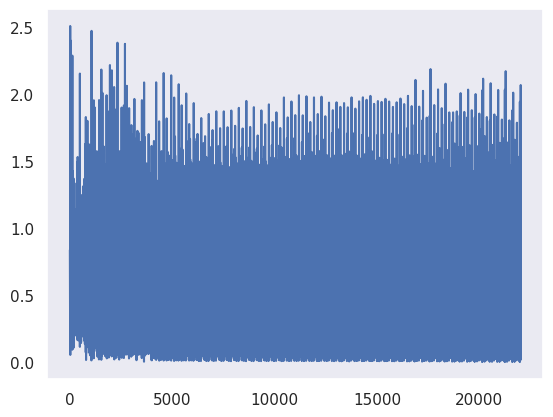

In [50]:
plt.plot(train_losses)

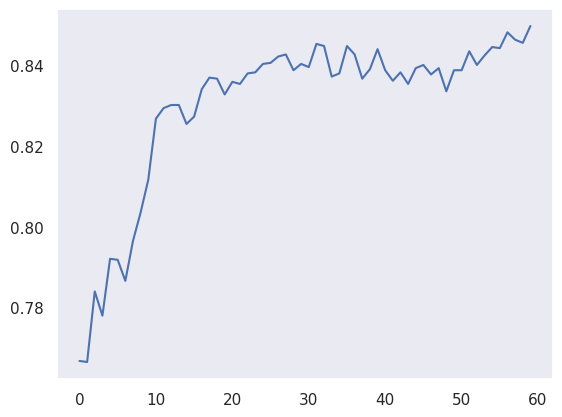

In [51]:
plt.plot(test_accuracy)

In [52]:
metrics2, confusion_matrix2 = report_metrics(model)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 3250/3808 (0.8535)
{'acc_detail': tensor([0.4875, 0.9631], device='cuda:0'),
 'acc_unweighted': tensor(0.7253, device='cuda:0'),
 'acc_weighted': tensor(0.8535, device='cuda:0'),
 'f1s': tensor(0.7577, device='cuda:0'),
 'f1s_detail': tensor([0.6054, 0.9100], device='cuda:0'),
 'precision_detail': tensor([0.7985, 0.8625], device='cuda:0'),
 'recall_detail': tensor([0.4875, 0.9631], device='cuda:0'),
 'rocauc': tensor([0.8849, 0.8849], device='cuda:0'),
 'uar': tensor(0.7253, device='cuda:0'),
 'wap': tensor(0.8477, device='cuda:0')}


tensor([[ 428,  450],
        [ 108, 2822]], device='cuda:0')

In [53]:
np.save('../physio16k_fold3_m13_60epochs_train_losses.npy', train_losses, allow_pickle=True)
np.save('../physio16k_fold3_m13_60epochs_test_accuracy.npy', test_accuracy, allow_pickle=True)

In [54]:
EPOCH = 60
PATH = '../physio16k_fold3_m13_60epochs_state.pt' 
LOSS = train_losses[-1]

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

In [55]:
layer21 = model.fe_blocks.blocks[0].block.layer
visualize_model.print_parameters(layer21)

('lowcut_bands', Parameter containing:
tensor([[0.0000],
        [0.0036],
        [0.0075],
        [0.0117],
        [0.0162],
        [0.0211],
        [0.0264],
        [0.0322],
        [0.0384],
        [0.0451],
        [0.0524],
        [0.0603],
        [0.0688],
        [0.0780],
        [0.0880],
        [0.0988],
        [0.1105],
        [0.1231],
        [0.1368],
        [0.1516],
        [0.1676],
        [0.1849],
        [0.2036],
        [0.2239],
        [0.2458],
        [0.2696],
        [0.2952],
        [0.3230],
        [0.3531],
        [0.3856],
        [0.4208],
        [0.4588],
        [0.0000],
        [0.0054],
        [0.0111],
        [0.0171],
        [0.0235],
        [0.0303],
        [0.0375],
        [0.0452],
        [0.0534],
        [0.0620],
        [0.0712],
        [0.0809],
        [0.0912],
        [0.1022],
        [0.1138],
        [0.1261],
        [0.1392],
        [0.1531],
        [0.1679],
        [0.1835],
        [0.2002],
       

In [56]:
[print(p.grad) for p in layer21.parameters() if p.requires_grad]

tensor([[ 0.0000e+00],
        [-4.5655e-15],
        [-2.4364e-15],
        [-5.8035e-15],
        [ 4.8613e-16],
        [-1.1357e-15],
        [ 7.1896e-17],
        [ 3.2702e-16],
        [ 9.3642e-15],
        [ 3.7441e-14],
        [-4.1273e-18],
        [-2.0445e-17],
        [ 1.3339e-17],
        [-1.4919e-14],
        [-4.0982e-13],
        [ 5.2934e-17],
        [-4.5185e-19],
        [ 8.1998e-16],
        [ 2.8394e-16],
        [-4.6733e-17],
        [-7.2766e-16],
        [ 4.0704e-15],
        [ 1.9273e-14],
        [ 1.7598e-16],
        [-7.7224e-19],
        [-4.8776e-16],
        [-1.1108e-15],
        [-1.7930e-17],
        [ 7.7219e-18],
        [-8.4894e-13],
        [-8.7045e-13],
        [-7.5369e-17],
        [ 0.0000e+00],
        [-1.0057e-15],
        [-1.0673e-16],
        [ 1.0805e-14],
        [ 3.0758e-13],
        [ 8.2573e-16],
        [ 6.8913e-15],
        [ 4.2548e-15],
        [-3.5212e-18],
        [-1.2503e-17],
        [-4.2856e-18],
        [ 1

[None, None, None]

(array([11.,  7.,  5.,  6.,  4.,  7.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
         1.,  3.,  4.,  3.,  2.,  3.,  3.,  3.,  2.,  2.,  2.,  3.,  2.,
         1.,  4.,  0.,  4.,  0.,  3.,  2.,  2.,  1.,  2.,  2.,  1.,  2.,
         3.]),
 array([0.        , 0.01191887, 0.02383774, 0.03575661, 0.04767548,
        0.05959435, 0.07151322, 0.08343209, 0.09535096, 0.10726982,
        0.1191887 , 0.13110757, 0.14302644, 0.1549453 , 0.16686417,
        0.17878304, 0.19070192, 0.20262079, 0.21453965, 0.22645852,
        0.23837739, 0.25029626, 0.26221514, 0.27413401, 0.28605288,
        0.29797173, 0.3098906 , 0.32180947, 0.33372834, 0.34564722,
        0.35756609, 0.36948496, 0.38140383, 0.39332271, 0.40524158,
        0.41716045, 0.42907929, 0.44099817, 0.45291704, 0.46483591,
        0.47675478]),
 <BarContainer object of 40 artists>)

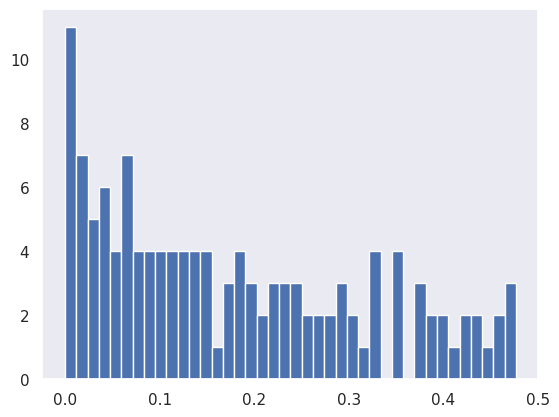

In [57]:
named_params21 = [p for p in layer21.named_parameters()]
lowbands21 = named_params21[0][1].detach().cpu().numpy()
plt.hist(lowbands21.flatten(), bins=40)

/tmp/ipykernel_3581021/369886909.py:2: RuntimeWarning: divide by zero encountered in log
  lowbands21_grad = np.log(lowbands21_grad.flatten())
/tmp/ipykernel_3581021/369886909.py:2: RuntimeWarning: invalid value encountered in log
  lowbands21_grad = np.log(lowbands21_grad.flatten())


(array([1., 0., 1., 1., 0., 1., 2., 0., 0., 0., 0., 0., 1., 2., 0., 2., 2.,
        4., 1., 2., 1., 2., 4., 1., 4., 3., 2., 1., 4., 1., 3., 1., 3., 3.,
        1., 0., 2., 1., 0., 1.]),
 array([-44.18355942, -43.79922104, -43.41488266, -43.03054428,
        -42.6462059 , -42.26186752, -41.87752914, -41.49319077,
        -41.10885239, -40.72451401, -40.34017563, -39.95583725,
        -39.57149887, -39.18716049, -38.80282593, -38.41848755,
        -38.03414917, -37.64981079, -37.26547241, -36.88113403,
        -36.49679565, -36.11245728, -35.7281189 , -35.34378052,
        -34.95944214, -34.57510376, -34.19076538, -33.806427  ,
        -33.42208862, -33.03775024, -32.65341187, -32.26907349,
        -31.88473511, -31.50039673, -31.11606026, -30.73172188,
        -30.3473835 , -29.96304512, -29.57870674, -29.19436836,
        -28.81002998]),
 <BarContainer object of 40 artists>)

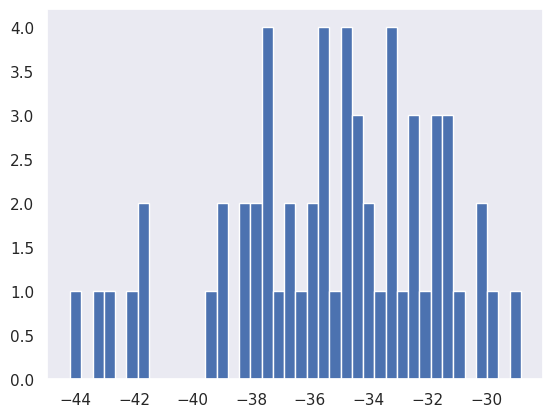

In [58]:
lowbands21_grad = named_params21[0][1].grad.detach().cpu().numpy()
lowbands21_grad = np.log(lowbands21_grad.flatten())
plt.hist(lowbands21_grad[lowbands21_grad > float('-inf')], bins=40)

(array([3., 4., 4., 5., 6., 6., 7., 8., 7., 5., 8., 6., 5., 5., 6., 3., 4.,
        5., 4., 4., 3., 3., 1., 3., 2., 2., 1., 0., 2., 0., 2., 0., 1., 1.,
        0., 0., 1., 0., 0., 1.]),
 array([0.0035846 , 0.00452443, 0.00546425, 0.00640408, 0.0073439 ,
        0.00828373, 0.00922356, 0.01016338, 0.01110321, 0.01204303,
        0.01298286, 0.01392268, 0.01486251, 0.01580233, 0.01674216,
        0.01768199, 0.01862181, 0.01956164, 0.02050146, 0.02144129,
        0.02238112, 0.02332094, 0.02426077, 0.02520059, 0.02614042,
        0.02708025, 0.02802007, 0.0289599 , 0.02989972, 0.03083955,
        0.03177937, 0.0327192 , 0.03365903, 0.03459885, 0.03553868,
        0.0364785 , 0.03741833, 0.03835815, 0.03929798, 0.0402378 ,
        0.04117763]),
 <BarContainer object of 40 artists>)

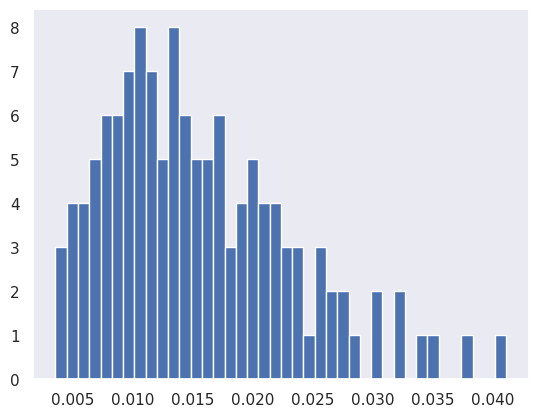

In [59]:
bandwidths21 = named_params21[1][1].detach().cpu().numpy()
plt.hist(bandwidths21.flatten(), bins=40)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   1., 120.,   2.,   0.,   0.,   3.]),
 array([-7.80398261e-13, -7.58528277e-13, -7.36658347e-13, -7.14788363e-13,
        -6.92918379e-13, -6.71048395e-13, -6.49178465e-13, -6.27308481e-13,
        -6.05438497e-13, -5.83568567e-13, -5.61698583e-13, -5.39828598e-13,
        -5.17958614e-13, -4.96088684e-13, -4.74218700e-13, -4.52348716e-13,
        -4.30478759e-13, -4.08608775e-13, -3.86738818e-13, -3.64868861e-13,
        -3.42998877e-13, -3.21128920e-13, -2.99258936e-13, -2.77388979e-13,
        -2.55518995e-13, -2.33649038e-13, -2.11779067e-13, -1.89909096e-13,
        -1.68039126e-13, -1.46169155e-13, -1.24299185e-13, -1.02429221e-13,
        -8.05592504e-14, -5.86892798e-14, -3.68193127e-14, -1.49493455e-14,
         6.92062425e-15,  2.87905923e-14, 

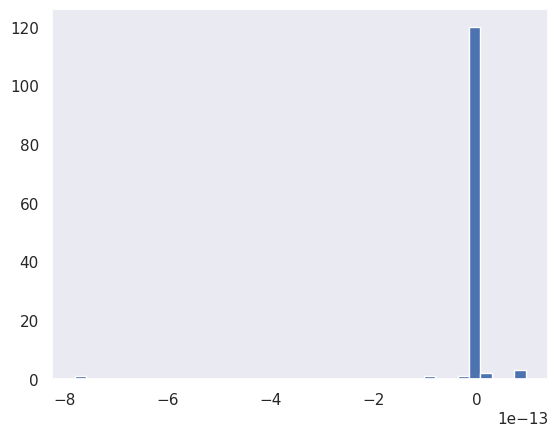

In [60]:
bandwidths21 = named_params21[1][1].grad.detach().cpu().numpy()
plt.hist(bandwidths21.flatten(), bins=40)

/tmp/ipykernel_3581021/1282254287.py:1: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(bandwidths21.flatten()), bins=40)


(array([3., 1., 1., 2., 0., 0., 2., 1., 0., 0., 0., 2., 0., 1., 0., 0., 3.,
        2., 3., 3., 6., 4., 4., 6., 3., 0., 0., 2., 3., 1., 0., 1., 2., 1.,
        2., 0., 0., 0., 0., 3.]),
 array([-45.79428101, -45.39920425, -45.0041275 , -44.60905075,
        -44.213974  , -43.81890106, -43.42382431, -43.02874756,
        -42.63367081, -42.23859406, -41.8435173 , -41.44844055,
        -41.05336761, -40.65829086, -40.26321411, -39.86813736,
        -39.47306061, -39.07798386, -38.6829071 , -38.28783035,
        -37.8927536 , -37.49768066, -37.10260391, -36.70752716,
        -36.31245041, -35.91737366, -35.52229691, -35.12722015,
        -34.73214722, -34.33707047, -33.94199371, -33.54691696,
        -33.15184021, -32.75676346, -32.36168671, -31.96661186,
        -31.57153511, -31.17645836, -30.78138351, -30.38630676,
        -29.99123001]),
 <BarContainer object of 40 artists>)

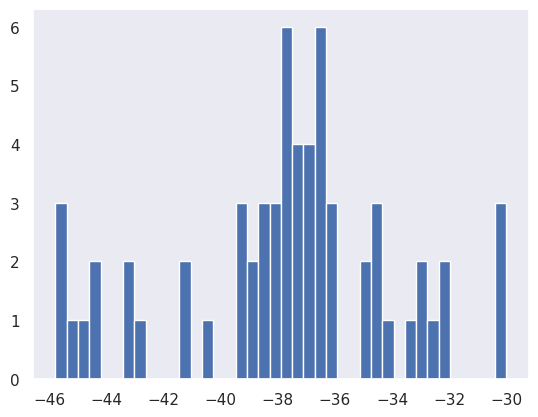

In [61]:
plt.hist(np.log(bandwidths21.flatten()), bins=40)

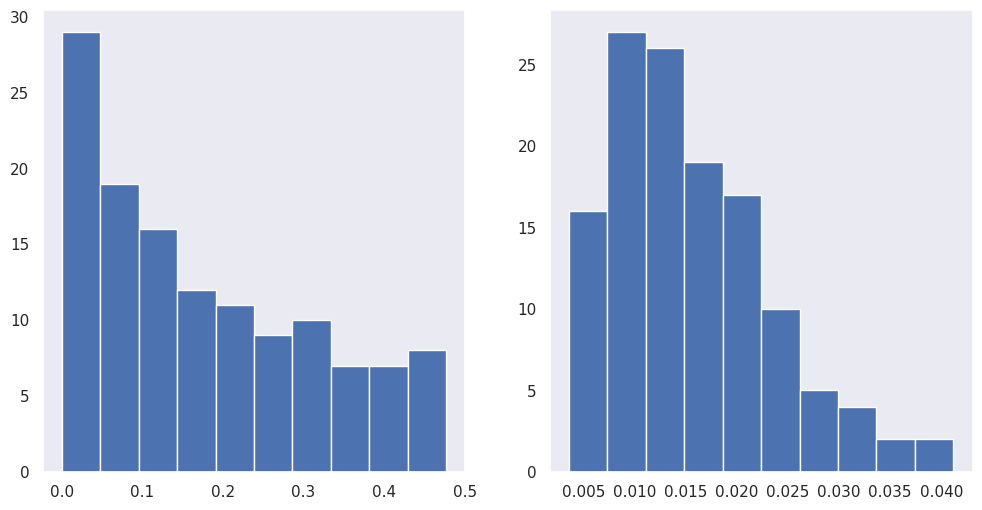

In [62]:
filtviz21 = visualize_model.FilterVisualizer(
    lowcut_bands = layer21.lowcut_bands, 
    bandwidths = layer21.bandwidths,
    window_params = layer21.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz21.visualize_bands()

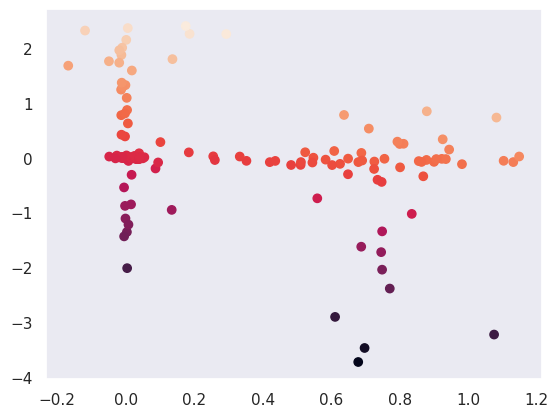

In [63]:
filtviz21.visualize_window_params()

Time domain: Filters' shapes vary by frequency bins


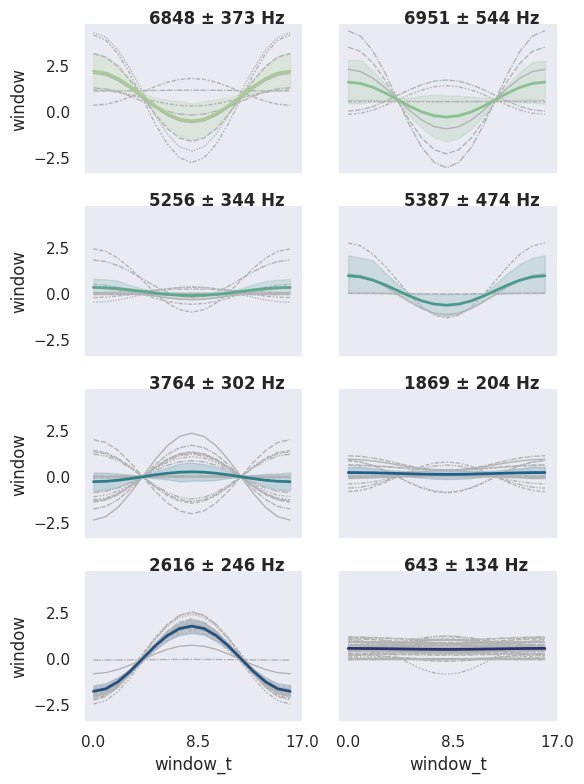

In [64]:
filtviz21.visualize_filters('time')

Frequency domain: Filters' shapes vary by frequency bins


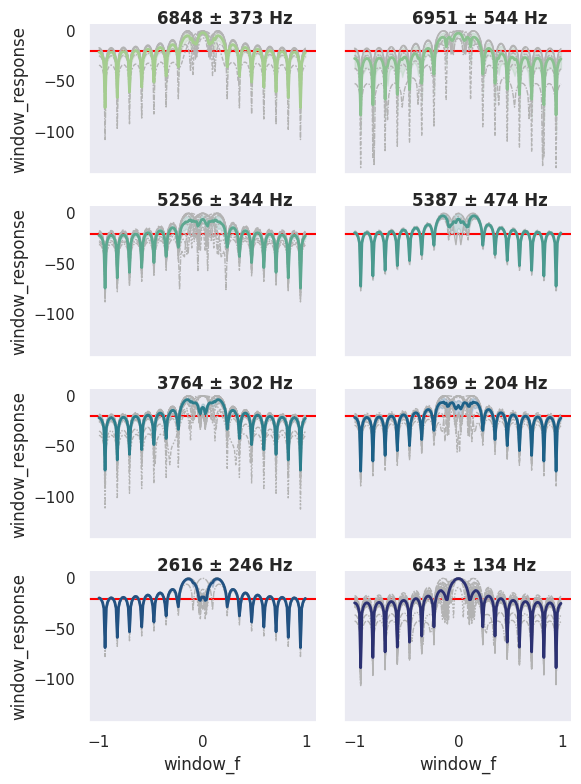

In [65]:
filtviz21.visualize_filters('freq')

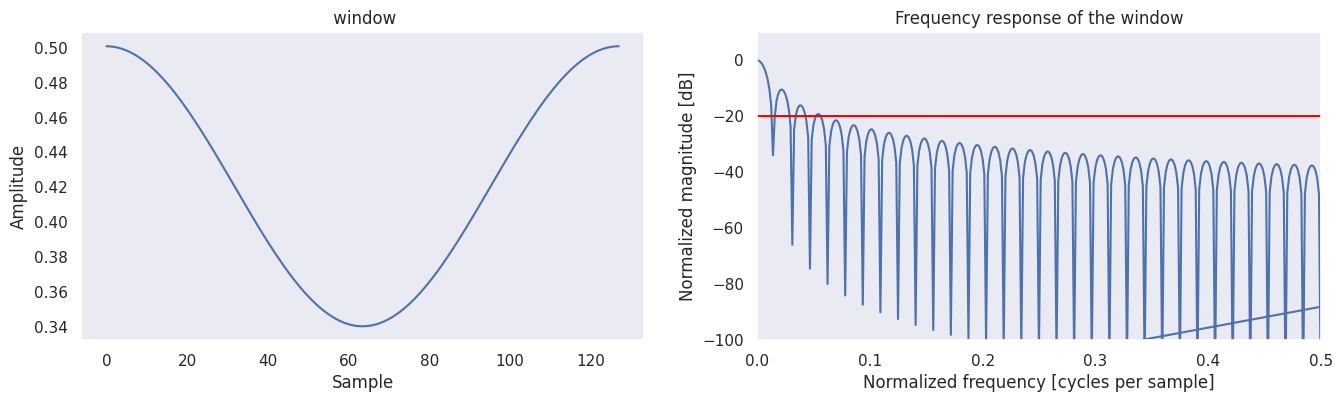

In [66]:
filtviz21.visualize_one_window()

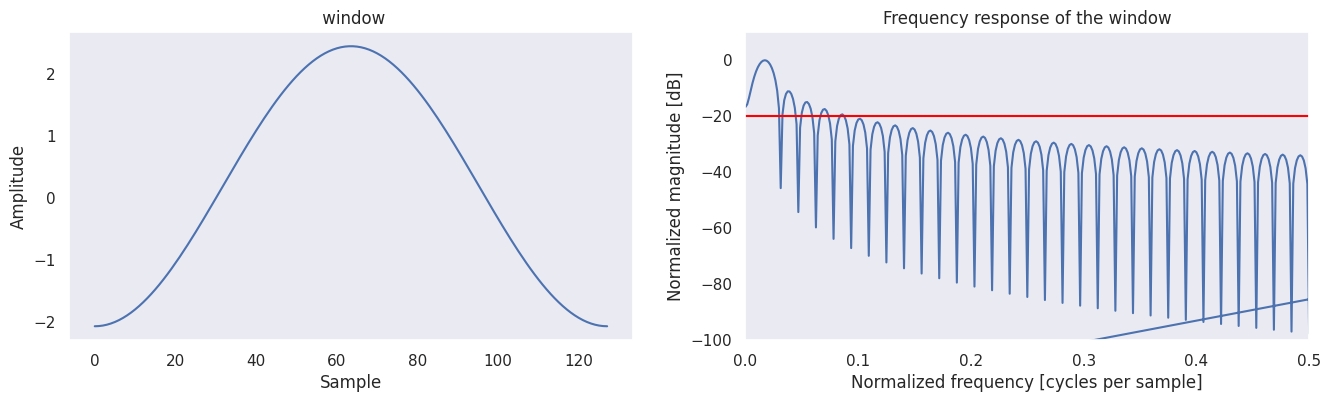

In [67]:
filtviz21.visualize_one_window(n_out=20)

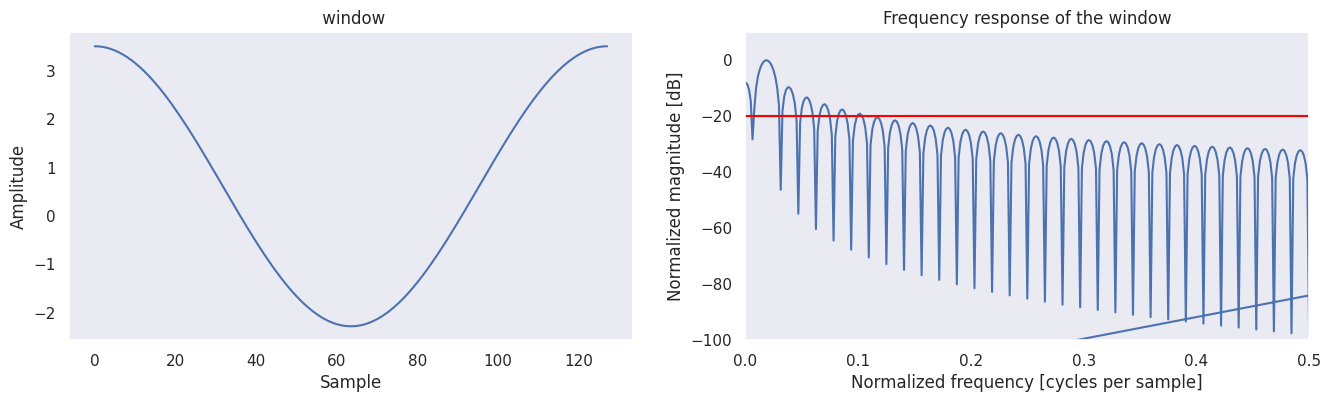

In [68]:
filtviz21.visualize_one_window(n_out=30)

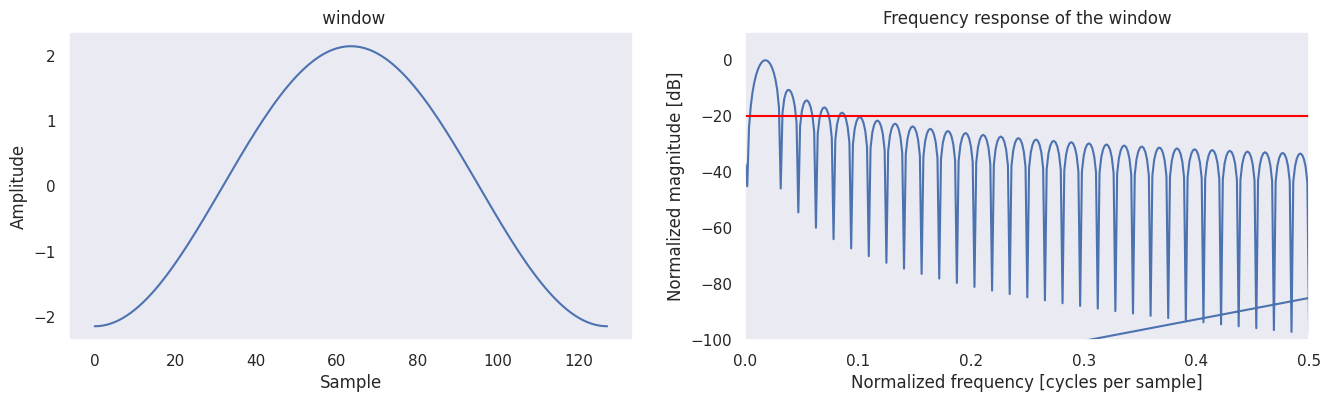

In [69]:
filtviz21.visualize_one_window(n_out=50)

In [70]:
layer22 = model.fe_blocks.blocks[1].block.layer
visualize_model.print_parameters(layer22)

('lowcut_bands', Parameter containing:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0162, 0.0162, 0.0162,  ..., 0.0162, 0.0162, 0.0162],
        [0.0384, 0.0384, 0.0384,  ..., 0.0384, 0.0384, 0.0384],
        ...,
        [0.2594, 0.2594, 0.2594,  ..., 0.2594, 0.2594, 0.2594],
        [0.3309, 0.3309, 0.3309,  ..., 0.3309, 0.3309, 0.3309],
        [0.4108, 0.4108, 0.4108,  ..., 0.4108, 0.4108, 0.4108]],
       device='cuda:0', requires_grad=True))
('bandwidths', Parameter containing:
tensor([[0.0162, 0.0162, 0.0162,  ..., 0.0162, 0.0162, 0.0162],
        [0.0222, 0.0222, 0.0222,  ..., 0.0222, 0.0222, 0.0222],
        [0.0304, 0.0304, 0.0304,  ..., 0.0304, 0.0304, 0.0304],
        ...,
        [0.0715, 0.0715, 0.0715,  ..., 0.0715, 0.0715, 0.0715],
        [0.0799, 0.0799, 0.0799,  ..., 0.0799, 0.0799, 0.0799],
        [0.0892, 0.0892, 0.0892,  ..., 0.0892, 0.0892, 0.0892]],
       device='cuda:0', requires_grad=True))
('window_params', Parameter containing

(array([512., 128., 128., 384.,   0., 128., 256.,   0., 256.,   0., 128.,
        128.,   0., 256.,   0.,   0., 256.,   0.,   0., 256.,   0.,   0.,
        128., 128.,   0., 128.,   0., 128.,   0., 128.,   0.,   0., 128.,
          0., 128.,   0., 128.,   0., 128., 128.]),
 array([0.        , 0.0102691 , 0.02053821, 0.03080731, 0.04107642,
        0.05134552, 0.06161463, 0.07188373, 0.08215284, 0.09242194,
        0.10269105, 0.11296015, 0.12322926, 0.13349836, 0.14376746,
        0.15403657, 0.16430567, 0.17457478, 0.18484388, 0.19511299,
        0.20538209, 0.2156512 , 0.2259203 , 0.23618941, 0.24645852,
        0.25672761, 0.26699671, 0.27726582, 0.28753492, 0.29780403,
        0.30807313, 0.31834224, 0.32861134, 0.33888045, 0.34914955,
        0.35941866, 0.36968777, 0.37995687, 0.39022598, 0.40049508,
        0.41076419]),
 <BarContainer object of 40 artists>)

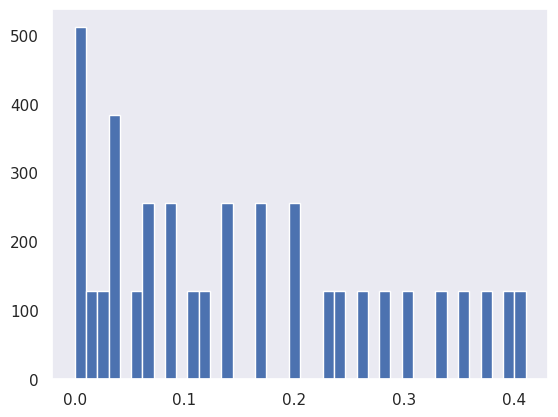

In [71]:
named_params22 = [p for p in layer22.named_parameters()]
lowbands22 = named_params22[0][1].detach().cpu().numpy()
plt.hist(lowbands22.flatten(), bins=40)

(array([1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 9.000e+00, 4.000e+00, 2.000e+00, 4.000e+00,
        5.000e+00, 1.000e+00, 8.000e+00, 4.000e+00, 8.000e+00, 1.400e+01,
        1.800e+01, 3.100e+01, 3.200e+01, 4.200e+01, 1.770e+02, 3.522e+03,
        1.420e+02, 2.400e+01, 2.000e+01, 8.000e+00, 5.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-2.93597247e-15, -2.80983550e-15, -2.68369853e-15, -2.55756156e-15,
        -2.43142459e-15, -2.30528762e-15, -2.17915065e-15, -2.05301389e-15,
        -1.92687692e-15, -1.80073995e-15, -1.67460298e-15, -1.54846601e-15,
        -1.42232904e-15, -1.29619207e-15, -1.17005510e-15, -1.04391813e-15,
        -9.17781162e-16, -7.91644245e-16, -6.65507275e-16, -5.39370358e-16,
        -4.13233388e-16, -2.87096444e-16, -1.60959474e-16, -3.48225237e-17,
         9.13144266e-17,  2.17451383e-16,  3.4

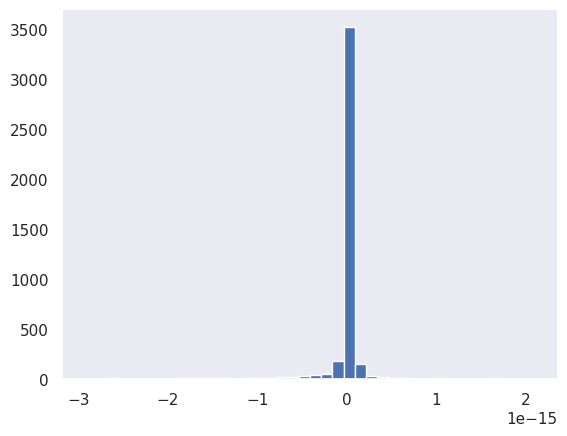

In [72]:
lowbands22 = named_params22[0][1].grad.detach().cpu().numpy()
plt.hist(lowbands22.flatten(), bins=40)

/tmp/ipykernel_3581021/1558741381.py:1: RuntimeWarning: divide by zero encountered in log
  grad_log = np.log(lowbands22.flatten())
/tmp/ipykernel_3581021/1558741381.py:1: RuntimeWarning: invalid value encountered in log
  grad_log = np.log(lowbands22.flatten())


(array([ 2.,  0.,  3.,  1.,  6.,  8.,  6., 11., 19., 19., 27., 41., 44.,
        54., 59., 58., 37., 51., 46., 69., 82., 92., 93., 78., 85., 59.,
        69., 57., 56., 73., 60., 77., 67., 80., 34., 22., 21.,  3.,  3.,
         5.]),
 array([-50.31180191, -49.89881516, -49.4858284 , -49.07284164,
        -48.65985489, -48.24686813, -47.83388138, -47.42089462,
        -47.00790787, -46.59492111, -46.18193054, -45.76894379,
        -45.35595703, -44.94297028, -44.52998352, -44.11699677,
        -43.70401001, -43.29102325, -42.8780365 , -42.46504974,
        -42.05206299, -41.63907623, -41.22608948, -40.81310272,
        -40.40011597, -39.98712921, -39.57414246, -39.1611557 ,
        -38.74816895, -38.33518219, -37.92219543, -37.50920486,
        -37.09621811, -36.68323135, -36.2702446 , -35.85725784,
        -35.44427109, -35.03128433, -34.61829758, -34.20531082,
        -33.79232407]),
 <BarContainer object of 40 artists>)

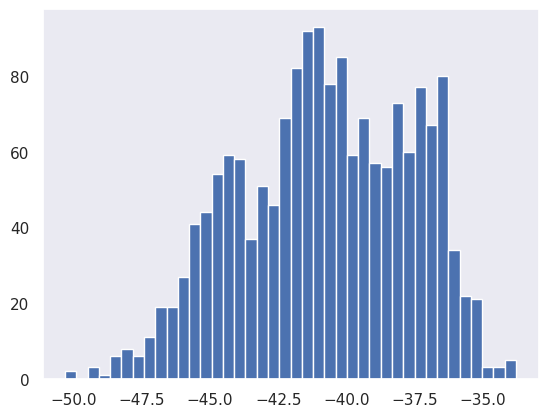

In [73]:
grad_log = np.log(lowbands22.flatten())
grad_log = grad_log[grad_log > float('-inf')]
plt.hist(grad_log, bins=40)

(array([128., 128., 128.,   0., 384.,   0., 256., 256., 128., 256., 128.,
        128., 256., 128., 256.,   0., 128., 128., 256., 128.,   0.,   0.,
        256.,   0.,   0., 128.,   0., 256.,   0.,   0.,   0.,   0.,   0.,
        128.,   0.,   0.,   0.,   0.,   0., 128.]),
 array([0.01619883, 0.01946704, 0.02273525, 0.02600346, 0.02927167,
        0.03253987, 0.03580808, 0.03907629, 0.0423445 , 0.04561271,
        0.04888092, 0.05214913, 0.05541734, 0.05868555, 0.06195376,
        0.06522197, 0.06849018, 0.07175838, 0.07502659, 0.0782948 ,
        0.08156301, 0.08483122, 0.08809943, 0.09136764, 0.09463584,
        0.09790406, 0.10117227, 0.10444047, 0.10770869, 0.11097689,
        0.1142451 , 0.11751331, 0.12078152, 0.12404973, 0.12731794,
        0.13058615, 0.13385436, 0.13712257, 0.14039077, 0.14365898,
        0.14692719]),
 <BarContainer object of 40 artists>)

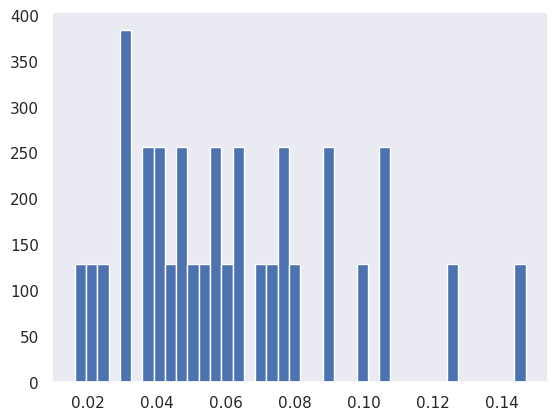

In [74]:
bandwidths22 = named_params22[1][1].detach().cpu().numpy()
plt.hist(bandwidths22.flatten(), bins=40)

(array([1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 3.000e+00, 1.000e+00, 4.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 4.000e+00, 5.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 5.000e+00, 6.000e+00, 8.000e+00, 9.000e+00,
        9.200e+01, 3.939e+03, 7.000e+00, 1.000e+00]),
 array([-5.07579276e-14, -4.93893561e-14, -4.80207881e-14, -4.66522166e-14,
        -4.52836485e-14, -4.39150771e-14, -4.25465090e-14, -4.11779375e-14,
        -3.98093695e-14, -3.84407980e-14, -3.70722299e-14, -3.57036585e-14,
        -3.43350904e-14, -3.29665189e-14, -3.15979508e-14, -3.02293794e-14,
        -2.88608113e-14, -2.74922398e-14, -2.61236701e-14, -2.47551003e-14,
        -2.33865305e-14, -2.20179608e-14, -2.06493910e-14, -1.92808212e-14,
        -1.79122515e-14, -1.65436817e-14, -1.5

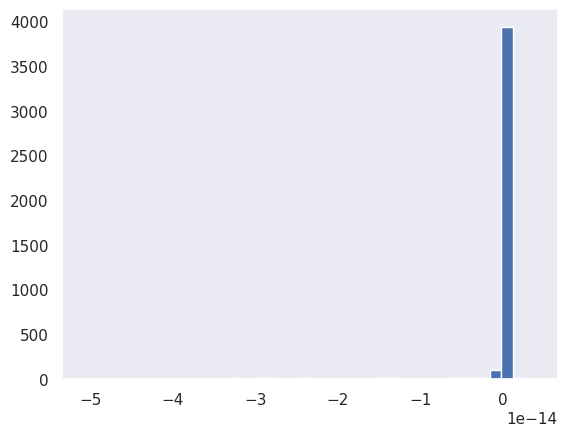

In [75]:
bandwidths22 = named_params22[1][1].grad.detach().cpu().numpy()
plt.hist(bandwidths22.flatten(), bins=40)

/tmp/ipykernel_3581021/636885685.py:1: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(bandwidths22.flatten()), bins=40)


(array([  1.,   2.,   0.,   0.,   1.,   3.,   2.,   9.,  17.,  15.,  22.,
         37.,  43.,  44.,  53.,  94., 111., 133., 139., 148., 131., 116.,
        128., 127.,  96.,  89.,  82.,  95.,  90.,  52.,  39.,  47.,  22.,
         36.,  37.,  16.,  12.,   6.,   6.,   1.]),
 array([-55.26167679, -54.7090416 , -54.1564064 , -53.60377121,
        -53.05113602, -52.49850082, -51.94586563, -51.39323044,
        -50.84059525, -50.28796005, -49.73532486, -49.18268967,
        -48.63005447, -48.07741928, -47.52478409, -46.9721489 ,
        -46.4195137 , -45.86687851, -45.31424332, -44.76160812,
        -44.20897675, -43.65634155, -43.10370636, -42.55107117,
        -41.99843597, -41.44580078, -40.89316559, -40.3405304 ,
        -39.7878952 , -39.23526001, -38.68262482, -38.12998962,
        -37.57735443, -37.02471924, -36.47208405, -35.91944885,
        -35.36681366, -34.81417847, -34.26154327, -33.70890808,
        -33.15627289]),
 <BarContainer object of 40 artists>)

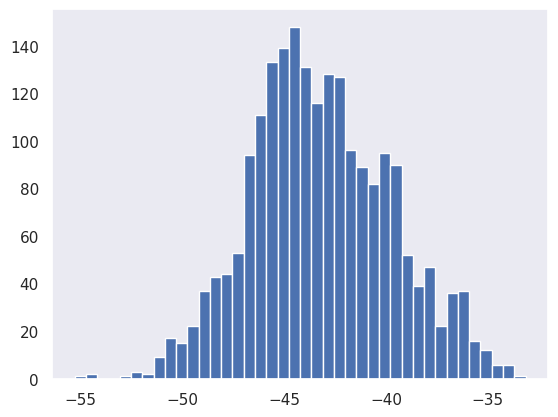

In [76]:
plt.hist(np.log(bandwidths22.flatten()), bins=40)

downsample_factor: 8 => new_sample_rate: 2000


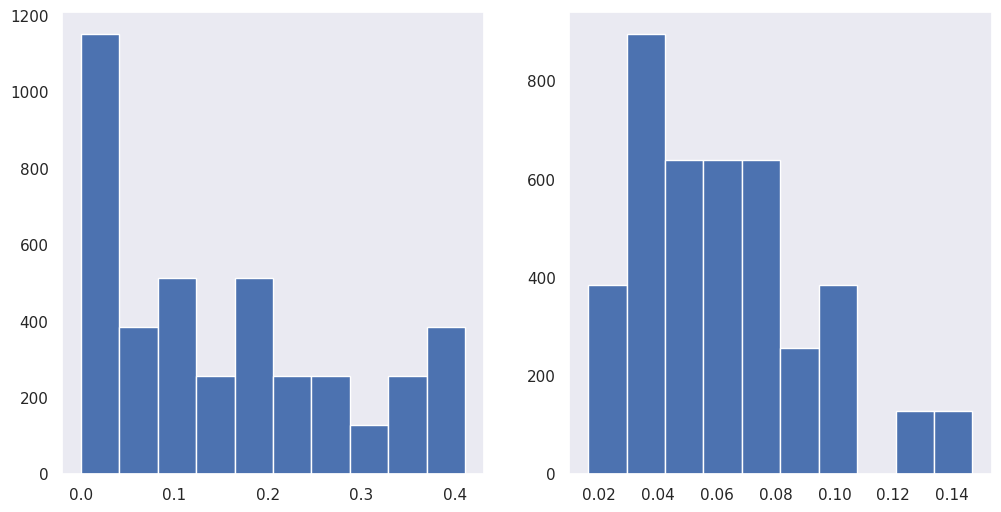

In [77]:
downsample_factor = model.fe_blocks.blocks[0].stride
new_sample_rate = sr // downsample_factor
print(f'downsample_factor: {downsample_factor} => new_sample_rate: {new_sample_rate}')

filtviz22 = visualize_model.FilterVisualizer(
    lowcut_bands = layer22.lowcut_bands, 
    bandwidths = layer22.bandwidths,
    window_params = layer22.window_params, 
    window_length = 64,
    sample_rate = new_sample_rate
)
filtviz22.visualize_bands()

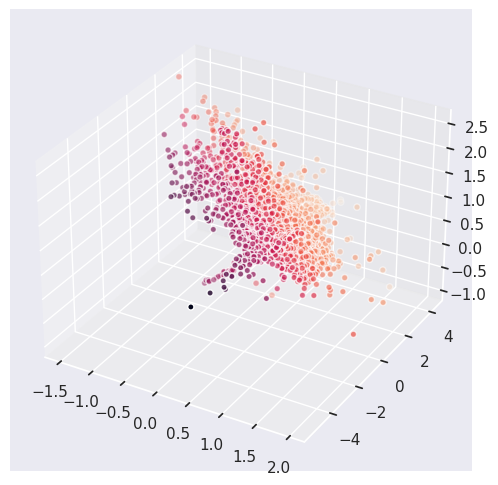

In [78]:
filtviz22.visualize_window_params()

Time domain: Filters' shapes vary by frequency bins


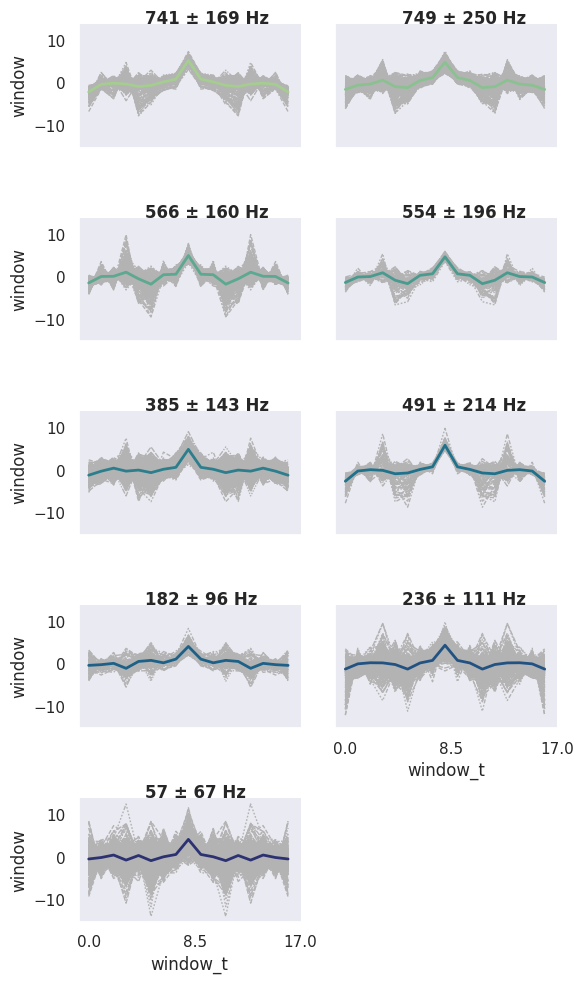

In [79]:
filtviz22.visualize_filters('time')

Frequency domain: Filters' shapes vary by frequency bins


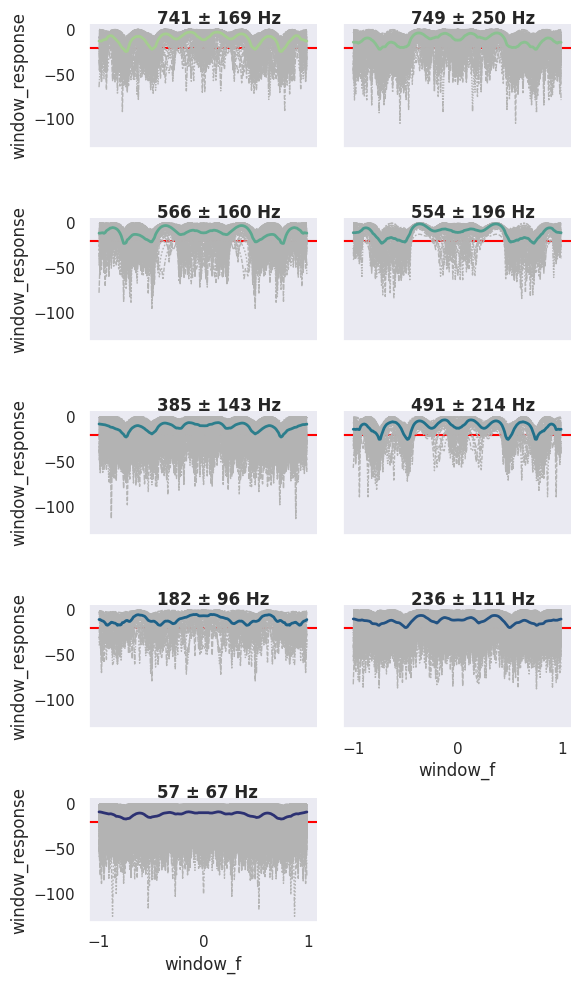

In [80]:
filtviz22.visualize_filters('freq')

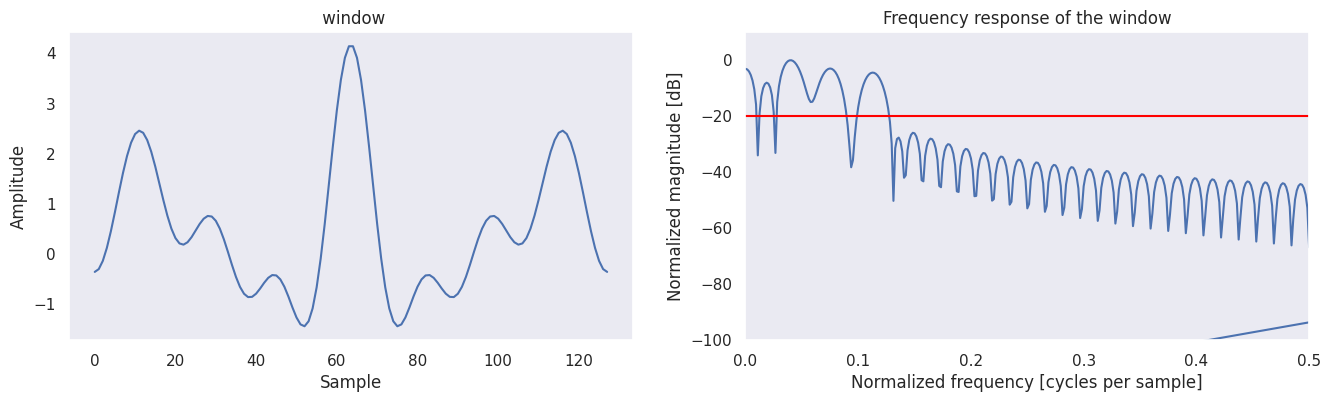

In [81]:
filtviz22.visualize_one_window(n_inp=0, n_out=0)

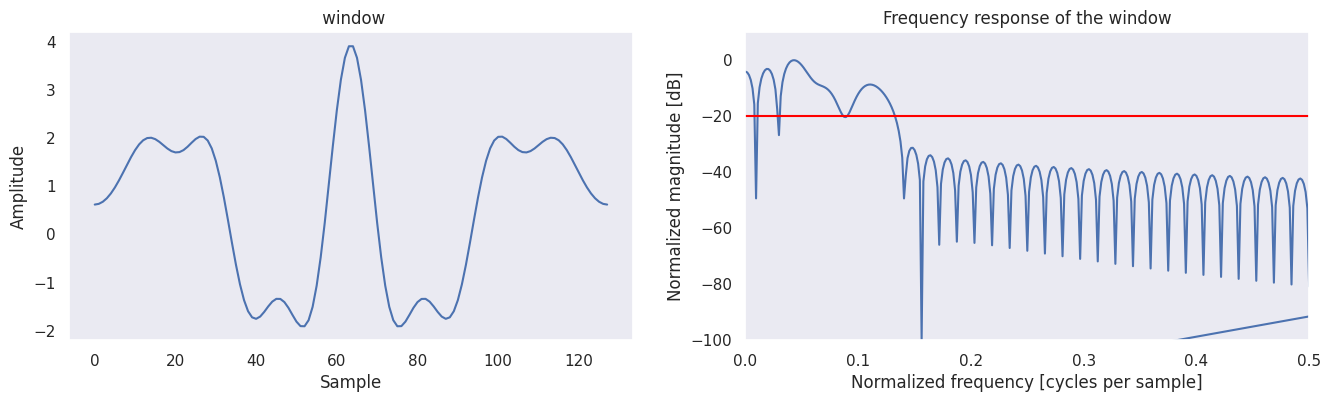

In [82]:
filtviz22.visualize_one_window(n_inp=0, n_out=10)

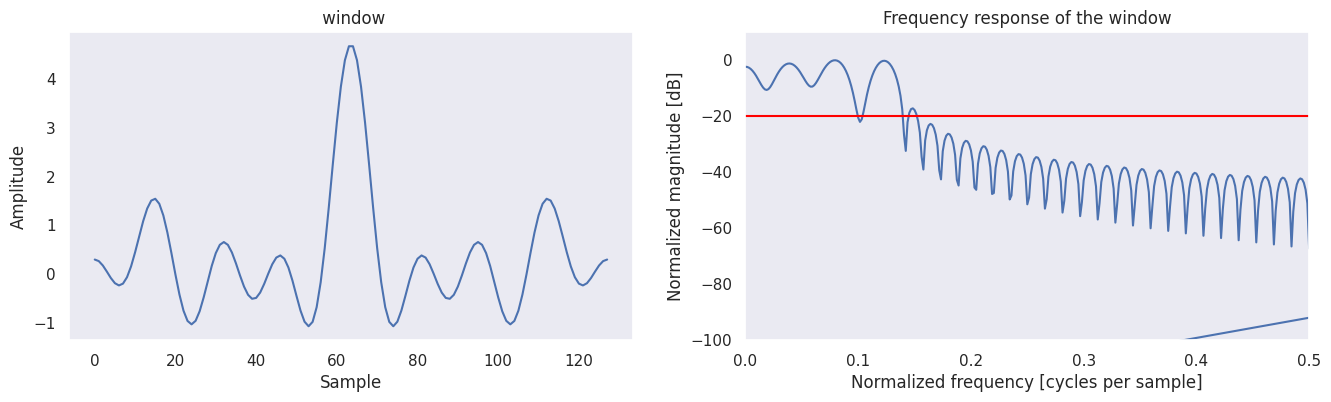

In [83]:
filtviz22.visualize_one_window(n_inp=10, n_out=10)

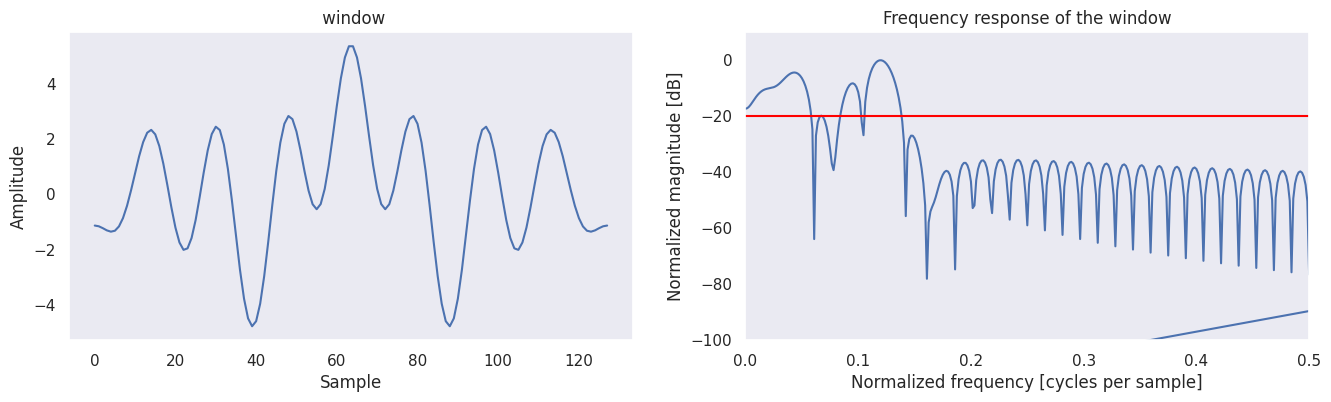

In [84]:
filtviz22.visualize_one_window(n_inp=60, n_out=10)